# Damped harmonic oscillator

$$\mathcal{H} = \frac{p^2}{2} + \frac{q^2}{2} + \frac{s}{10}$$

In [1]:
import torch, time, sys
import autograd
import autograd.numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import scipy.integrate
solve_ivp = scipy.integrate.solve_ivp

EXPERIMENT_DIR = './experiment-spring'
sys.path.append(EXPERIMENT_DIR)

from data import get_dataset, get_field, get_trajectory, dynamics_fn, hamiltonian_fn , kofmotion , k2_fn
from nn_models import MLP
from hnn import HNN
from utils import L2_loss

plt.rcParams['font.size'] = 16
plt.rcParams['font.family'] = "serif"
plt.rcParams['axes.labelsize'] = 20
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['xtick.direction'] = "in"
plt.rcParams['xtick.bottom'] = True
plt.rcParams['xtick.major.size'] = 5
plt.rcParams['ytick.labelsize'] = 14
plt.rcParams['ytick.direction'] = "in"
plt.rcParams['ytick.left'] = True
plt.rcParams['ytick.major.size'] = 5
plt.rcParams['legend.fontsize'] = 18
plt.rcParams['mathtext.fontset'] = "cm"
plt.rcParams["savefig.bbox"] = 'tight'

## Set some notebook constants

In [2]:
DPI = 300
FORMAT = 'pdf'
LINE_SEGMENTS = 10
ARROW_SCALE = 30
ARROW_WIDTH = 6e-3
LINE_WIDTH = 2
RK4 = ''

def get_args():
    return {'input_dim': 3,
         'hidden_dim': 200,
         'learn_rate': 1e-4,
         'nonlinearity': 'tanh',
         'total_steps': 2000,
         'field_type': 'contact',
         'print_every': 200,
         'name': 'spring',
         'gridsize': 10,
         'input_noise': 0.5,
         'seed': 0,
         'save_dir': './{}'.format(EXPERIMENT_DIR),
         'fig_dir': './figures'}

class ObjectView(object):
    def __init__(self, d): self.__dict__ = d

## Inspect the dataset

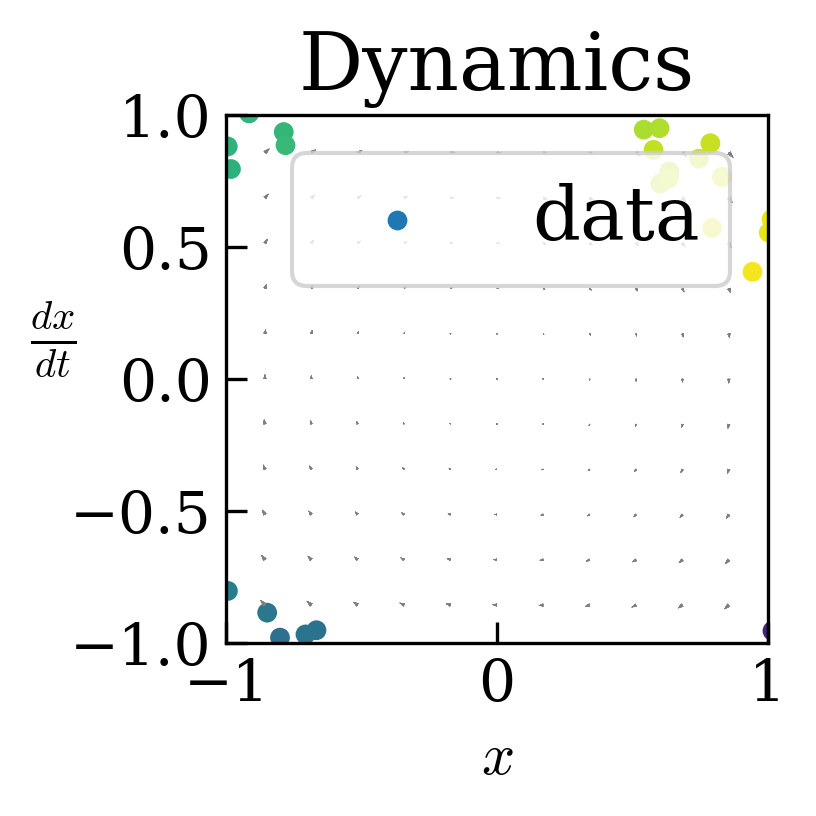

In [3]:
args = ObjectView(get_args())
# np.random.seed(args.seed)
field = get_field(gridsize=15)
data = get_dataset() 
# data of training and testing as a dictionary
# splitted by coordinates {'x'} and {'dx'}

# plot config
fig = plt.figure(figsize=(3, 3), facecolor='white', dpi=DPI)

x, y, z, dx, dy, dz, t = get_trajectory(radius=1, y0=np.array([1.5,0,2]),timescale=20)
# solution given by the numerical integrator and a noise
plt.scatter(x,y,c=t,s=14, label='data')
plt.quiver(field['x'][:,0], field['x'][:,1], field['dx'][:,0], field['dx'][:,1],
           cmap='gray_r', color=(.5,.5,.5))
plt.xlabel("$x$", fontsize=14)
plt.ylabel("$\\frac{dx}{dt}$", rotation=0, fontsize=14)
plt.title("Dynamics")
plt.legend(loc='upper right')
plt.xlim(-1,1)
plt.ylim(-1,1)

plt.tight_layout() ; plt.show()
# fig.savefig(fig_dir + '/spring-task.png')

## Construct models

In [4]:
def get_model(args, baseline,hamint=False):
    output_dim = args.input_dim if baseline else 2
    nn_model = MLP(args.input_dim, args.hidden_dim, output_dim, args.nonlinearity)
    model = HNN(args.input_dim, differentiable_model=nn_model,
              field_type=args.field_type, baseline=baseline)
    
    model_name = 'baseline' if baseline else 'hnn'
    model_name = 'hamint-' + model_name if hamint else model_name
    path = "{}/spring{}-{}.tar".format(args.save_dir, RK4, model_name)
    model.load_state_dict(torch.load(path))
    return model

## Get vector fields

In [5]:
def get_vector_field(model, **kwargs):
    field = get_field(**kwargs)
    np_mesh_x = field['x']
    
    # run model
    mesh_x = torch.tensor( np_mesh_x, requires_grad=True, dtype=torch.float32)
    mesh_dx = model.time_derivative(mesh_x)
    return mesh_dx.data.numpy()

## Integrate along vector fields

In [6]:
def integrate_model(model, t_span, y0, **kwargs):

    def fun(t, np_x):
        x = torch.tensor( np_x, requires_grad=True, dtype=torch.float32).view(1,3)
        dx = model.time_derivative(x).data.numpy().reshape(-1)
        return dx
    return solve_ivp(fun=fun, t_span=t_span, y0=y0, **kwargs)

## Run analysis

In [7]:
base_model = get_model(args, baseline=True)
hnn_model = get_model(args, baseline=False)
hnn_model_ht = get_model(args, baseline=False, hamint=True)

# get their vector fields
field = get_field(gridsize=args.gridsize)
data = get_dataset(samples=1)
base_field = get_vector_field(base_model, gridsize=args.gridsize)
hnn_field = get_vector_field(hnn_model, gridsize=args.gridsize)
hnn_field_ht = get_vector_field(hnn_model_ht, gridsize=args.gridsize)

# integrate along those fields starting from point (1,0)
t_span = [0,30]
y0 = np.asarray([2, -1.,-2])
kwargs = {'t_eval': np.linspace(t_span[0], t_span[1], 1000), 'rtol': 1e-12}
base_ivp = integrate_model(base_model, t_span, y0, **kwargs)
hnn_ivp = integrate_model(hnn_model, t_span, y0, **kwargs)
hnn_ivp_ht = integrate_model(hnn_model_ht, t_span, y0, **kwargs)

## Plot results

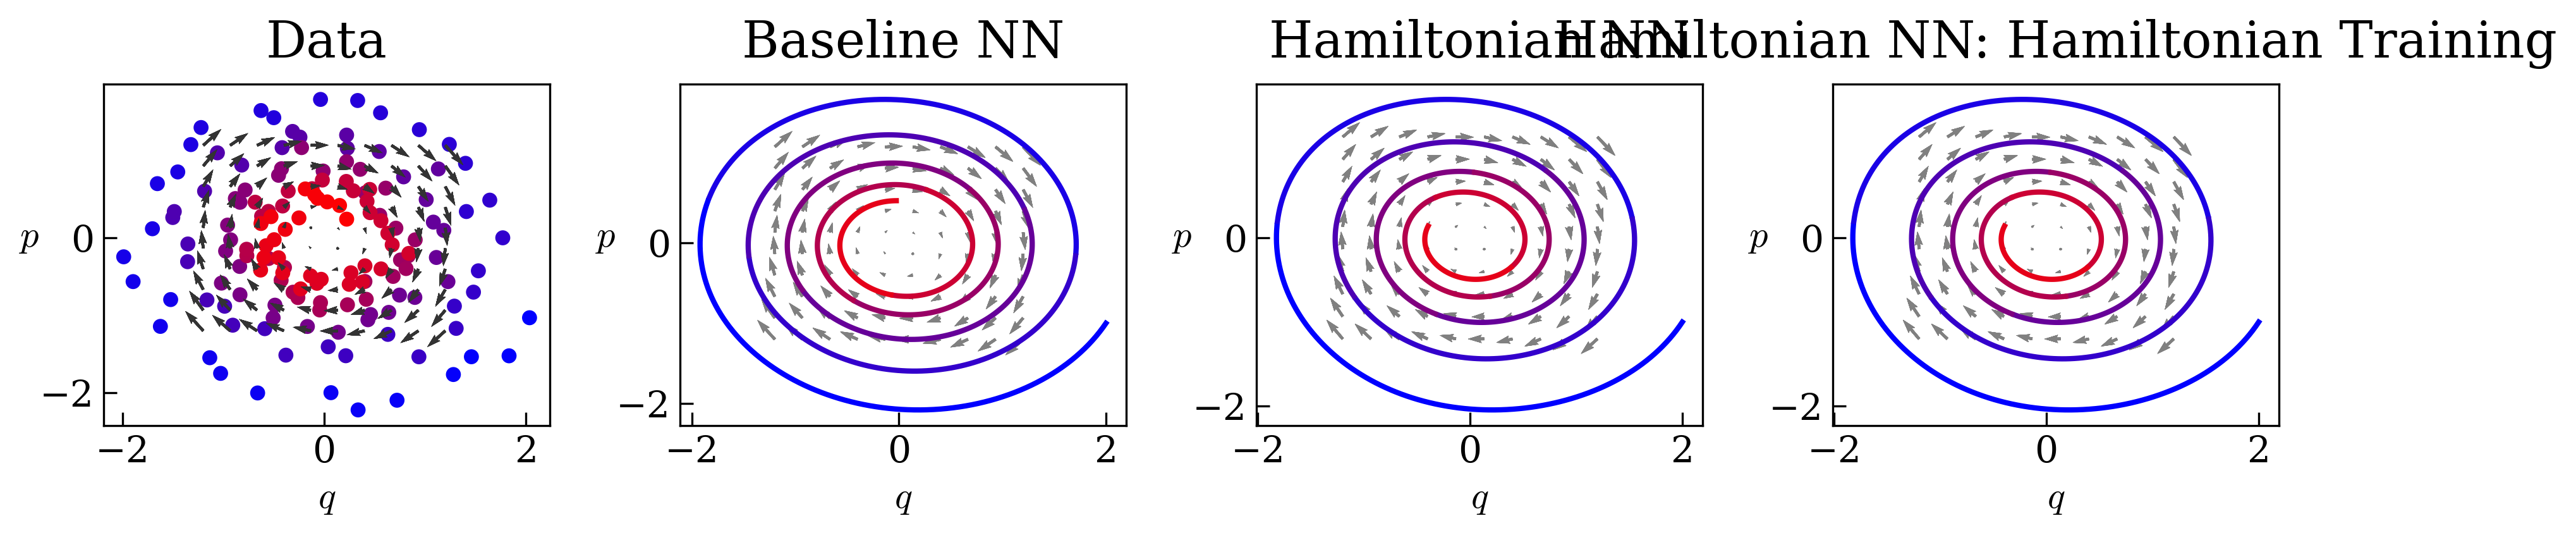

In [8]:
###### PLOT ######
fig = plt.figure(figsize=(12.4, 3.1), facecolor='white', dpi=DPI)

# plot physical system
#fig.add_subplot(1, 4, 1, frameon=True) 
#plt.xticks([]) ;  plt.yticks([])
#schema = mpimg.imread(EXPERIMENT_DIR + '/mass-spring.png')
#plt.imshow(schema)
#plt.title("Mass-spring system", pad=10)

# plot dynamics
fig.add_subplot(1, 4, 1, frameon=True)
x, y, z, dx, dy, dz, t = get_trajectory(radius=1, y0=np.array([2,-1,-2]),timescale=5,t_span=[0.,30.])
N = len(x)
point_colors = [(i/N, 0, 1-i/N) for i in range(N)]
plt.scatter(x,y, s=22, label='data', c=point_colors)

plt.quiver(field['x'][:,0], field['x'][:,1], field['dx'][:,0], field['dx'][:,1],
        cmap='gray_r', scale=ARROW_SCALE, width=ARROW_WIDTH, color=(.2,.2,.2))  
plt.xlabel("$q$", fontsize=14)
plt.ylabel("$p$", rotation=0, fontsize=14)
plt.title("Data", pad=10)

# plot baseline
fig.add_subplot(1, 4, 2, frameon=True)
plt.quiver(field['x'][:,0], field['x'][:,1], base_field[:,0], base_field[:,1],
        cmap='gray_r', scale=ARROW_SCALE, width=ARROW_WIDTH, color=(.5,.5,.5))

for i, l in enumerate(np.split(base_ivp['y'].T, LINE_SEGMENTS)):
    color = (float(i)/LINE_SEGMENTS, 0, 1-float(i)/LINE_SEGMENTS)
    plt.plot(l[:,0],l[:,1],color=color, linewidth=LINE_WIDTH)
    
plt.xlabel("$q$", fontsize=14)
plt.ylabel("$p$", rotation=0, fontsize=14)
plt.title("Baseline NN", pad=10)

# plot HNN
fig.add_subplot(1, 4, 3, frameon=True)
plt.quiver(field['x'][:,0], field['x'][:,1], hnn_field[:,0], hnn_field[:,1],
        cmap='gray_r', scale=ARROW_SCALE, width=ARROW_WIDTH, color=(.5,.5,.5))

for i, l in enumerate(np.split(hnn_ivp['y'].T, LINE_SEGMENTS)):
    color = (float(i)/LINE_SEGMENTS, 0, 1-float(i)/LINE_SEGMENTS)
    plt.plot(l[:,0],l[:,1],color=color, linewidth=LINE_WIDTH)

plt.xlabel("$q$", fontsize=14)
plt.ylabel("$p$", rotation=0, fontsize=14)
plt.title("Hamiltonian NN", pad=10)

# plot HNN
fig.add_subplot(1, 4, 4, frameon=True)
plt.quiver(field['x'][:,0], field['x'][:,1], hnn_field_ht[:,0], hnn_field_ht[:,1],
        cmap='gray_r', scale=ARROW_SCALE, width=ARROW_WIDTH, color=(.5,.5,.5))

for i, l in enumerate(np.split(hnn_ivp_ht['y'].T, LINE_SEGMENTS)):
    color = (float(i)/LINE_SEGMENTS, 0, 1-float(i)/LINE_SEGMENTS)
    plt.plot(l[:,0],l[:,1],color=color, linewidth=LINE_WIDTH)

plt.xlabel("$q$", fontsize=14)
plt.ylabel("$p$", rotation=0, fontsize=14)
plt.title("Hamiltonian NN: Hamiltonian Training", pad=10)

plt.tight_layout() ; plt.show()
#fig.savefig('{}/spring{}.{}'.format(args.fig_dir, RK4, FORMAT))

## Quantitative analysis
* Choose trajectories from the test set
* Measure vector field loss at each point
* Integrate along trajectory and measure mean loss between points

In [9]:
def integrate_models(x0=np.asarray([1, 0,3]), t_span=[0,100], t_eval=None, noise_std=0.1):
    # integrate along ground truth vector field
    kwargs = {'t_eval': t_eval, 'rtol': 1e-12}
    true_path = solve_ivp(fun=dynamics_fn, t_span=t_span, y0=x0, **kwargs)
    true_x = true_path['y'].T
    
    # rescale time to compensate for noise effects, as described in appendix
    t_span[1] *= 1 + .9*noise_std
    t_eval *= 1 + .9*noise_std

    # integrate along baseline vector field
    base_path = integrate_model(base_model, t_span, x0, **kwargs)
    base_x = base_path['y'].T
    _tmp = torch.tensor( true_x, requires_grad=True, dtype=torch.float32)

    # integrate along HNN vector field
    hnn_path = integrate_model(hnn_model, t_span, x0, **kwargs)
    hnn_x = hnn_path['y'].T
    _tmp = torch.tensor( true_x, requires_grad=True, dtype=torch.float32)

    # integrate along HNN vector field
    hnn_path_ht = integrate_model(hnn_model_ht, t_span, x0, **kwargs)
    hnn_x_ht = hnn_path_ht['y'].T
    _tmp = torch.tensor( true_x, requires_grad=True, dtype=torch.float32)
    
    return true_x, base_x, hnn_x, hnn_x_ht

def contact_baseline_energy(x):
    vx=base_model(torch.Tensor(x)).detach().numpy()
    E=np.zeros(len(x))
    for i in range(len(x)):
        eta=np.array([-x[i,1],0,1])
        E[i]=-(np.dot(vx[i,:],eta))
    return E

def energy_loss(true_x, integrated_x,baseline=False):
    true_energy = np.stack([hamiltonian_fn(c) for c in true_x])
    if baseline:
        integration_energy = np.stack([hamiltonian_fn(c) for c in integrated_x])
    else:
        integration_energy = hnn_model(torch.Tensor(integrated_x))[1].detach().numpy().squeeze()
    return np.mean((true_energy - integration_energy)**2)

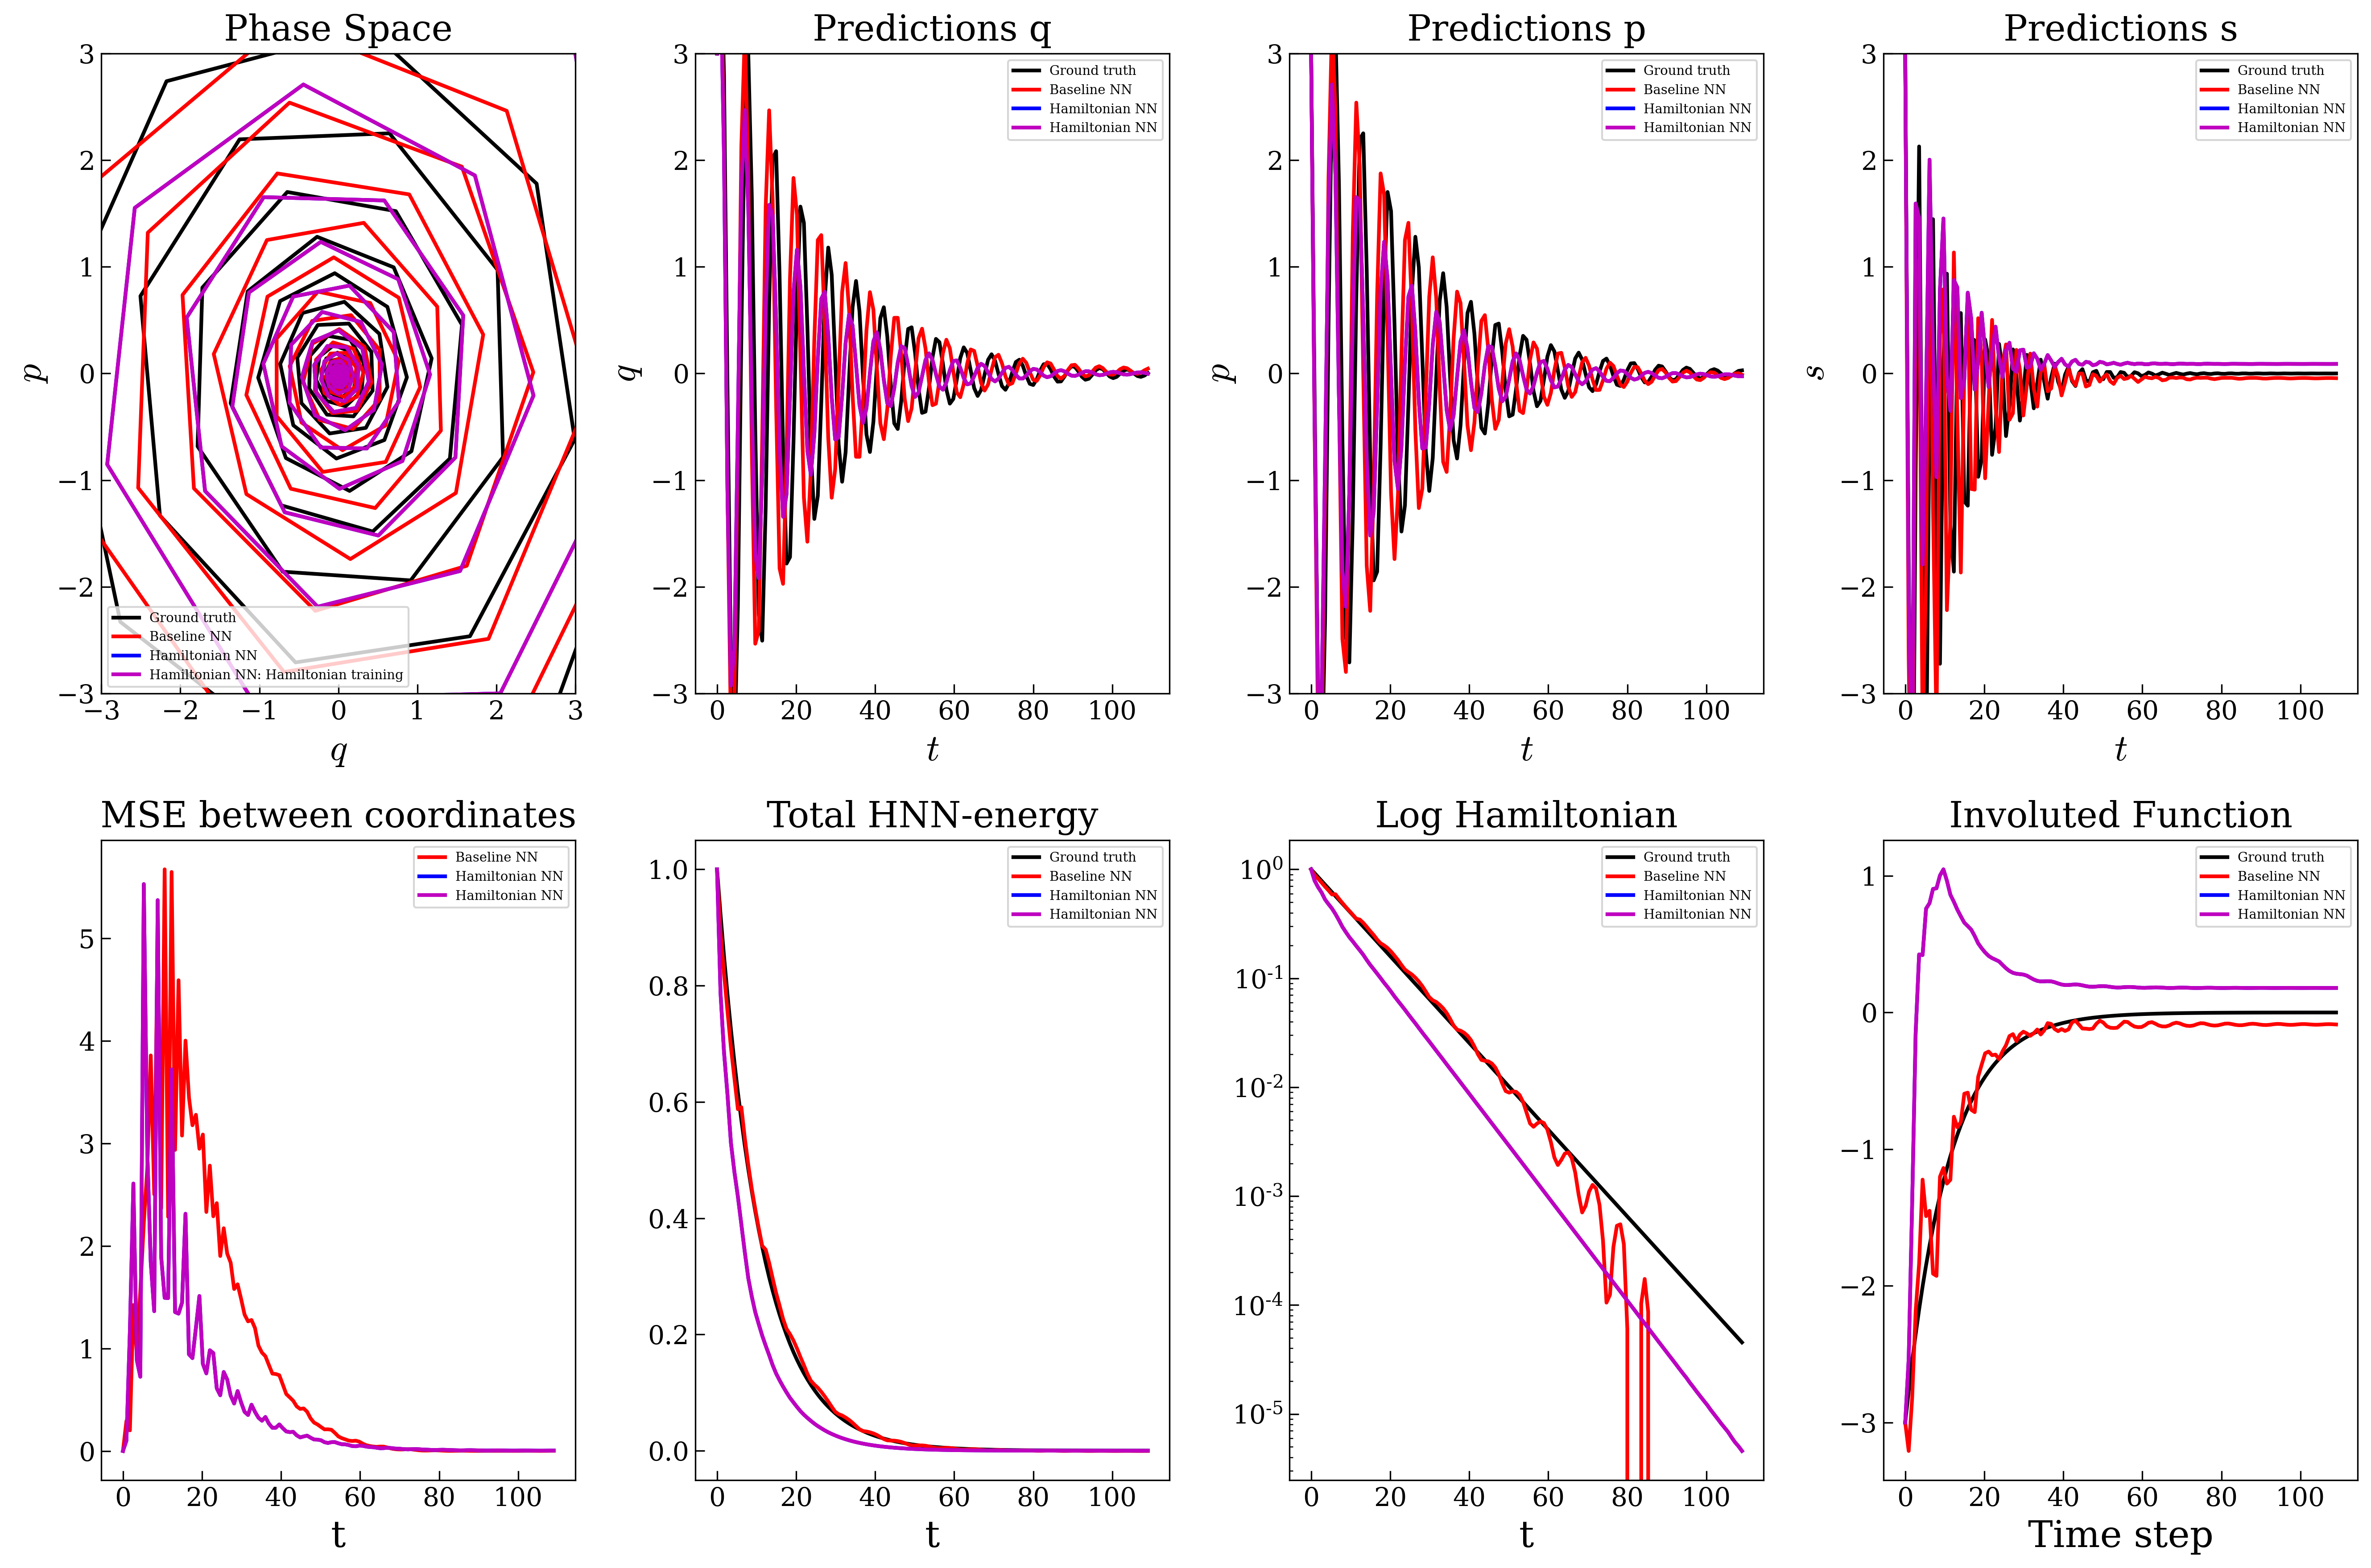

In [10]:
fig = plt.figure(figsize=[18,12], dpi=DPI)
t_span=[0,100]
ax1=plt.subplot(2,4,1)
ax2=plt.subplot(2,4,2)
ax3=plt.subplot(2,4,3)
ax4=plt.subplot(2,4,4)
ax5=plt.subplot(2,4,5)
ax6=plt.subplot(2,4,6)
ax7=plt.subplot(2,4,7)
ax8=plt.subplot(2,4,8)
spans = [125]
for sigma in spans:
    x0 = np.asarray([3., 3.,3.])
    t_eval = np.linspace(t_span[0], t_span[1], sigma)
    # integration
    true_x, base_x, hnn_x, hnn_x_ht= integrate_models(x0=x0, t_span=t_span, t_eval=t_eval)

    # plotting
    tpad = 7
    ax1.set_title("Phase Space", pad=tpad); ax1.set_xlabel('$q$') ; ax1.set_ylabel('$p$')
    ax1.plot(true_x[:,0], true_x[:,1], 'k-', label='Ground truth', linewidth=2)
    ax1.plot(base_x[:,0], base_x[:,1], 'r-', label='Baseline NN', linewidth=2)
    ax1.plot(hnn_x[:,0], hnn_x[:,1], 'b-', label='Hamiltonian NN', linewidth=2)
    ax1.plot(hnn_x_ht[:,0], hnn_x_ht[:,1], 'm-', label='Hamiltonian NN: Hamiltonian training', linewidth=2)
    ax1.set_xlim(-3,3) ; ax1.set_ylim(-3,3)
    ax1.legend(fontsize=7)

    ax2.set_title("Predictions q", pad=tpad) ; ax2.set_xlabel('$t$') ; ax2.set_ylabel('$q$')
    ax2.plot(t_eval, true_x[:,0], 'k-', label='Ground truth', linewidth=2)
    ax2.plot(t_eval, base_x[:,0], 'r-', label='Baseline NN', linewidth=2)
    ax2.plot(t_eval, hnn_x[:,0], 'b-', label='Hamiltonian NN', linewidth=2)
    ax2.plot(t_eval, hnn_x_ht[:,0], 'm-', label='Hamiltonian NN', linewidth=2)
    ax2.set_ylim(-3,3)
    ax2.legend(fontsize=7)  
    
    ax3.set_title("Predictions p", pad=tpad) ; ax3.set_xlabel('$t$') ; ax3.set_ylabel('$p$')
    ax3.plot(t_eval, true_x[:,1], 'k-', label='Ground truth', linewidth=2)
    ax3.plot(t_eval, base_x[:,1], 'r-', label='Baseline NN', linewidth=2)
    ax3.plot(t_eval, hnn_x[:,1], 'b-', label='Hamiltonian NN', linewidth=2)
    ax3.plot(t_eval, hnn_x_ht[:,1], 'm-', label='Hamiltonian NN', linewidth=2)
    ax3.set_ylim(-3,3)
    ax3.legend(fontsize=7)
    
    ax4.set_title("Predictions s", pad=tpad) ; ax4.set_xlabel('$t$') ; ax4.set_ylabel('$s$')
    ax4.plot(t_eval, true_x[:,2], 'k-', label='Ground truth', linewidth=2)
    ax4.plot(t_eval, base_x[:,2], 'r-', label='Baseline NN', linewidth=2)
    ax4.plot(t_eval, hnn_x[:,2], 'b-', label='Hamiltonian NN', linewidth=2)
    ax4.plot(t_eval, hnn_x_ht[:,2], 'm-', label='Hamiltonian NN', linewidth=2)
    ax4.set_ylim(-3,3)
    ax4.legend(fontsize=7)
    
    ax5.set_title("MSE between coordinates", pad=tpad) ; ax5.set_xlabel('t')
    ax5.plot(t_eval, ((true_x-base_x)**2).mean(-1), 'r-', label='Baseline NN', linewidth=2)
    ax5.plot(t_eval, ((true_x-hnn_x)**2).mean(-1), 'b-', label='Hamiltonian NN', linewidth=2)
    ax5.plot(t_eval, ((true_x-hnn_x_ht)**2).mean(-1), 'm-', label='Hamiltonian NN', linewidth=2)
    ax5.legend(fontsize=7)

    ax6.set_title("Total HNN-energy", pad=tpad)
    ax6.set_xlabel('t')
    true_hq = np.stack([hamiltonian_fn(c) for c in true_x])
    base_hq = np.stack([hamiltonian_fn(c) for c in base_x])
    #base_hq = hnn_model(torch.Tensor(base_x))[1].detach().numpy().squeeze()
    hnn_hq = hnn_model(torch.Tensor(hnn_x))[1].detach().numpy().squeeze()
    hnn_hq_ht = hnn_model(torch.Tensor(hnn_x_ht))[1].detach().numpy().squeeze()
    ax6.plot(t_eval, true_hq/true_hq[0], 'k-', label='Ground truth', linewidth=2)
    ax6.plot(t_eval, base_hq/base_hq[0], 'r-', label='Baseline NN', linewidth=2)
    ax6.plot(t_eval, hnn_hq/hnn_hq[0], 'b-', label='Hamiltonian NN', linewidth=2)
    ax6.plot(t_eval, hnn_hq_ht/hnn_hq_ht[0], 'm-', label='Hamiltonian NN', linewidth=2)
    ax6.legend(fontsize=7)

    ax7.set_title("Log Hamiltonian", pad=tpad)
    ax7.set_xlabel('t')
    ax7.plot(t_eval, true_hq/true_hq[0], 'k-', label='Ground truth', linewidth=2)
    ax7.plot(t_eval, base_hq/base_hq[0], 'r-', label='Baseline NN', linewidth=2)
    ax7.plot(t_eval, hnn_hq/hnn_hq[0], 'b-', label='Hamiltonian NN', linewidth=2)
    ax7.plot(t_eval, hnn_hq_ht/hnn_hq_ht[0], 'm-', label='Hamiltonian NN', linewidth=2)
    ax7.set_yscale('log')
    ax7.legend(fontsize=7)
    
    ax8.set_title("Involuted Function", pad=tpad) ; ax8.set_xlabel('Time step')
    true_e = np.stack([k2_fn(c) for c in true_x])
    base_e = np.stack([k2_fn(c) for c in base_x])
    hnn_e = np.stack([k2_fn(c) for c in hnn_x])
    hnn_e_ht = np.stack([k2_fn(c) for c in hnn_x_ht])
    ax8.plot(t_eval, true_e, 'k-', label='Ground truth', linewidth=2)
    ax8.plot(t_eval, base_e, 'r-', label='Baseline NN', linewidth=2)
    ax8.plot(t_eval, hnn_e, 'b-', label='Hamiltonian NN', linewidth=2)
    ax8.plot(t_eval, hnn_e_ht, 'm-', label='Hamiltonian NN', linewidth=2)
    #ax8.set_ylim(-5,-2.5)
    ax8.legend(fontsize=7)

plt.tight_layout()
plt.show()
#fig.savefig('{}/spring-integration{}.{}'.format(args.fig_dir, RK4, FORMAT))

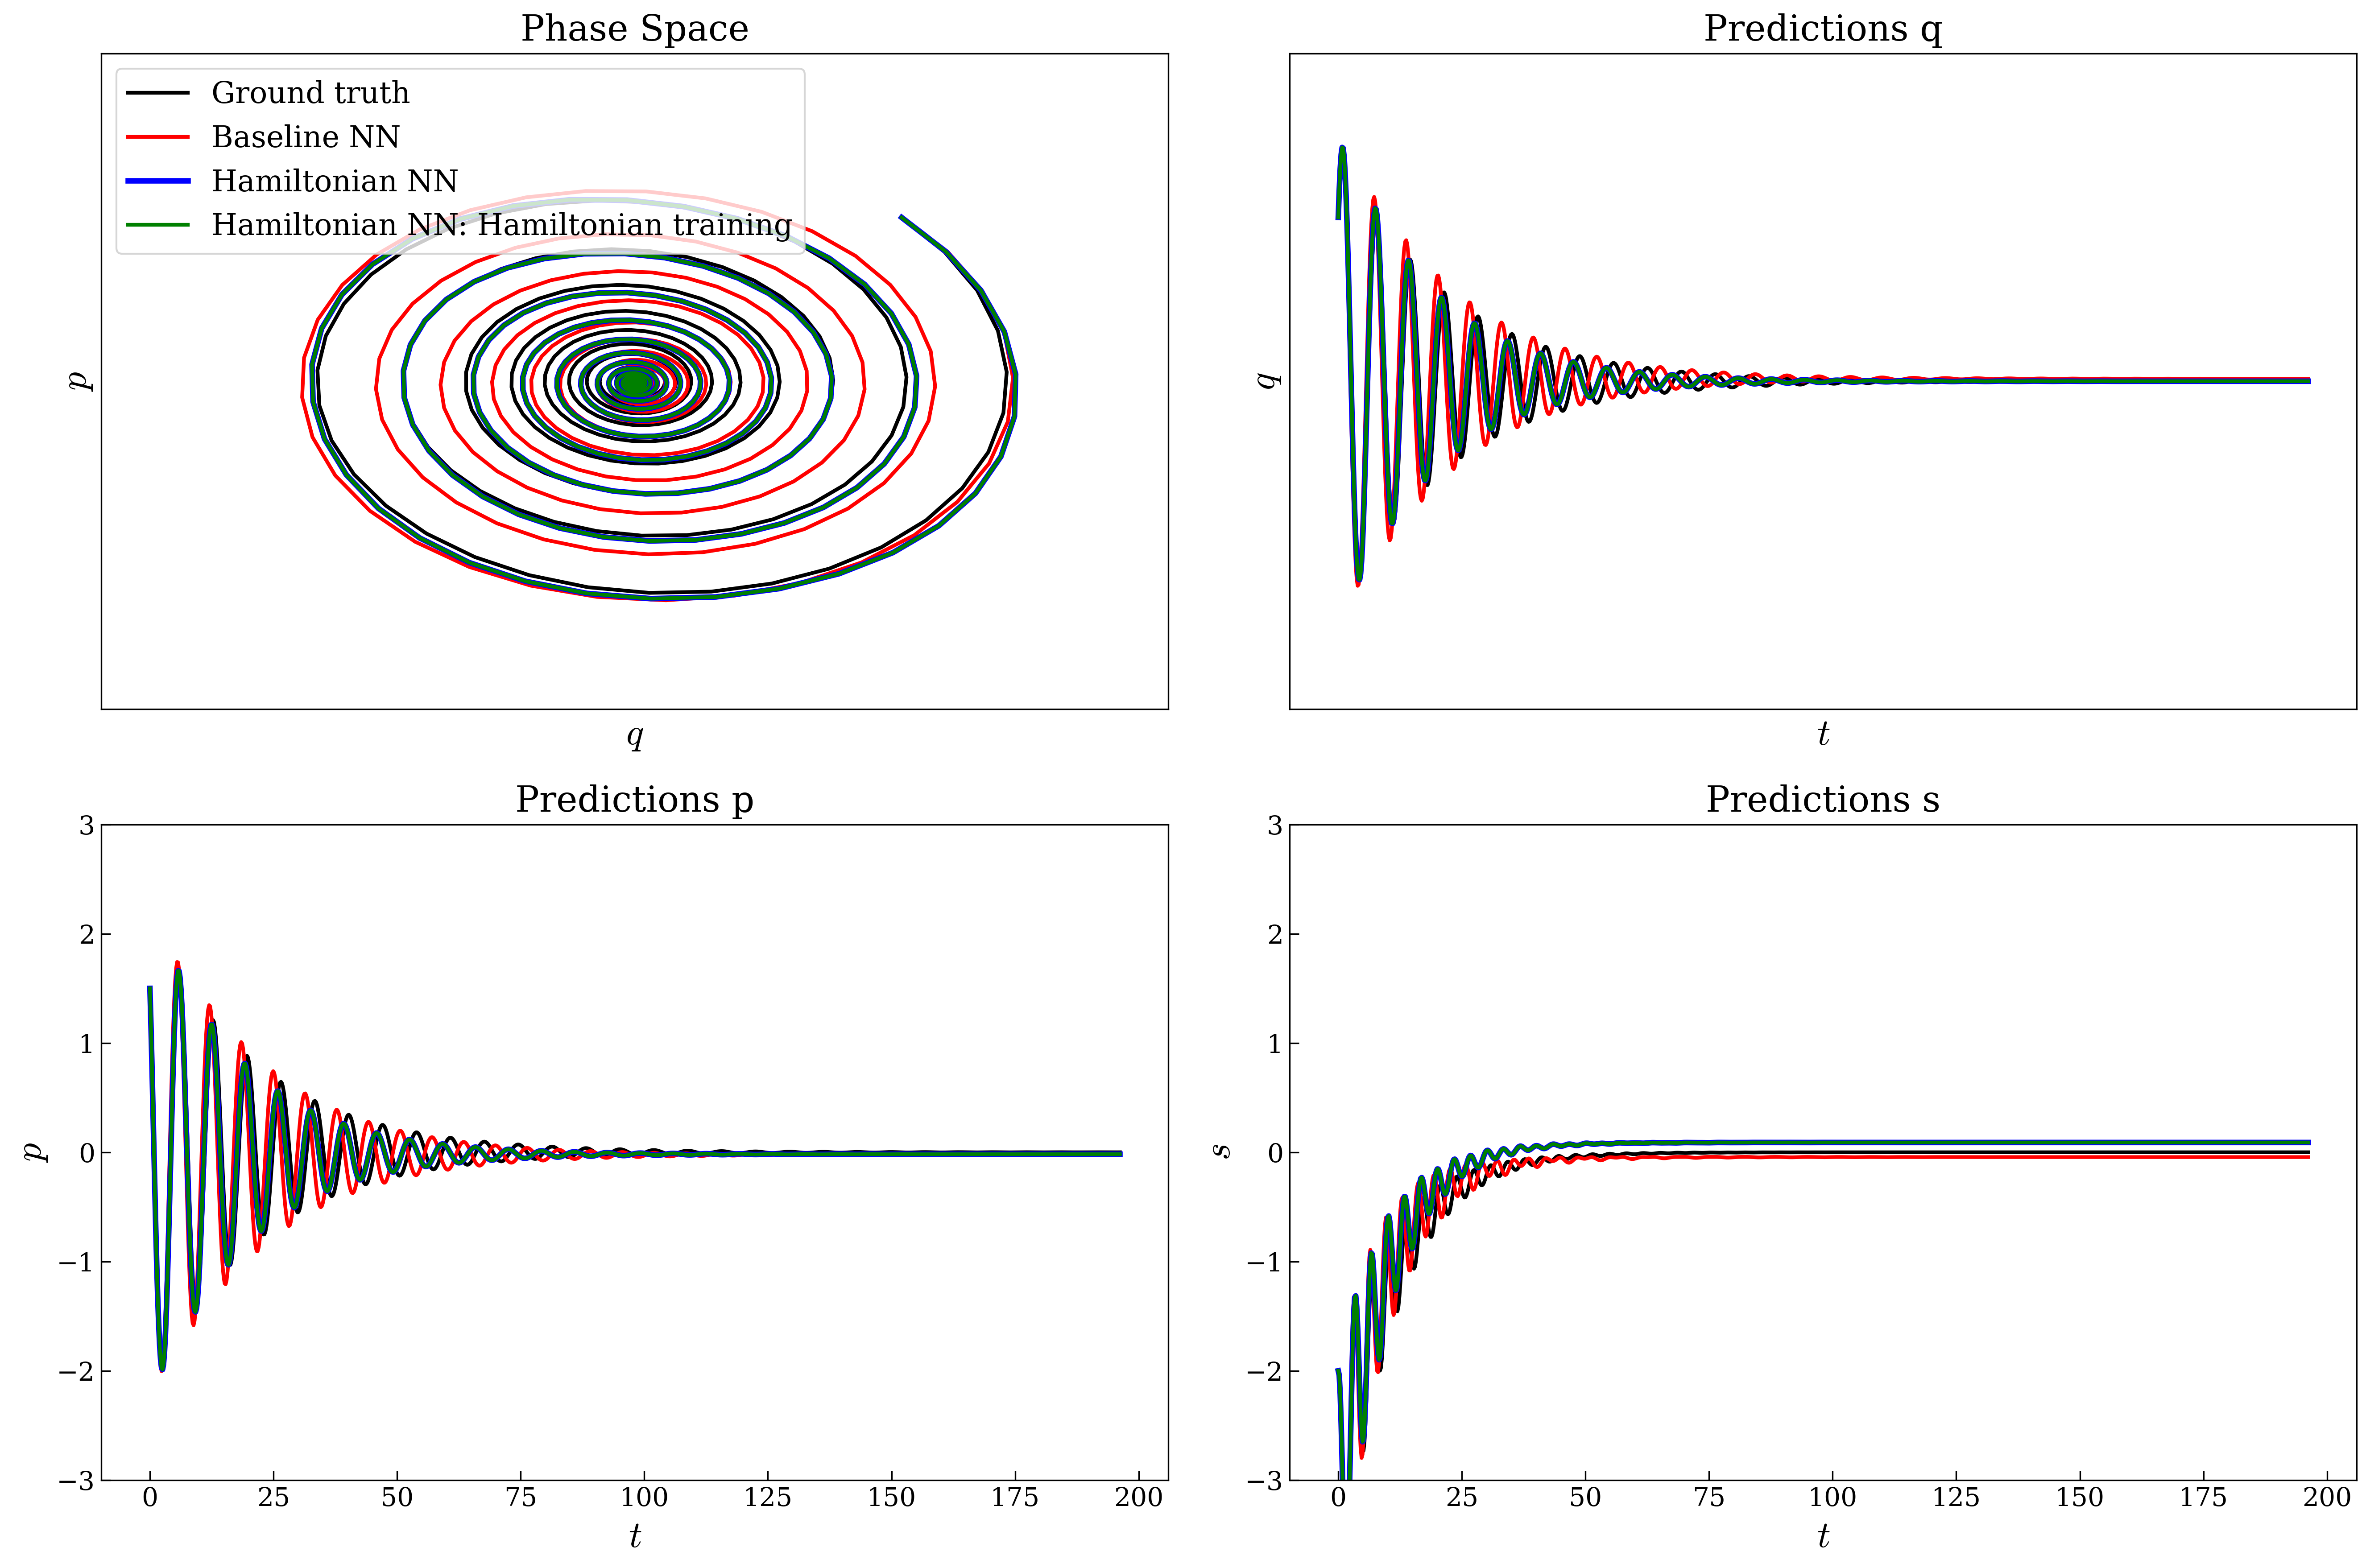

In [11]:
fig = plt.figure(figsize=[18,12], dpi=DPI)

# Set up the axes for the plots
ax1 = plt.subplot(2, 2, 1)
ax2 = plt.subplot(2, 2, 2)
ax3 = plt.subplot(2, 2, 3)
ax4 = plt.subplot(2, 2, 4)

# Remove ticks and labels for the first 2 blank plots
ax1.set_xticks([])
ax1.set_yticks([])
ax2.set_xticks([])
ax2.set_yticks([])

spans = [125]
for sigma in spans:
    x0 = np.asarray([1.5, 1.5, -2.])
    t_eval = np.linspace(0., 180., 1000)
    t_span = [0., 1000.]
    # integration
    true_x, base_x, hnn_x, hnn_x_ht= integrate_models(x0=x0, t_span=t_span, t_eval=t_eval)
    ax1.set_title("Phase Space", pad=tpad); ax1.set_xlabel('$q$') ; ax1.set_ylabel('$p$')
    ax1.plot(true_x[:,0], true_x[:,1], 'k-', label='Ground truth', linewidth=2)
    ax1.plot(base_x[:,0], base_x[:,1], 'r-', label='Baseline NN', linewidth=2)
    ax1.plot(hnn_x[:,0], hnn_x[:,1], 'b-', label='Hamiltonian NN', linewidth=3)
    ax1.plot(hnn_x_ht[:,0], hnn_x_ht[:,1], 'g-', label='Hamiltonian NN: Hamiltonian training', linewidth=2)
    ax1.set_xlim(-3,3) ; ax1.set_ylim(-3,3)
    ax1.legend(fontsize=16)

    ax2.set_title("Predictions q", pad=tpad) ; ax2.set_xlabel('$t$') ; ax2.set_ylabel('$q$')
    ax2.plot(t_eval, true_x[:,0], 'k-', label='Ground truth', linewidth=2)
    ax2.plot(t_eval, base_x[:,0], 'r-', label='Baseline NN', linewidth=2)
    ax2.plot(t_eval, hnn_x[:,0], 'b-', label='Hamiltonian NN', linewidth=3)
    ax2.plot(t_eval, hnn_x_ht[:,0], 'g-', label='Hamiltonian NN', linewidth=2)
    ax2.set_ylim(-3,3)
    #ax2.legend(fontsize=16) 
    # plotting
    tpad = 7
    ax3.set_title("Predictions p", pad=tpad)
    ax3.set_xlabel('$t$')
    ax3.set_ylabel('$p$')
    ax3.plot(t_eval, true_x[:,1], 'k-', label='Ground truth', linewidth=2)
    ax3.plot(t_eval, base_x[:,1], 'r-', label='Baseline NN', linewidth=2)
    ax3.plot(t_eval, hnn_x[:,1], 'b-', label='Hamiltonian NN', linewidth=3)
    ax3.plot(t_eval, hnn_x_ht[:,1], 'g-', label='Hamiltonian NN', linewidth=2)
    ax3.set_ylim(-3,3)
    #ax3.legend(fontsize=16)

    ax4.set_title("Predictions s", pad=tpad)
    ax4.set_xlabel('$t$')
    ax4.set_ylabel('$s$')
    ax4.plot(t_eval, true_x[:,2], 'k-', label='Ground truth', linewidth=2)
    ax4.plot(t_eval, base_x[:,2], 'r-', label='Baseline NN', linewidth=2)
    ax4.plot(t_eval, hnn_x[:,2], 'b-', label='Hamiltonian NN', linewidth=3)
    ax4.plot(t_eval, hnn_x_ht[:,2], 'g-', label='Hamiltonian NN', linewidth=2)
    ax4.set_ylim(-3,3)
    #ax4.legend(fontsize=16)

    # Update the tight layout of the figure
fig.tight_layout()
plt.show()
fig.savefig('{}/spring-integration2x2{}.{}'.format(args.fig_dir, RK4, FORMAT))

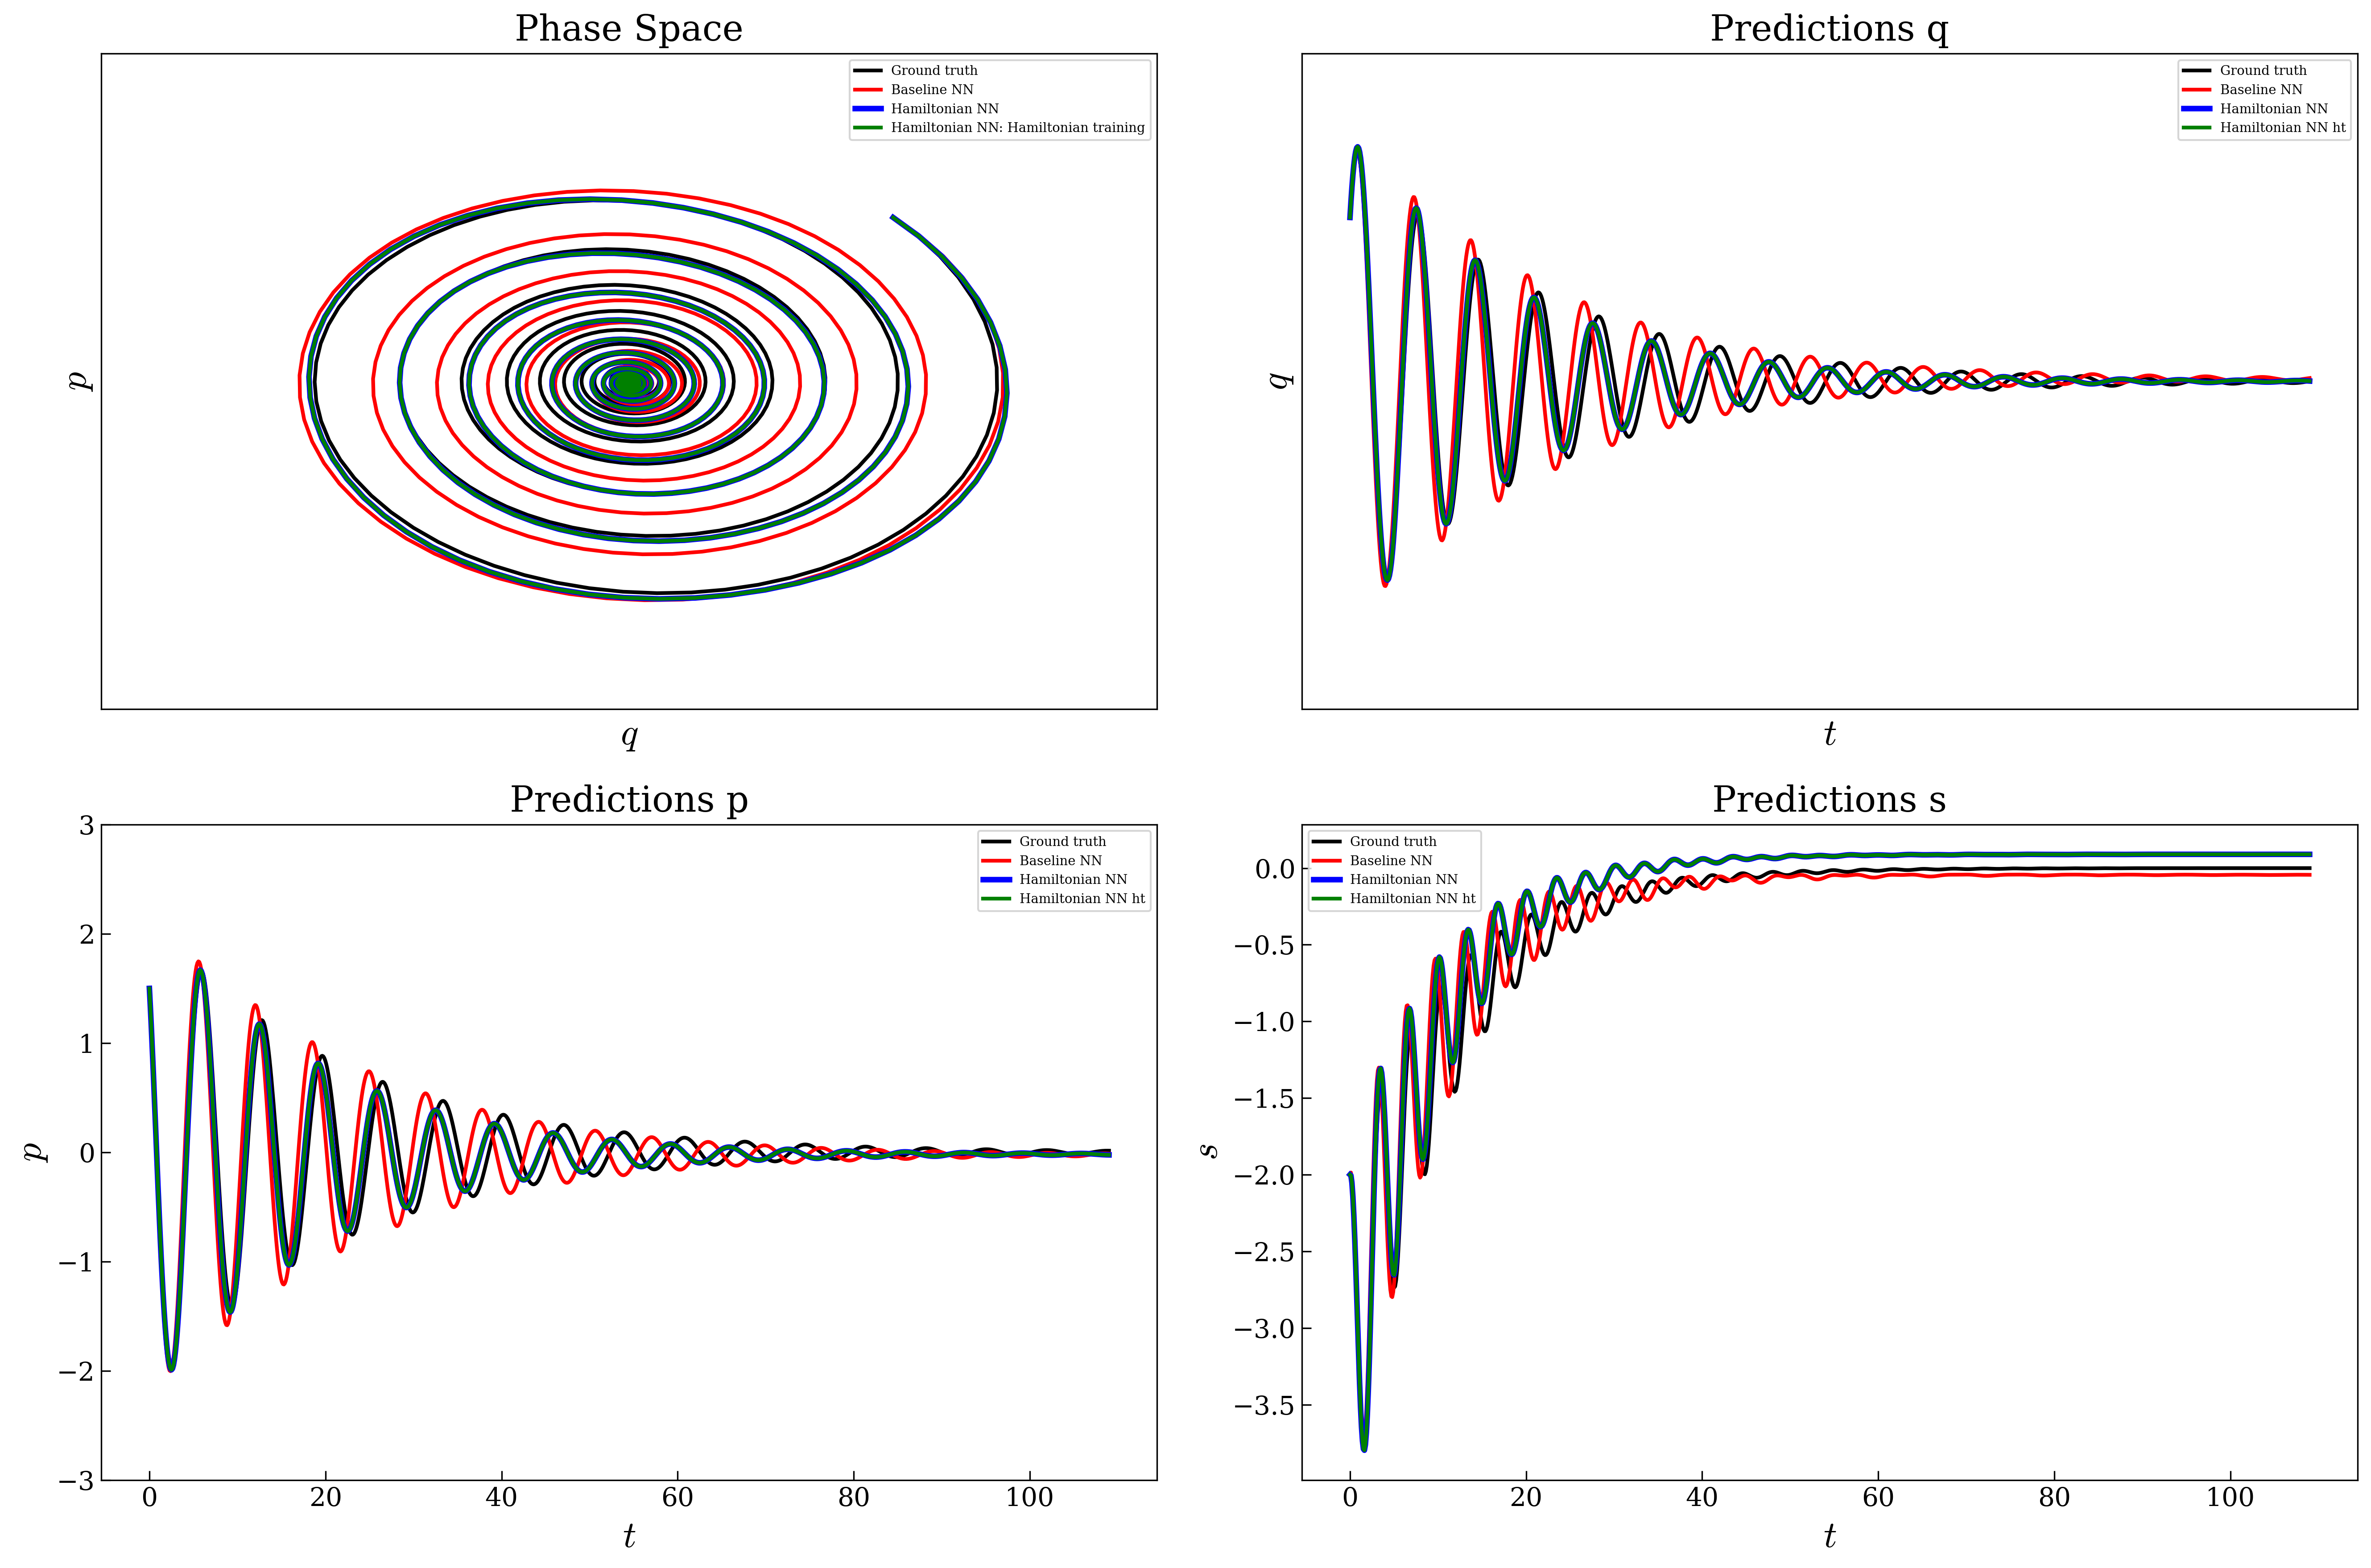

In [23]:
fig = plt.figure(figsize=[18,12], dpi=DPI)

# Set up the axes for the plots
ax1 = plt.subplot(2, 2, 1)
ax2 = plt.subplot(2, 2, 2)
ax3 = plt.subplot(2, 2, 3)
ax4 = plt.subplot(2, 2, 4)

# Remove ticks and labels for the first 2 blank plots
ax1.set_xticks([])
ax1.set_yticks([])
ax2.set_xticks([])
ax2.set_yticks([])

spans = [125]
for sigma in spans:
    x0 = np.asarray([1.5, 1.5, -2.])
    t_eval = np.linspace(0., 100., 1000)

    # integration
    true_x, base_x, hnn_x, hnn_x_ht= integrate_models(x0=x0, t_span=t_span, t_eval=t_eval)
    ax1.set_title("Phase Space", pad=tpad); ax1.set_xlabel('$q$') ; ax1.set_ylabel('$p$')
    ax1.plot(true_x[:,0], true_x[:,1], 'k-', label='Ground truth', linewidth=2)
    ax1.plot(base_x[:,0], base_x[:,1], 'r-', label='Baseline NN', linewidth=2)
    ax1.plot(hnn_x[:,0], hnn_x[:,1], 'b-', label='Hamiltonian NN', linewidth=3)
    ax1.plot(hnn_x_ht[:,0], hnn_x_ht[:,1], 'g-', label='Hamiltonian NN: Hamiltonian training', linewidth=2)
    ax1.set_xlim(-3,3) ; ax1.set_ylim(-3,3)
    ax1.legend(fontsize=7)

    ax2.set_title("Predictions q", pad=tpad) ; ax2.set_xlabel('$t$') ; ax2.set_ylabel('$q$')
    ax2.plot(t_eval, true_x[:,0], 'k-', label='Ground truth', linewidth=2)
    ax2.plot(t_eval, base_x[:,0], 'r-', label='Baseline NN', linewidth=2)
    ax2.plot(t_eval, hnn_x[:,0], 'b-', label='Hamiltonian NN', linewidth=3)
    ax2.plot(t_eval, hnn_x_ht[:,0], 'g-', label='Hamiltonian NN ht', linewidth=2)
    ax2.set_ylim(-3,3)
    ax2.legend(fontsize=7) 
    # plotting
    tpad = 7
    ax3.set_title("Predictions p", pad=tpad)
    ax3.set_xlabel('$t$')
    ax3.set_ylabel('$p$')
    ax3.plot(t_eval, true_x[:,1], 'k-', label='Ground truth', linewidth=2)
    ax3.plot(t_eval, base_x[:,1], 'r-', label='Baseline NN', linewidth=2)
    ax3.plot(t_eval, hnn_x[:,1], 'b-', label='Hamiltonian NN', linewidth=3)
    ax3.plot(t_eval, hnn_x_ht[:,1], 'g-', label='Hamiltonian NN ht', linewidth=2)
    ax3.set_ylim(-3,3)
    ax3.legend(fontsize=7)

    ax4.set_title("Predictions s", pad=tpad)
    ax4.set_xlabel('$t$')
    ax4.set_ylabel('$s$')
    ax4.plot(t_eval, true_x[:,2], 'k-', label='Ground truth', linewidth=2)
    ax4.plot(t_eval, base_x[:,2], 'r-', label='Baseline NN', linewidth=2)
    ax4.plot(t_eval, hnn_x[:,2], 'b-', label='Hamiltonian NN', linewidth=3)
    ax4.plot(t_eval, hnn_x_ht[:,2], 'g-', label='Hamiltonian NN ht', linewidth=2)
    #ax4.set_ylim(-3,3)
    ax4.legend(fontsize=7)

    # Update the tight layout of the figure
fig.tight_layout()
plt.show()

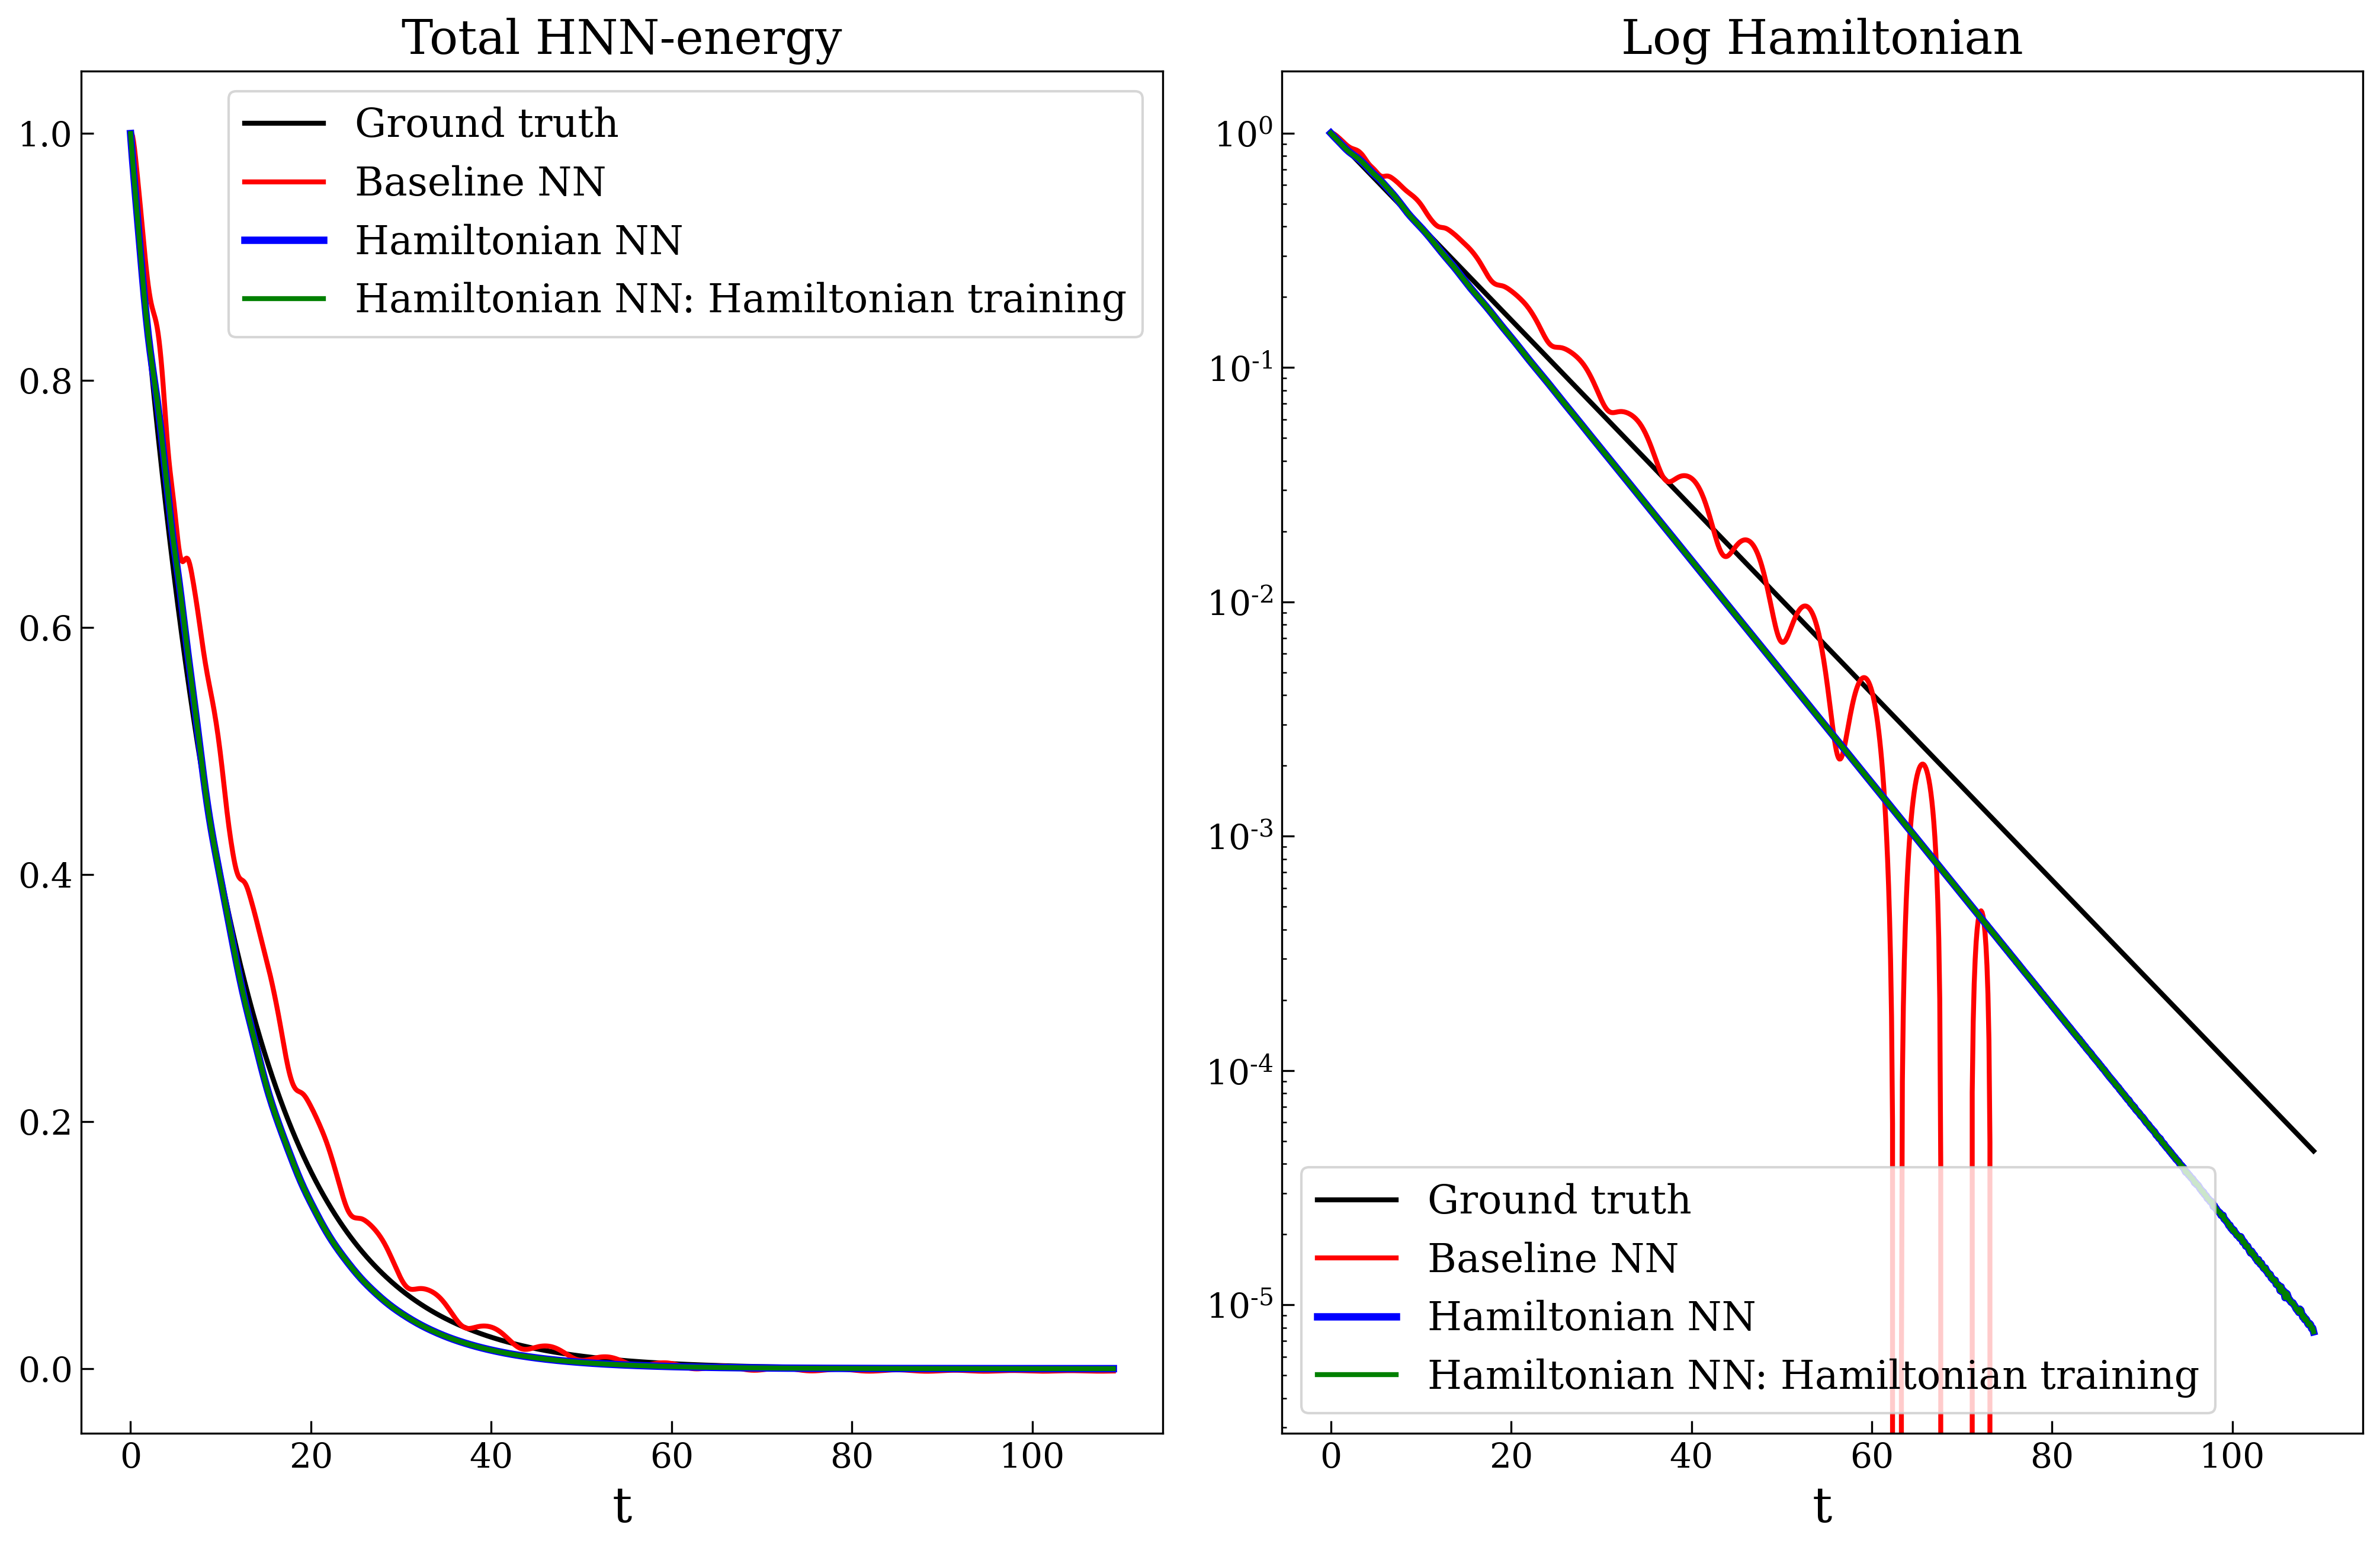

In [27]:
fig = plt.figure(figsize=[14,9], dpi=DPI)
t_span=[0,100]
#ax5=plt.subplot(2,1,1)
ax6=plt.subplot(1,2,1)
ax7=plt.subplot(1,2,2)
#ax8=plt.subplot(2,1,4)

spans = [125]
for sigma in spans:
    #x0 = np.asarray([1.5, 1.5,-2.])
    #t_eval = np.linspace(t_span[0], t_span[1], sigma)
    # integration
    #true_x, base_x, hnn_x, hnn_x_ht= integrate_models(x0=x0, t_span=t_span, t_eval=t_eval)

    # plotting
    tpad = 7
    
    #ax5.set_title("MSE between coordinates", pad=tpad) ; ax5.set_xlabel('t')
    #ax5.plot(t_eval, ((true_x-base_x)**2).mean(-1), 'r-', label='Baseline NN', linewidth=2)
    #ax5.plot(t_eval, ((true_x-hnn_x)**2).mean(-1), 'b-', label='Hamiltonian NN', linewidth=3)
    #ax5.plot(t_eval, ((true_x-hnn_x_ht)**2).mean(-1), 'g-', label='Hamiltonian NN', linewidth=2)
    #ax5.legend(fontsize=7)

    ax6.set_title("Total HNN-energy", pad=tpad)
    ax6.set_xlabel('t')
    true_hq = np.stack([hamiltonian_fn(c) for c in true_x])
    base_hq = np.stack([hamiltonian_fn(c) for c in base_x])
    #base_hq = hnn_model(torch.Tensor(base_x))[1].detach().numpy().squeeze()
    hnn_hq = hnn_model(torch.Tensor(hnn_x))[1].detach().numpy().squeeze()
    hnn_hq_ht = hnn_model(torch.Tensor(hnn_x_ht))[1].detach().numpy().squeeze()
    ax6.plot(t_eval, true_hq/true_hq[0], 'k-', label='Ground truth', linewidth=2)
    ax6.plot(t_eval, base_hq/base_hq[0], 'r-', label='Baseline NN', linewidth=2)
    ax6.plot(t_eval, hnn_hq/hnn_hq[0], 'b-', label='Hamiltonian NN', linewidth=3)
    ax6.plot(t_eval, hnn_hq_ht/hnn_hq_ht[0], 'g-', label='Hamiltonian NN: Hamiltonian training', linewidth=2)
    ax6.legend(fontsize=16)

    ax7.set_title("Log Hamiltonian", pad=tpad)
    ax7.set_xlabel('t')
    ax7.plot(t_eval, true_hq/true_hq[0], 'k-', label='Ground truth', linewidth=2)
    ax7.plot(t_eval, base_hq/base_hq[0], 'r-', label='Baseline NN', linewidth=2)
    ax7.plot(t_eval, hnn_hq/hnn_hq[0], 'b-', label='Hamiltonian NN', linewidth=3)
    ax7.plot(t_eval, hnn_hq_ht/hnn_hq_ht[0], 'g-', label='Hamiltonian NN: Hamiltonian training', linewidth=2)
    ax7.set_yscale('log')
    ax7.legend(fontsize=16)

    
    #ax8.set_title("Involuted Function", pad=tpad) ; ax8.set_xlabel('Time step')
    #true_e = np.stack([kofmotion(c) for c in true_x])
    #base_e = np.stack([kofmotion(c) for c in base_x])
    #hnn_e = np.stack([k2_fn(c)/hnn_model(torch.Tensor([c]))[1].detach().numpy().squeeze() for c in hnn_x])
    #hnn_e_ht = np.stack([k2_fn(c)/hnn_model_ht(torch.Tensor([c]))[1].detach().numpy().squeeze() for c in hnn_x_ht])
    #ax8.plot(t_eval, true_e, 'k-', label='Ground truth', linewidth=2)
    #ax8.plot(t_eval, base_e, 'r-', label='Baseline NN', linewidth=2)
    #ax8.plot(t_eval, hnn_e, 'b-', label='Hamiltonian NN', linewidth=3)
    #ax8.plot(t_eval, hnn_e_ht, 'g-', label='Hamiltonian NN', linewidth=2)
    #ax8.set_ylim(-5,5)
    #ax8.legend(fontsize=7)

plt.tight_layout()
plt.show()

In [28]:
fig.savefig('{}/spring-integrationen{}.{}'.format(args.fig_dir, RK4, FORMAT))

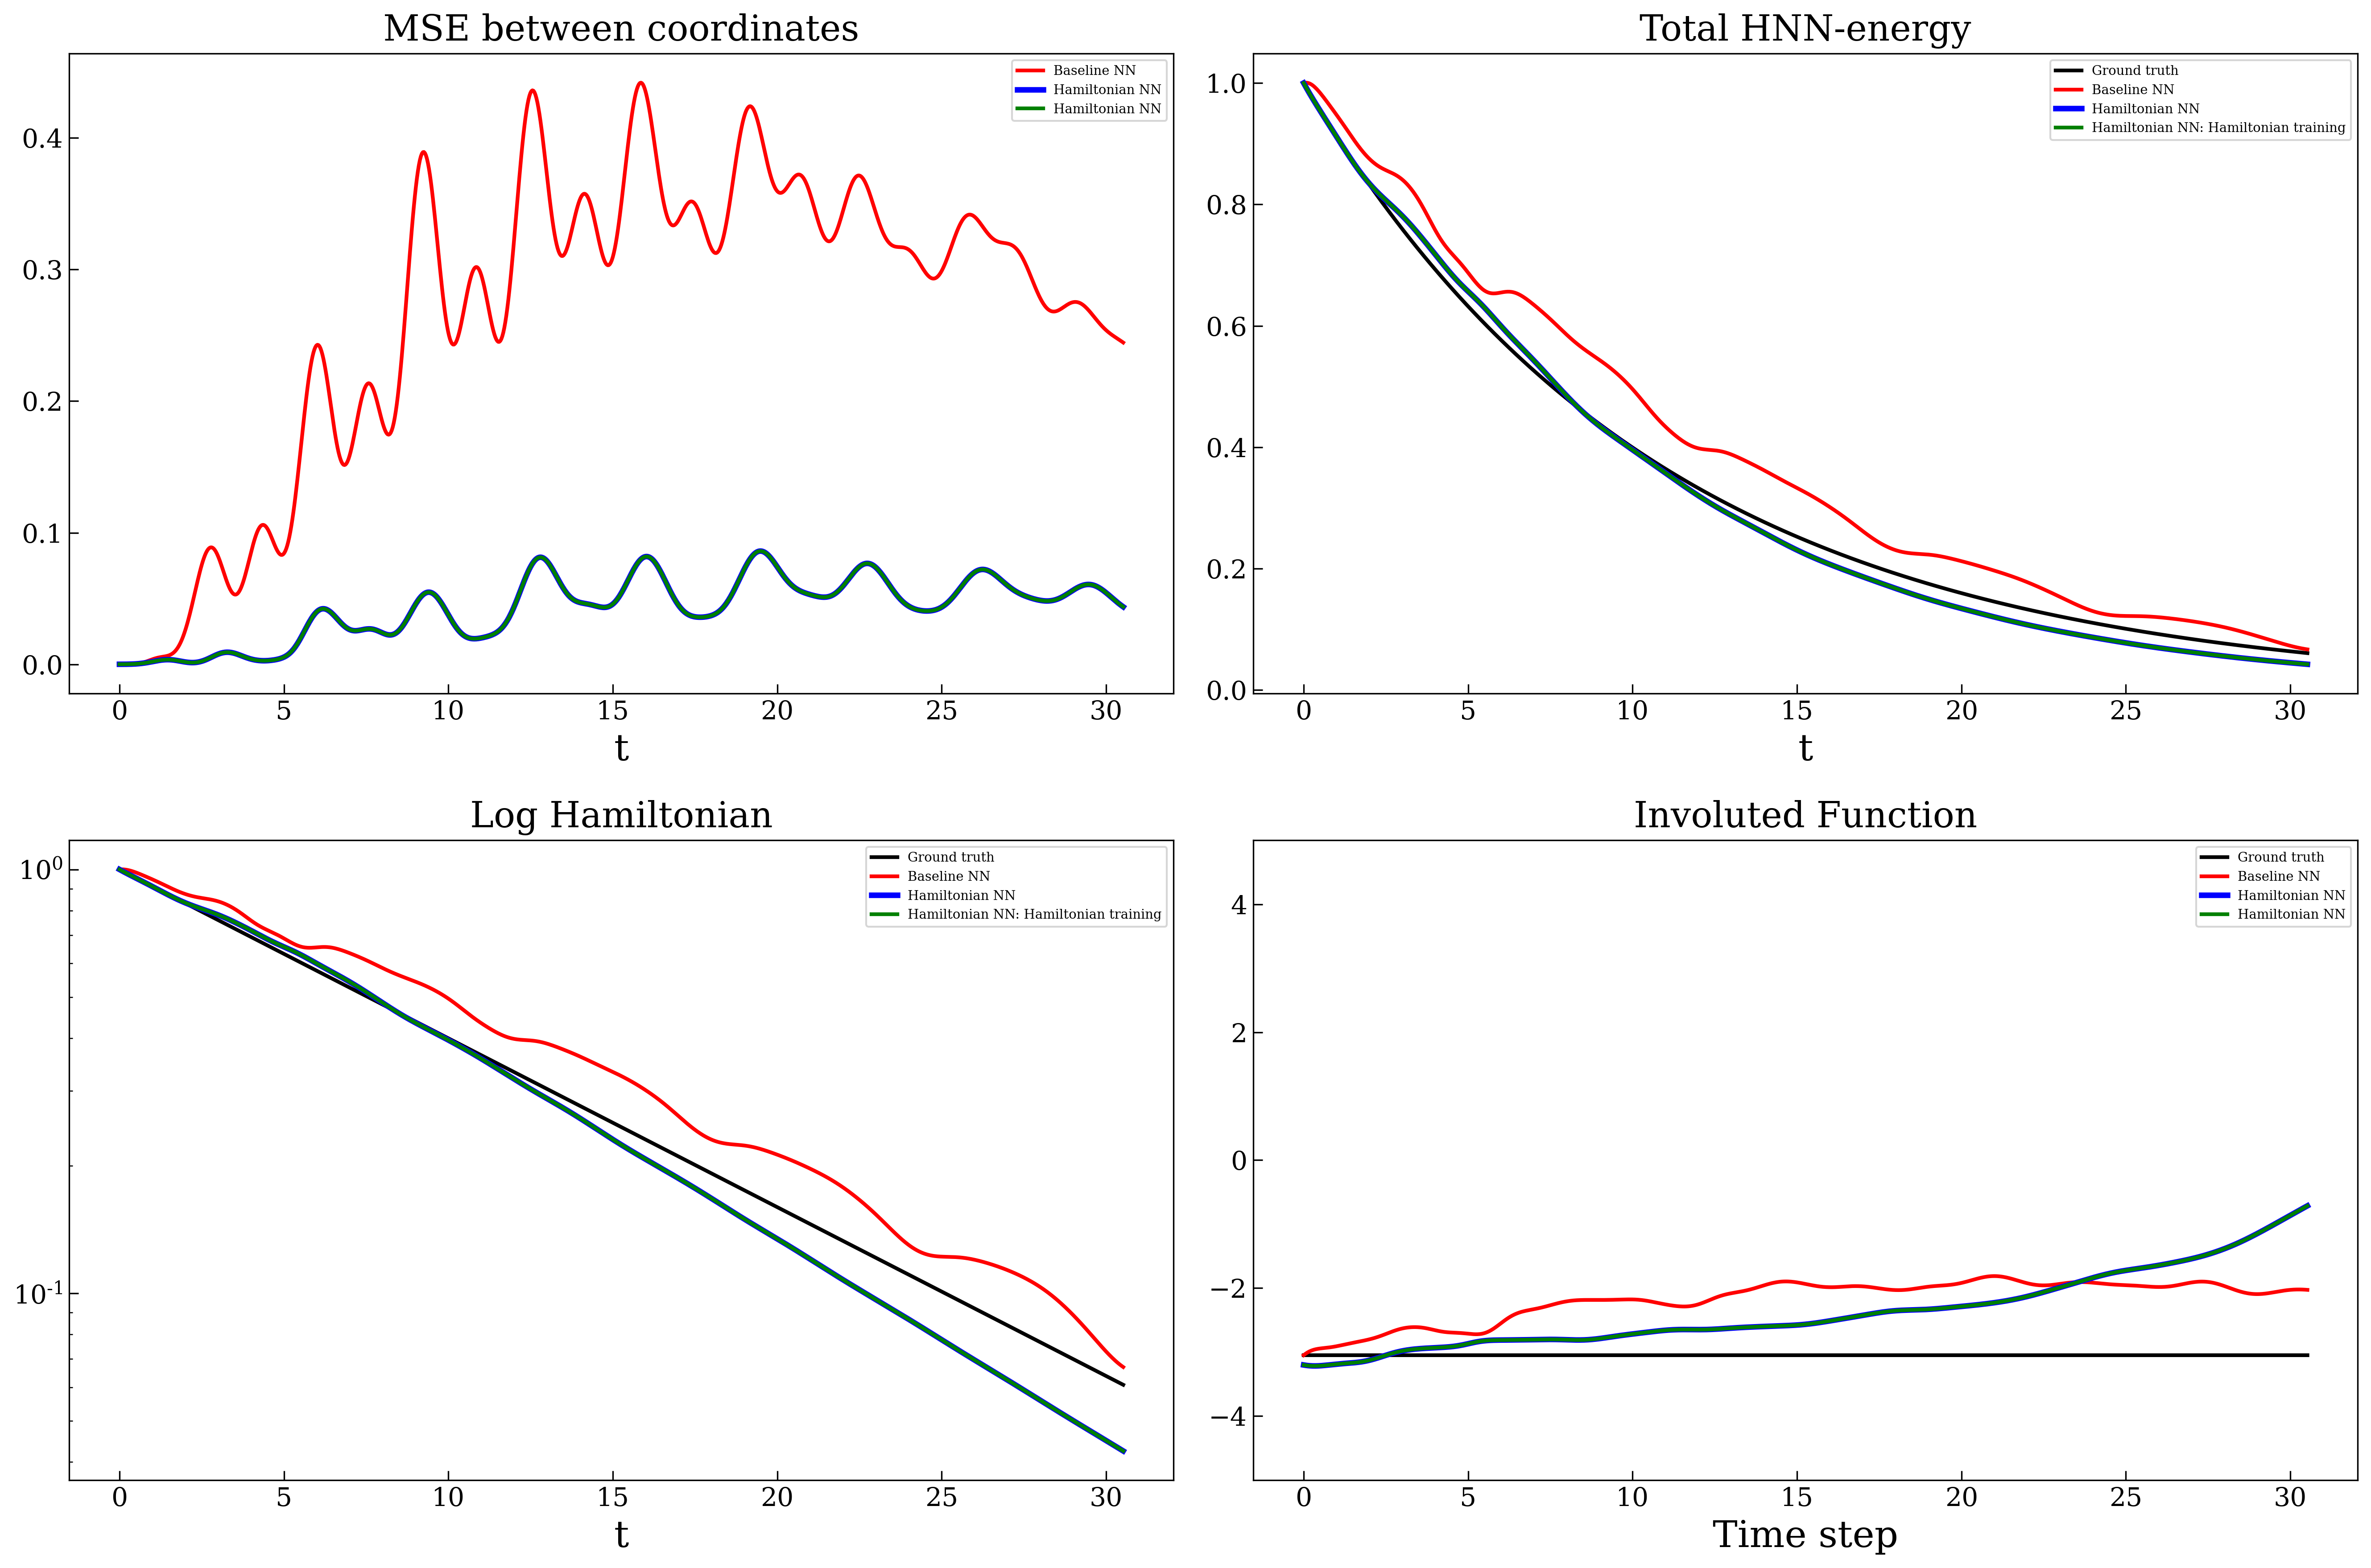

In [15]:
fig = plt.figure(figsize=[18,12], dpi=DPI)
#t_span=[0,100]
ax5=plt.subplot(2,2,1)
ax6=plt.subplot(2,2,2)
ax7=plt.subplot(2,2,3)
ax8=plt.subplot(2,2,4)

spans = [125]
for sigma in spans:
    #x0 = np.asarray([1.5, 1.5,-2.])
    #t_eval = np.linspace(t_span[0], t_span[1], sigma)
    # integration
    #true_x, base_x, hnn_x, hnn_x_ht= integrate_models(x0=x0, t_span=t_span, t_eval=t_eval)

    # plotting
    tpad = 7
    
    ax5.set_title("MSE between coordinates", pad=tpad) ; ax5.set_xlabel('t')
    ax5.plot(t_eval, ((true_x-base_x)**2).mean(-1), 'r-', label='Baseline NN', linewidth=2)
    ax5.plot(t_eval, ((true_x-hnn_x)**2).mean(-1), 'b-', label='Hamiltonian NN', linewidth=3)
    ax5.plot(t_eval, ((true_x-hnn_x_ht)**2).mean(-1), 'g-', label='Hamiltonian NN', linewidth=2)
    ax5.legend(fontsize=7)

    ax6.set_title("Total HNN-energy", pad=tpad)
    ax6.set_xlabel('t')
    true_hq = np.stack([hamiltonian_fn(c) for c in true_x])
    base_hq = np.stack([hamiltonian_fn(c) for c in base_x])
    #base_hq = hnn_model(torch.Tensor(base_x))[1].detach().numpy().squeeze()
    hnn_hq = hnn_model(torch.Tensor(hnn_x))[1].detach().numpy().squeeze()
    hnn_hq_ht = hnn_model(torch.Tensor(hnn_x_ht))[1].detach().numpy().squeeze()
    ax6.plot(t_eval, true_hq/true_hq[0], 'k-', label='Ground truth', linewidth=2)
    ax6.plot(t_eval, base_hq/base_hq[0], 'r-', label='Baseline NN', linewidth=2)
    ax6.plot(t_eval, hnn_hq/hnn_hq[0], 'b-', label='Hamiltonian NN', linewidth=3)
    ax6.plot(t_eval, hnn_hq_ht/hnn_hq_ht[0], 'g-', label='Hamiltonian NN: Hamiltonian training', linewidth=2)
    ax6.legend(fontsize=7)

    ax7.set_title("Log Hamiltonian", pad=tpad)
    ax7.set_xlabel('t')
    ax7.plot(t_eval, true_hq/true_hq[0], 'k-', label='Ground truth', linewidth=2)
    ax7.plot(t_eval, base_hq/base_hq[0], 'r-', label='Baseline NN', linewidth=2)
    ax7.plot(t_eval, hnn_hq/hnn_hq[0], 'b-', label='Hamiltonian NN', linewidth=3)
    ax7.plot(t_eval, hnn_hq_ht/hnn_hq_ht[0], 'g-', label='Hamiltonian NN: Hamiltonian training', linewidth=2)
    ax7.set_yscale('log')
    ax7.legend(fontsize=7)

    
    ax8.set_title("Involuted Function", pad=tpad) ; ax8.set_xlabel('Time step')
    true_e = np.stack([kofmotion(c) for c in true_x])
    base_e = np.stack([kofmotion(c) for c in base_x])
    hnn_e = np.stack([k2_fn(c)/hnn_model(torch.Tensor([c]))[1].detach().numpy().squeeze() for c in hnn_x])
    hnn_e_ht = np.stack([k2_fn(c)/hnn_model_ht(torch.Tensor([c]))[1].detach().numpy().squeeze() for c in hnn_x_ht])
    ax8.plot(t_eval, true_e, 'k-', label='Ground truth', linewidth=2)
    ax8.plot(t_eval, base_e, 'r-', label='Baseline NN', linewidth=2)
    ax8.plot(t_eval, hnn_e, 'b-', label='Hamiltonian NN', linewidth=3)
    ax8.plot(t_eval, hnn_e_ht, 'g-', label='Hamiltonian NN', linewidth=2)
    ax8.set_ylim(-5,5)
    ax8.legend(fontsize=7)

plt.tight_layout()
plt.show()

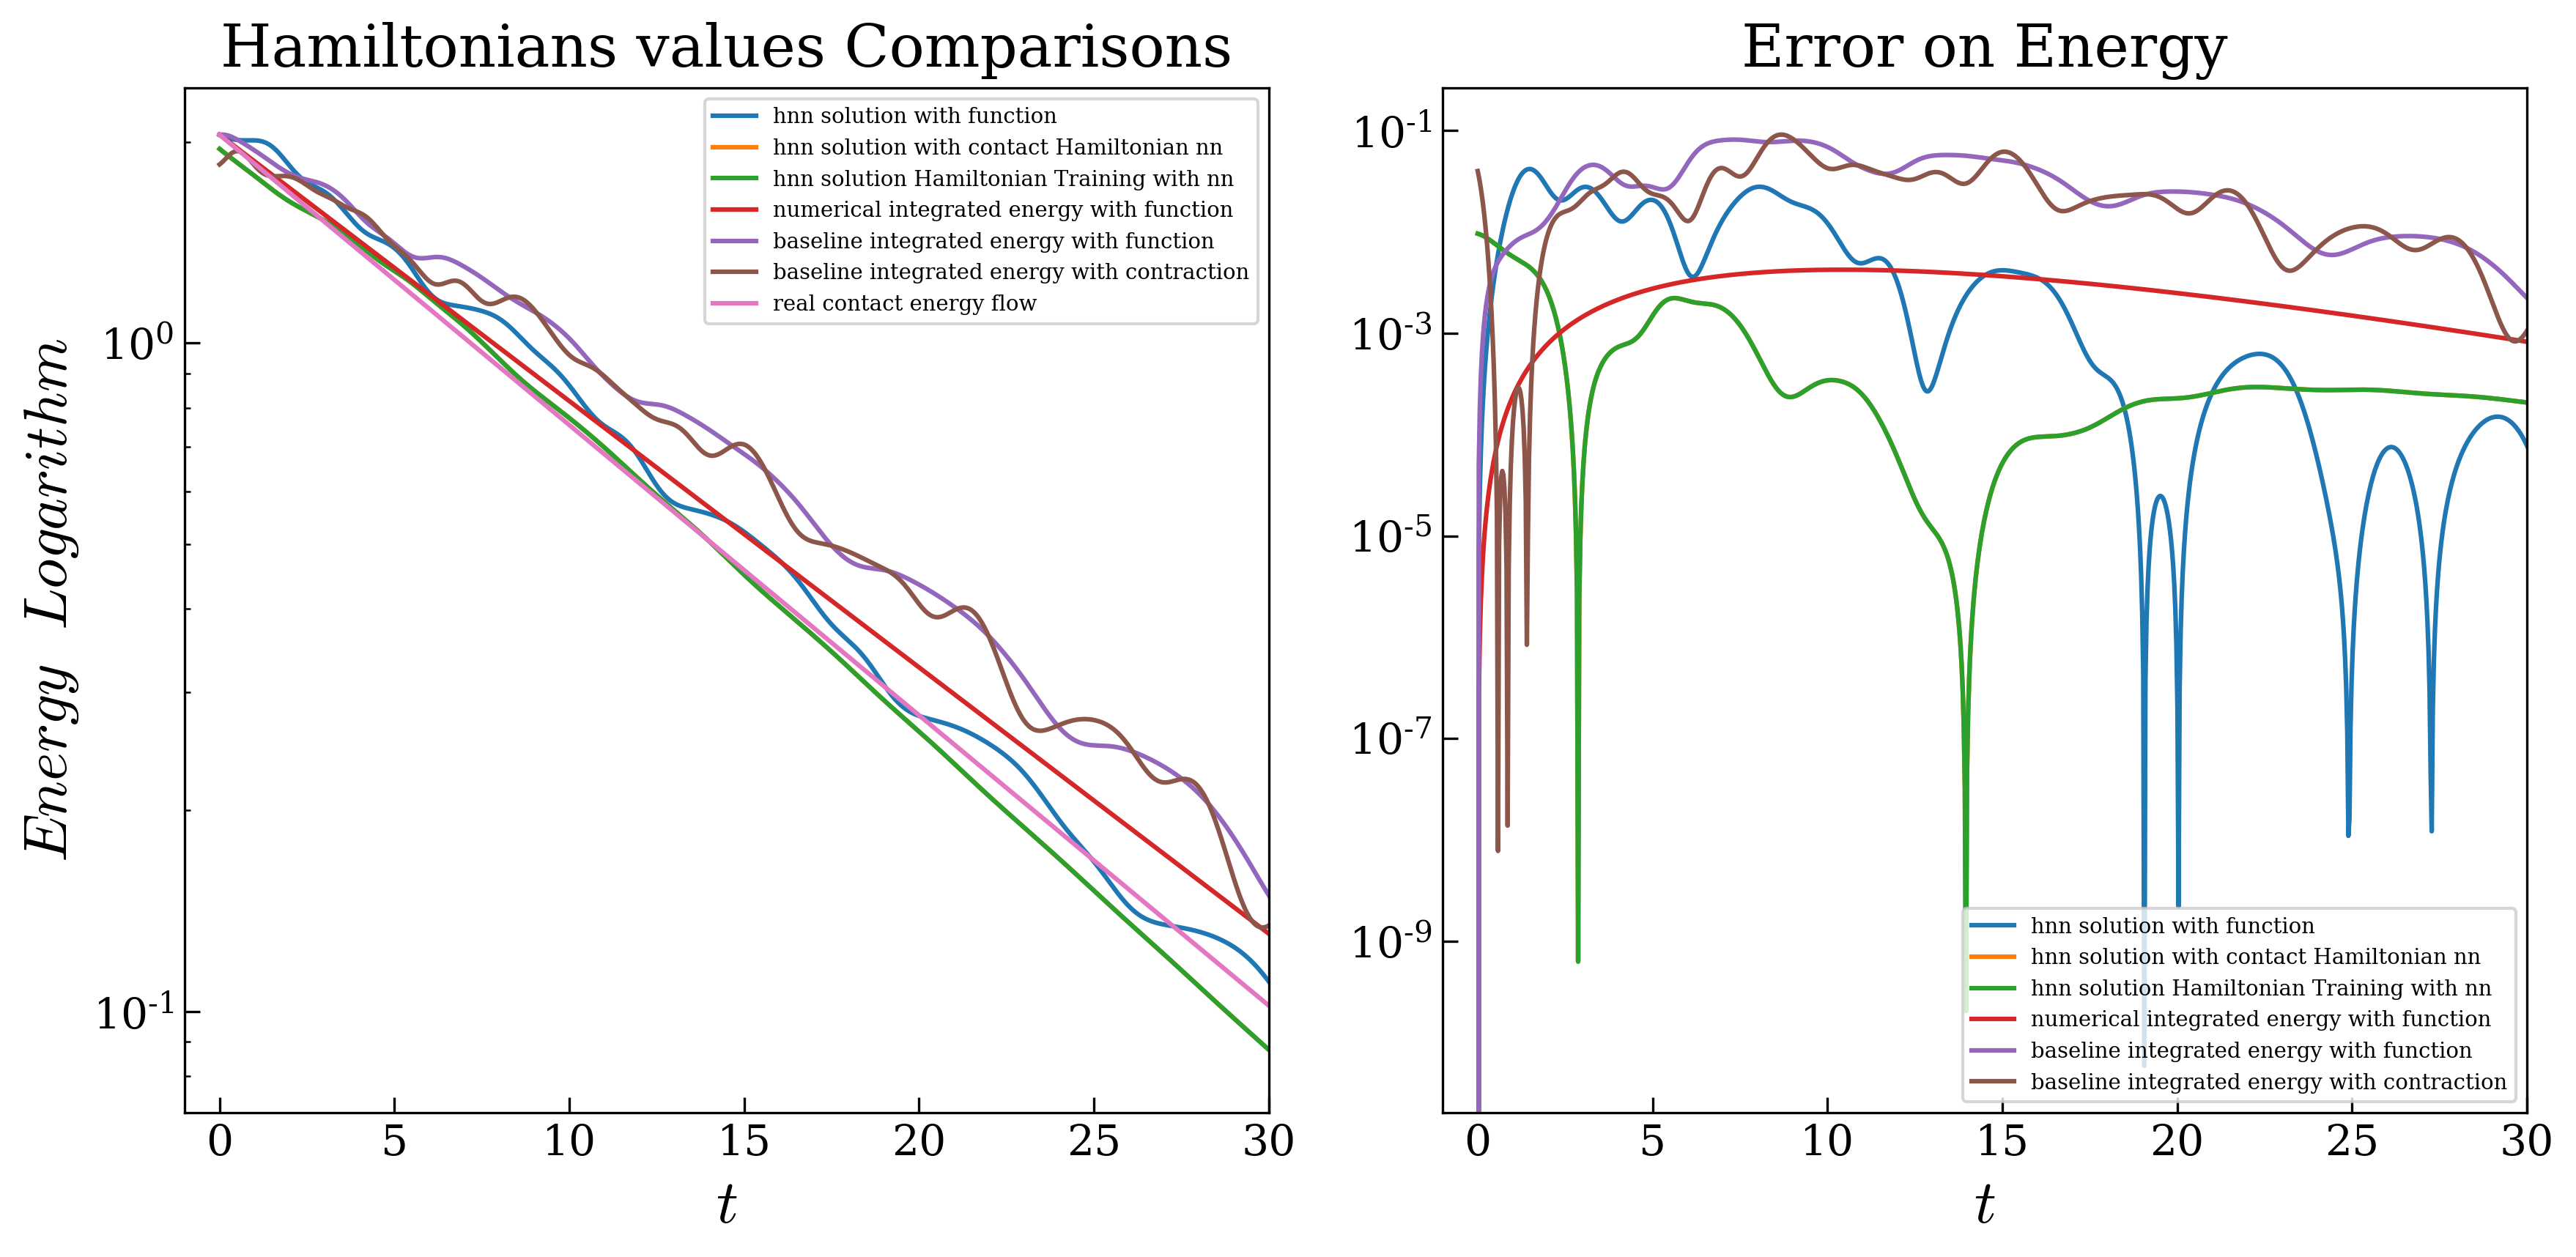

In [16]:
fig = plt.figure(figsize=[12,6], dpi=DPI)
plt.subplot(1,2,1)

plt.title("Hamiltonians values Comparisons", pad=tpad) ; plt.xlabel('$t$') ; plt.ylabel('$Energy\ \ Logarithm$')
h0=hamiltonian_fn(x0)
real_hq = np.stack([h0*np.exp(-t/10.) for t in t_eval]).squeeze()
hnn_hq = hnn_model(torch.Tensor(hnn_x))[1].detach().numpy().squeeze()
hnn_hq1 = np.stack([hamiltonian_fn(c) for c in hnn_x]).squeeze()
true_hq = np.stack([hamiltonian_fn(c) for c in true_x]).squeeze()
base_hq = np.stack([hamiltonian_fn(c) for c in base_x]).squeeze()
hnn_hq_ht = hnn_model(torch.Tensor(hnn_x_ht))[1].detach().numpy().squeeze()
base_hq1 = contact_baseline_energy(base_x).squeeze()
plt.plot(t_eval, hnn_hq1,label='hnn solution with function')
plt.plot(t_eval,hnn_hq,label='hnn solution with contact Hamiltonian nn')
plt.plot(t_eval, hnn_hq_ht, label='hnn solution Hamiltonian Training with nn')
plt.plot(t_eval, true_hq, label='numerical integrated energy with function')
plt.plot(t_eval, base_hq, label='baseline integrated energy with function')
plt.plot(t_eval, base_hq1, label='baseline integrated energy with contraction')
plt.plot(t_eval, real_hq, label='real contact energy flow')
plt.xlim(-1,30)
plt.yscale('log')
plt.legend(fontsize=7)

plt.subplot(1,2,2)
plt.title("Error on Energy", pad=tpad) ; plt.xlabel('$t$')
dhnn_hq1=(real_hq-hnn_hq1)**2
dhnn_hq=(real_hq-hnn_hq)**2
dhnn_hq_ht=(real_hq-hnn_hq_ht)**2
dtrue_hq=(real_hq-true_hq)**2
dbase_hq=(real_hq-base_hq)**2
dbase_hq1=(real_hq-base_hq1)**2
plt.plot(t_eval, (dhnn_hq1),label='hnn solution with function')
plt.plot(t_eval, (dhnn_hq),label='hnn solution with contact Hamiltonian nn')
plt.plot(t_eval, (dhnn_hq_ht),label='hnn solution Hamiltonian Training with nn')
plt.plot(t_eval, (dtrue_hq), label='numerical integrated energy with function')
plt.plot(t_eval, (dbase_hq), label='baseline integrated energy with function')
plt.plot(t_eval, (dbase_hq1), label='baseline integrated energy with contraction')
plt.xlim(-1,30)
plt.yscale('log')
plt.legend(fontsize=7)

plt.tight_layout() ; plt.show()
#fig.savefig('{}/blank{}.{}'.format(args.fig_dir, RK4, FORMAT))

In [17]:
splits = 5
samples = 3
losses = {'base_energy' : [], 'hnn_energy_wf' : [], 'hnn_energy' : []}
t_eval = np.linspace(t_span[0], t_span[1], 100)

_tmp = [] # for computing batched means
for i in range(splits*samples):
    x0 = np.random.rand(3)*1.6 - .8 # randomly sample a starting px: \in(-2,2) and abs(px) > 0.2
    x0 += 0.2 * np.sign(x0) * np.ones_like(x0)
    true_x, base_x, hnn_x, hnn_x_ht = integrate_models(x0=x0, t_span=t_span, t_eval=t_eval)
    
    losses['base_energy'] += [ energy_loss(true_x, base_x,baseline=True) ]
    losses['hnn_energy_wf'] += [ energy_loss(true_x, hnn_x_ht, baseline=False)]
    losses['hnn_energy']+= [ energy_loss(true_x, hnn_x, baseline=False)]
    print('{:.2f}% done'.format(100*float(i)/(splits*samples)), end='\r')

In [18]:
losses = {k: np.array(v) for k,v in losses.items()}
bootstrap_conf = lambda x, splits=5: np.std([np.mean(x_i) for x_i in np.split(x, splits)])/np.sqrt(splits)


print("\nBaseline NN energy MSE: {:.4e} +/- {:.2e}\nHamiltonian NN energy with function MSE: {:.4e} +/- {:.2e}\nHamiltonian NN energy MSE: {:.4e} +/- {:.2e}"
      .format(
          np.mean(losses['base_energy']), bootstrap_conf(losses['base_energy'], splits),
          np.mean(losses['hnn_energy_wf']), bootstrap_conf(losses['hnn_energy_wf'], splits),
          np.mean(losses['hnn_energy']), bootstrap_conf(losses['hnn_energy'], splits))
     )


Baseline NN energy MSE: 6.1828e-05 +/- 9.93e-06
Hamiltonian NN energy with function MSE: 1.1795e-02 +/- 2.59e-03
Hamiltonian NN energy MSE: 1.1795e-02 +/- 2.59e-03


In [19]:
from mpl_toolkits.mplot3d import axes3d
import matplotlib.pyplot as plt
import numpy as np

def plot_implicit(fn, bbox=(-2.5,2.5)):
    ''' create a plot of an implicit function
    fn  ...implicit function (plot where fn==0)
    bbox ..the x,y,and z limits of plotted interval'''
    xmin, xmax, ymin, ymax, zmin, zmax = bbox*3
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    A = np.linspace(xmin, xmax, 100) # resolution of the contour
    B = np.linspace(xmin, xmax, 15) # number of slices
    A1,A2 = np.meshgrid(A,A) # grid on which the contour is plotted

    for z in B: # plot contours in the XY plane
        X,Y = A1,A2
        Z = fn(X,Y,z)
        cset = ax.contour(X, Y, Z+z, [z], zdir='z')
        # [z] defines the only level to plot for this contour for this value of z

    for y in B: # plot contours in the XZ plane
        X,Z = A1,A2
        Y = fn(X,y,Z)
        cset = ax.contour(X, Y+y, Z, [y], zdir='y')

    for x in B: # plot contours in the YZ plane
        Y,Z = A1,A2
        X = fn(x,Y,Z)
        cset = ax.contour(X+x, Y, Z, [x], zdir='x')

    # must set plot limits because the contour will likely extend
    # way beyond the displayed level.  Otherwise matplotlib extends the plot limits
    # to encompass all values in the contour.
    ax.set_zlim3d(zmin,zmax)
    ax.set_xlim3d(xmin,xmax)
    ax.set_ylim3d(ymin,ymax)

    plt.show()

In [20]:
#def ham_nn(q,p,s):
#    x=
#    return hnn_model(torch.Tensor([[q,p,s]]))[1].detach().numpy().squeeze()

In [21]:
hnn_x.shape

(100, 3)

In [22]:
#ham_nn([1.,0.],0,0.1)

NameError: name 'ham_nn' is not defined

In [ ]:
#plot_implicit(ham_nn)

RuntimeError: Expected scalar or 1D tensor in the tensor list but got: Columns 1 to 10-2.5000 -2.5000 -2.5000 -2.5000 -2.5000 -2.5000 -2.5000 -2.5000 -2.5000 -2.5000
-2.4495 -2.4495 -2.4495 -2.4495 -2.4495 -2.4495 -2.4495 -2.4495 -2.4495 -2.4495
-2.3990 -2.3990 -2.3990 -2.3990 -2.3990 -2.3990 -2.3990 -2.3990 -2.3990 -2.3990
-2.3485 -2.3485 -2.3485 -2.3485 -2.3485 -2.3485 -2.3485 -2.3485 -2.3485 -2.3485
-2.2980 -2.2980 -2.2980 -2.2980 -2.2980 -2.2980 -2.2980 -2.2980 -2.2980 -2.2980
-2.2475 -2.2475 -2.2475 -2.2475 -2.2475 -2.2475 -2.2475 -2.2475 -2.2475 -2.2475
-2.1970 -2.1970 -2.1970 -2.1970 -2.1970 -2.1970 -2.1970 -2.1970 -2.1970 -2.1970
-2.1465 -2.1465 -2.1465 -2.1465 -2.1465 -2.1465 -2.1465 -2.1465 -2.1465 -2.1465
-2.0960 -2.0960 -2.0960 -2.0960 -2.0960 -2.0960 -2.0960 -2.0960 -2.0960 -2.0960
-2.0455 -2.0455 -2.0455 -2.0455 -2.0455 -2.0455 -2.0455 -2.0455 -2.0455 -2.0455
-1.9949 -1.9949 -1.9949 -1.9949 -1.9949 -1.9949 -1.9949 -1.9949 -1.9949 -1.9949
-1.9444 -1.9444 -1.9444 -1.9444 -1.9444 -1.9444 -1.9444 -1.9444 -1.9444 -1.9444
-1.8939 -1.8939 -1.8939 -1.8939 -1.8939 -1.8939 -1.8939 -1.8939 -1.8939 -1.8939
-1.8434 -1.8434 -1.8434 -1.8434 -1.8434 -1.8434 -1.8434 -1.8434 -1.8434 -1.8434
-1.7929 -1.7929 -1.7929 -1.7929 -1.7929 -1.7929 -1.7929 -1.7929 -1.7929 -1.7929
-1.7424 -1.7424 -1.7424 -1.7424 -1.7424 -1.7424 -1.7424 -1.7424 -1.7424 -1.7424
-1.6919 -1.6919 -1.6919 -1.6919 -1.6919 -1.6919 -1.6919 -1.6919 -1.6919 -1.6919
-1.6414 -1.6414 -1.6414 -1.6414 -1.6414 -1.6414 -1.6414 -1.6414 -1.6414 -1.6414
-1.5909 -1.5909 -1.5909 -1.5909 -1.5909 -1.5909 -1.5909 -1.5909 -1.5909 -1.5909
-1.5404 -1.5404 -1.5404 -1.5404 -1.5404 -1.5404 -1.5404 -1.5404 -1.5404 -1.5404
-1.4899 -1.4899 -1.4899 -1.4899 -1.4899 -1.4899 -1.4899 -1.4899 -1.4899 -1.4899
-1.4394 -1.4394 -1.4394 -1.4394 -1.4394 -1.4394 -1.4394 -1.4394 -1.4394 -1.4394
-1.3889 -1.3889 -1.3889 -1.3889 -1.3889 -1.3889 -1.3889 -1.3889 -1.3889 -1.3889
-1.3384 -1.3384 -1.3384 -1.3384 -1.3384 -1.3384 -1.3384 -1.3384 -1.3384 -1.3384
-1.2879 -1.2879 -1.2879 -1.2879 -1.2879 -1.2879 -1.2879 -1.2879 -1.2879 -1.2879
-1.2374 -1.2374 -1.2374 -1.2374 -1.2374 -1.2374 -1.2374 -1.2374 -1.2374 -1.2374
-1.1869 -1.1869 -1.1869 -1.1869 -1.1869 -1.1869 -1.1869 -1.1869 -1.1869 -1.1869
-1.1364 -1.1364 -1.1364 -1.1364 -1.1364 -1.1364 -1.1364 -1.1364 -1.1364 -1.1364
-1.0859 -1.0859 -1.0859 -1.0859 -1.0859 -1.0859 -1.0859 -1.0859 -1.0859 -1.0859
-1.0354 -1.0354 -1.0354 -1.0354 -1.0354 -1.0354 -1.0354 -1.0354 -1.0354 -1.0354
-0.9848 -0.9848 -0.9848 -0.9848 -0.9848 -0.9848 -0.9848 -0.9848 -0.9848 -0.9848
-0.9343 -0.9343 -0.9343 -0.9343 -0.9343 -0.9343 -0.9343 -0.9343 -0.9343 -0.9343
-0.8838 -0.8838 -0.8838 -0.8838 -0.8838 -0.8838 -0.8838 -0.8838 -0.8838 -0.8838
-0.8333 -0.8333 -0.8333 -0.8333 -0.8333 -0.8333 -0.8333 -0.8333 -0.8333 -0.8333
-0.7828 -0.7828 -0.7828 -0.7828 -0.7828 -0.7828 -0.7828 -0.7828 -0.7828 -0.7828
-0.7323 -0.7323 -0.7323 -0.7323 -0.7323 -0.7323 -0.7323 -0.7323 -0.7323 -0.7323
-0.6818 -0.6818 -0.6818 -0.6818 -0.6818 -0.6818 -0.6818 -0.6818 -0.6818 -0.6818
-0.6313 -0.6313 -0.6313 -0.6313 -0.6313 -0.6313 -0.6313 -0.6313 -0.6313 -0.6313
-0.5808 -0.5808 -0.5808 -0.5808 -0.5808 -0.5808 -0.5808 -0.5808 -0.5808 -0.5808
-0.5303 -0.5303 -0.5303 -0.5303 -0.5303 -0.5303 -0.5303 -0.5303 -0.5303 -0.5303
-0.4798 -0.4798 -0.4798 -0.4798 -0.4798 -0.4798 -0.4798 -0.4798 -0.4798 -0.4798
-0.4293 -0.4293 -0.4293 -0.4293 -0.4293 -0.4293 -0.4293 -0.4293 -0.4293 -0.4293
-0.3788 -0.3788 -0.3788 -0.3788 -0.3788 -0.3788 -0.3788 -0.3788 -0.3788 -0.3788
-0.3283 -0.3283 -0.3283 -0.3283 -0.3283 -0.3283 -0.3283 -0.3283 -0.3283 -0.3283
-0.2778 -0.2778 -0.2778 -0.2778 -0.2778 -0.2778 -0.2778 -0.2778 -0.2778 -0.2778
-0.2273 -0.2273 -0.2273 -0.2273 -0.2273 -0.2273 -0.2273 -0.2273 -0.2273 -0.2273
-0.1768 -0.1768 -0.1768 -0.1768 -0.1768 -0.1768 -0.1768 -0.1768 -0.1768 -0.1768
-0.1263 -0.1263 -0.1263 -0.1263 -0.1263 -0.1263 -0.1263 -0.1263 -0.1263 -0.1263
-0.0758 -0.0758 -0.0758 -0.0758 -0.0758 -0.0758 -0.0758 -0.0758 -0.0758 -0.0758
-0.0253 -0.0253 -0.0253 -0.0253 -0.0253 -0.0253 -0.0253 -0.0253 -0.0253 -0.0253
 0.0253  0.0253  0.0253  0.0253  0.0253  0.0253  0.0253  0.0253  0.0253  0.0253
 0.0758  0.0758  0.0758  0.0758  0.0758  0.0758  0.0758  0.0758  0.0758  0.0758
 0.1263  0.1263  0.1263  0.1263  0.1263  0.1263  0.1263  0.1263  0.1263  0.1263
 0.1768  0.1768  0.1768  0.1768  0.1768  0.1768  0.1768  0.1768  0.1768  0.1768
 0.2273  0.2273  0.2273  0.2273  0.2273  0.2273  0.2273  0.2273  0.2273  0.2273
 0.2778  0.2778  0.2778  0.2778  0.2778  0.2778  0.2778  0.2778  0.2778  0.2778
 0.3283  0.3283  0.3283  0.3283  0.3283  0.3283  0.3283  0.3283  0.3283  0.3283
 0.3788  0.3788  0.3788  0.3788  0.3788  0.3788  0.3788  0.3788  0.3788  0.3788
 0.4293  0.4293  0.4293  0.4293  0.4293  0.4293  0.4293  0.4293  0.4293  0.4293
 0.4798  0.4798  0.4798  0.4798  0.4798  0.4798  0.4798  0.4798  0.4798  0.4798
 0.5303  0.5303  0.5303  0.5303  0.5303  0.5303  0.5303  0.5303  0.5303  0.5303
 0.5808  0.5808  0.5808  0.5808  0.5808  0.5808  0.5808  0.5808  0.5808  0.5808
 0.6313  0.6313  0.6313  0.6313  0.6313  0.6313  0.6313  0.6313  0.6313  0.6313
 0.6818  0.6818  0.6818  0.6818  0.6818  0.6818  0.6818  0.6818  0.6818  0.6818
 0.7323  0.7323  0.7323  0.7323  0.7323  0.7323  0.7323  0.7323  0.7323  0.7323
 0.7828  0.7828  0.7828  0.7828  0.7828  0.7828  0.7828  0.7828  0.7828  0.7828
 0.8333  0.8333  0.8333  0.8333  0.8333  0.8333  0.8333  0.8333  0.8333  0.8333
 0.8838  0.8838  0.8838  0.8838  0.8838  0.8838  0.8838  0.8838  0.8838  0.8838
 0.9343  0.9343  0.9343  0.9343  0.9343  0.9343  0.9343  0.9343  0.9343  0.9343
 0.9848  0.9848  0.9848  0.9848  0.9848  0.9848  0.9848  0.9848  0.9848  0.9848
 1.0354  1.0354  1.0354  1.0354  1.0354  1.0354  1.0354  1.0354  1.0354  1.0354
 1.0859  1.0859  1.0859  1.0859  1.0859  1.0859  1.0859  1.0859  1.0859  1.0859
 1.1364  1.1364  1.1364  1.1364  1.1364  1.1364  1.1364  1.1364  1.1364  1.1364
 1.1869  1.1869  1.1869  1.1869  1.1869  1.1869  1.1869  1.1869  1.1869  1.1869
 1.2374  1.2374  1.2374  1.2374  1.2374  1.2374  1.2374  1.2374  1.2374  1.2374
 1.2879  1.2879  1.2879  1.2879  1.2879  1.2879  1.2879  1.2879  1.2879  1.2879
 1.3384  1.3384  1.3384  1.3384  1.3384  1.3384  1.3384  1.3384  1.3384  1.3384
 1.3889  1.3889  1.3889  1.3889  1.3889  1.3889  1.3889  1.3889  1.3889  1.3889
 1.4394  1.4394  1.4394  1.4394  1.4394  1.4394  1.4394  1.4394  1.4394  1.4394
 1.4899  1.4899  1.4899  1.4899  1.4899  1.4899  1.4899  1.4899  1.4899  1.4899
 1.5404  1.5404  1.5404  1.5404  1.5404  1.5404  1.5404  1.5404  1.5404  1.5404
 1.5909  1.5909  1.5909  1.5909  1.5909  1.5909  1.5909  1.5909  1.5909  1.5909
 1.6414  1.6414  1.6414  1.6414  1.6414  1.6414  1.6414  1.6414  1.6414  1.6414
 1.6919  1.6919  1.6919  1.6919  1.6919  1.6919  1.6919  1.6919  1.6919  1.6919
 1.7424  1.7424  1.7424  1.7424  1.7424  1.7424  1.7424  1.7424  1.7424  1.7424
 1.7929  1.7929  1.7929  1.7929  1.7929  1.7929  1.7929  1.7929  1.7929  1.7929
 1.8434  1.8434  1.8434  1.8434  1.8434  1.8434  1.8434  1.8434  1.8434  1.8434
 1.8939  1.8939  1.8939  1.8939  1.8939  1.8939  1.8939  1.8939  1.8939  1.8939
 1.9444  1.9444  1.9444  1.9444  1.9444  1.9444  1.9444  1.9444  1.9444  1.9444
 1.9949  1.9949  1.9949  1.9949  1.9949  1.9949  1.9949  1.9949  1.9949  1.9949
 2.0455  2.0455  2.0455  2.0455  2.0455  2.0455  2.0455  2.0455  2.0455  2.0455
 2.0960  2.0960  2.0960  2.0960  2.0960  2.0960  2.0960  2.0960  2.0960  2.0960
 2.1465  2.1465  2.1465  2.1465  2.1465  2.1465  2.1465  2.1465  2.1465  2.1465
 2.1970  2.1970  2.1970  2.1970  2.1970  2.1970  2.1970  2.1970  2.1970  2.1970
 2.2475  2.2475  2.2475  2.2475  2.2475  2.2475  2.2475  2.2475  2.2475  2.2475
 2.2980  2.2980  2.2980  2.2980  2.2980  2.2980  2.2980  2.2980  2.2980  2.2980
 2.3485  2.3485  2.3485  2.3485  2.3485  2.3485  2.3485  2.3485  2.3485  2.3485
 2.3990  2.3990  2.3990  2.3990  2.3990  2.3990  2.3990  2.3990  2.3990  2.3990
 2.4495  2.4495  2.4495  2.4495  2.4495  2.4495  2.4495  2.4495  2.4495  2.4495
 2.5000  2.5000  2.5000  2.5000  2.5000  2.5000  2.5000  2.5000  2.5000  2.5000

Columns 11 to 20-2.5000 -2.5000 -2.5000 -2.5000 -2.5000 -2.5000 -2.5000 -2.5000 -2.5000 -2.5000
-2.4495 -2.4495 -2.4495 -2.4495 -2.4495 -2.4495 -2.4495 -2.4495 -2.4495 -2.4495
-2.3990 -2.3990 -2.3990 -2.3990 -2.3990 -2.3990 -2.3990 -2.3990 -2.3990 -2.3990
-2.3485 -2.3485 -2.3485 -2.3485 -2.3485 -2.3485 -2.3485 -2.3485 -2.3485 -2.3485
-2.2980 -2.2980 -2.2980 -2.2980 -2.2980 -2.2980 -2.2980 -2.2980 -2.2980 -2.2980
-2.2475 -2.2475 -2.2475 -2.2475 -2.2475 -2.2475 -2.2475 -2.2475 -2.2475 -2.2475
-2.1970 -2.1970 -2.1970 -2.1970 -2.1970 -2.1970 -2.1970 -2.1970 -2.1970 -2.1970
-2.1465 -2.1465 -2.1465 -2.1465 -2.1465 -2.1465 -2.1465 -2.1465 -2.1465 -2.1465
-2.0960 -2.0960 -2.0960 -2.0960 -2.0960 -2.0960 -2.0960 -2.0960 -2.0960 -2.0960
-2.0455 -2.0455 -2.0455 -2.0455 -2.0455 -2.0455 -2.0455 -2.0455 -2.0455 -2.0455
-1.9949 -1.9949 -1.9949 -1.9949 -1.9949 -1.9949 -1.9949 -1.9949 -1.9949 -1.9949
-1.9444 -1.9444 -1.9444 -1.9444 -1.9444 -1.9444 -1.9444 -1.9444 -1.9444 -1.9444
-1.8939 -1.8939 -1.8939 -1.8939 -1.8939 -1.8939 -1.8939 -1.8939 -1.8939 -1.8939
-1.8434 -1.8434 -1.8434 -1.8434 -1.8434 -1.8434 -1.8434 -1.8434 -1.8434 -1.8434
-1.7929 -1.7929 -1.7929 -1.7929 -1.7929 -1.7929 -1.7929 -1.7929 -1.7929 -1.7929
-1.7424 -1.7424 -1.7424 -1.7424 -1.7424 -1.7424 -1.7424 -1.7424 -1.7424 -1.7424
-1.6919 -1.6919 -1.6919 -1.6919 -1.6919 -1.6919 -1.6919 -1.6919 -1.6919 -1.6919
-1.6414 -1.6414 -1.6414 -1.6414 -1.6414 -1.6414 -1.6414 -1.6414 -1.6414 -1.6414
-1.5909 -1.5909 -1.5909 -1.5909 -1.5909 -1.5909 -1.5909 -1.5909 -1.5909 -1.5909
-1.5404 -1.5404 -1.5404 -1.5404 -1.5404 -1.5404 -1.5404 -1.5404 -1.5404 -1.5404
-1.4899 -1.4899 -1.4899 -1.4899 -1.4899 -1.4899 -1.4899 -1.4899 -1.4899 -1.4899
-1.4394 -1.4394 -1.4394 -1.4394 -1.4394 -1.4394 -1.4394 -1.4394 -1.4394 -1.4394
-1.3889 -1.3889 -1.3889 -1.3889 -1.3889 -1.3889 -1.3889 -1.3889 -1.3889 -1.3889
-1.3384 -1.3384 -1.3384 -1.3384 -1.3384 -1.3384 -1.3384 -1.3384 -1.3384 -1.3384
-1.2879 -1.2879 -1.2879 -1.2879 -1.2879 -1.2879 -1.2879 -1.2879 -1.2879 -1.2879
-1.2374 -1.2374 -1.2374 -1.2374 -1.2374 -1.2374 -1.2374 -1.2374 -1.2374 -1.2374
-1.1869 -1.1869 -1.1869 -1.1869 -1.1869 -1.1869 -1.1869 -1.1869 -1.1869 -1.1869
-1.1364 -1.1364 -1.1364 -1.1364 -1.1364 -1.1364 -1.1364 -1.1364 -1.1364 -1.1364
-1.0859 -1.0859 -1.0859 -1.0859 -1.0859 -1.0859 -1.0859 -1.0859 -1.0859 -1.0859
-1.0354 -1.0354 -1.0354 -1.0354 -1.0354 -1.0354 -1.0354 -1.0354 -1.0354 -1.0354
-0.9848 -0.9848 -0.9848 -0.9848 -0.9848 -0.9848 -0.9848 -0.9848 -0.9848 -0.9848
-0.9343 -0.9343 -0.9343 -0.9343 -0.9343 -0.9343 -0.9343 -0.9343 -0.9343 -0.9343
-0.8838 -0.8838 -0.8838 -0.8838 -0.8838 -0.8838 -0.8838 -0.8838 -0.8838 -0.8838
-0.8333 -0.8333 -0.8333 -0.8333 -0.8333 -0.8333 -0.8333 -0.8333 -0.8333 -0.8333
-0.7828 -0.7828 -0.7828 -0.7828 -0.7828 -0.7828 -0.7828 -0.7828 -0.7828 -0.7828
-0.7323 -0.7323 -0.7323 -0.7323 -0.7323 -0.7323 -0.7323 -0.7323 -0.7323 -0.7323
-0.6818 -0.6818 -0.6818 -0.6818 -0.6818 -0.6818 -0.6818 -0.6818 -0.6818 -0.6818
-0.6313 -0.6313 -0.6313 -0.6313 -0.6313 -0.6313 -0.6313 -0.6313 -0.6313 -0.6313
-0.5808 -0.5808 -0.5808 -0.5808 -0.5808 -0.5808 -0.5808 -0.5808 -0.5808 -0.5808
-0.5303 -0.5303 -0.5303 -0.5303 -0.5303 -0.5303 -0.5303 -0.5303 -0.5303 -0.5303
-0.4798 -0.4798 -0.4798 -0.4798 -0.4798 -0.4798 -0.4798 -0.4798 -0.4798 -0.4798
-0.4293 -0.4293 -0.4293 -0.4293 -0.4293 -0.4293 -0.4293 -0.4293 -0.4293 -0.4293
-0.3788 -0.3788 -0.3788 -0.3788 -0.3788 -0.3788 -0.3788 -0.3788 -0.3788 -0.3788
-0.3283 -0.3283 -0.3283 -0.3283 -0.3283 -0.3283 -0.3283 -0.3283 -0.3283 -0.3283
-0.2778 -0.2778 -0.2778 -0.2778 -0.2778 -0.2778 -0.2778 -0.2778 -0.2778 -0.2778
-0.2273 -0.2273 -0.2273 -0.2273 -0.2273 -0.2273 -0.2273 -0.2273 -0.2273 -0.2273
-0.1768 -0.1768 -0.1768 -0.1768 -0.1768 -0.1768 -0.1768 -0.1768 -0.1768 -0.1768
-0.1263 -0.1263 -0.1263 -0.1263 -0.1263 -0.1263 -0.1263 -0.1263 -0.1263 -0.1263
-0.0758 -0.0758 -0.0758 -0.0758 -0.0758 -0.0758 -0.0758 -0.0758 -0.0758 -0.0758
-0.0253 -0.0253 -0.0253 -0.0253 -0.0253 -0.0253 -0.0253 -0.0253 -0.0253 -0.0253
 0.0253  0.0253  0.0253  0.0253  0.0253  0.0253  0.0253  0.0253  0.0253  0.0253
 0.0758  0.0758  0.0758  0.0758  0.0758  0.0758  0.0758  0.0758  0.0758  0.0758
 0.1263  0.1263  0.1263  0.1263  0.1263  0.1263  0.1263  0.1263  0.1263  0.1263
 0.1768  0.1768  0.1768  0.1768  0.1768  0.1768  0.1768  0.1768  0.1768  0.1768
 0.2273  0.2273  0.2273  0.2273  0.2273  0.2273  0.2273  0.2273  0.2273  0.2273
 0.2778  0.2778  0.2778  0.2778  0.2778  0.2778  0.2778  0.2778  0.2778  0.2778
 0.3283  0.3283  0.3283  0.3283  0.3283  0.3283  0.3283  0.3283  0.3283  0.3283
 0.3788  0.3788  0.3788  0.3788  0.3788  0.3788  0.3788  0.3788  0.3788  0.3788
 0.4293  0.4293  0.4293  0.4293  0.4293  0.4293  0.4293  0.4293  0.4293  0.4293
 0.4798  0.4798  0.4798  0.4798  0.4798  0.4798  0.4798  0.4798  0.4798  0.4798
 0.5303  0.5303  0.5303  0.5303  0.5303  0.5303  0.5303  0.5303  0.5303  0.5303
 0.5808  0.5808  0.5808  0.5808  0.5808  0.5808  0.5808  0.5808  0.5808  0.5808
 0.6313  0.6313  0.6313  0.6313  0.6313  0.6313  0.6313  0.6313  0.6313  0.6313
 0.6818  0.6818  0.6818  0.6818  0.6818  0.6818  0.6818  0.6818  0.6818  0.6818
 0.7323  0.7323  0.7323  0.7323  0.7323  0.7323  0.7323  0.7323  0.7323  0.7323
 0.7828  0.7828  0.7828  0.7828  0.7828  0.7828  0.7828  0.7828  0.7828  0.7828
 0.8333  0.8333  0.8333  0.8333  0.8333  0.8333  0.8333  0.8333  0.8333  0.8333
 0.8838  0.8838  0.8838  0.8838  0.8838  0.8838  0.8838  0.8838  0.8838  0.8838
 0.9343  0.9343  0.9343  0.9343  0.9343  0.9343  0.9343  0.9343  0.9343  0.9343
 0.9848  0.9848  0.9848  0.9848  0.9848  0.9848  0.9848  0.9848  0.9848  0.9848
 1.0354  1.0354  1.0354  1.0354  1.0354  1.0354  1.0354  1.0354  1.0354  1.0354
 1.0859  1.0859  1.0859  1.0859  1.0859  1.0859  1.0859  1.0859  1.0859  1.0859
 1.1364  1.1364  1.1364  1.1364  1.1364  1.1364  1.1364  1.1364  1.1364  1.1364
 1.1869  1.1869  1.1869  1.1869  1.1869  1.1869  1.1869  1.1869  1.1869  1.1869
 1.2374  1.2374  1.2374  1.2374  1.2374  1.2374  1.2374  1.2374  1.2374  1.2374
 1.2879  1.2879  1.2879  1.2879  1.2879  1.2879  1.2879  1.2879  1.2879  1.2879
 1.3384  1.3384  1.3384  1.3384  1.3384  1.3384  1.3384  1.3384  1.3384  1.3384
 1.3889  1.3889  1.3889  1.3889  1.3889  1.3889  1.3889  1.3889  1.3889  1.3889
 1.4394  1.4394  1.4394  1.4394  1.4394  1.4394  1.4394  1.4394  1.4394  1.4394
 1.4899  1.4899  1.4899  1.4899  1.4899  1.4899  1.4899  1.4899  1.4899  1.4899
 1.5404  1.5404  1.5404  1.5404  1.5404  1.5404  1.5404  1.5404  1.5404  1.5404
 1.5909  1.5909  1.5909  1.5909  1.5909  1.5909  1.5909  1.5909  1.5909  1.5909
 1.6414  1.6414  1.6414  1.6414  1.6414  1.6414  1.6414  1.6414  1.6414  1.6414
 1.6919  1.6919  1.6919  1.6919  1.6919  1.6919  1.6919  1.6919  1.6919  1.6919
 1.7424  1.7424  1.7424  1.7424  1.7424  1.7424  1.7424  1.7424  1.7424  1.7424
 1.7929  1.7929  1.7929  1.7929  1.7929  1.7929  1.7929  1.7929  1.7929  1.7929
 1.8434  1.8434  1.8434  1.8434  1.8434  1.8434  1.8434  1.8434  1.8434  1.8434
 1.8939  1.8939  1.8939  1.8939  1.8939  1.8939  1.8939  1.8939  1.8939  1.8939
 1.9444  1.9444  1.9444  1.9444  1.9444  1.9444  1.9444  1.9444  1.9444  1.9444
 1.9949  1.9949  1.9949  1.9949  1.9949  1.9949  1.9949  1.9949  1.9949  1.9949
 2.0455  2.0455  2.0455  2.0455  2.0455  2.0455  2.0455  2.0455  2.0455  2.0455
 2.0960  2.0960  2.0960  2.0960  2.0960  2.0960  2.0960  2.0960  2.0960  2.0960
 2.1465  2.1465  2.1465  2.1465  2.1465  2.1465  2.1465  2.1465  2.1465  2.1465
 2.1970  2.1970  2.1970  2.1970  2.1970  2.1970  2.1970  2.1970  2.1970  2.1970
 2.2475  2.2475  2.2475  2.2475  2.2475  2.2475  2.2475  2.2475  2.2475  2.2475
 2.2980  2.2980  2.2980  2.2980  2.2980  2.2980  2.2980  2.2980  2.2980  2.2980
 2.3485  2.3485  2.3485  2.3485  2.3485  2.3485  2.3485  2.3485  2.3485  2.3485
 2.3990  2.3990  2.3990  2.3990  2.3990  2.3990  2.3990  2.3990  2.3990  2.3990
 2.4495  2.4495  2.4495  2.4495  2.4495  2.4495  2.4495  2.4495  2.4495  2.4495
 2.5000  2.5000  2.5000  2.5000  2.5000  2.5000  2.5000  2.5000  2.5000  2.5000

Columns 21 to 30-2.5000 -2.5000 -2.5000 -2.5000 -2.5000 -2.5000 -2.5000 -2.5000 -2.5000 -2.5000
-2.4495 -2.4495 -2.4495 -2.4495 -2.4495 -2.4495 -2.4495 -2.4495 -2.4495 -2.4495
-2.3990 -2.3990 -2.3990 -2.3990 -2.3990 -2.3990 -2.3990 -2.3990 -2.3990 -2.3990
-2.3485 -2.3485 -2.3485 -2.3485 -2.3485 -2.3485 -2.3485 -2.3485 -2.3485 -2.3485
-2.2980 -2.2980 -2.2980 -2.2980 -2.2980 -2.2980 -2.2980 -2.2980 -2.2980 -2.2980
-2.2475 -2.2475 -2.2475 -2.2475 -2.2475 -2.2475 -2.2475 -2.2475 -2.2475 -2.2475
-2.1970 -2.1970 -2.1970 -2.1970 -2.1970 -2.1970 -2.1970 -2.1970 -2.1970 -2.1970
-2.1465 -2.1465 -2.1465 -2.1465 -2.1465 -2.1465 -2.1465 -2.1465 -2.1465 -2.1465
-2.0960 -2.0960 -2.0960 -2.0960 -2.0960 -2.0960 -2.0960 -2.0960 -2.0960 -2.0960
-2.0455 -2.0455 -2.0455 -2.0455 -2.0455 -2.0455 -2.0455 -2.0455 -2.0455 -2.0455
-1.9949 -1.9949 -1.9949 -1.9949 -1.9949 -1.9949 -1.9949 -1.9949 -1.9949 -1.9949
-1.9444 -1.9444 -1.9444 -1.9444 -1.9444 -1.9444 -1.9444 -1.9444 -1.9444 -1.9444
-1.8939 -1.8939 -1.8939 -1.8939 -1.8939 -1.8939 -1.8939 -1.8939 -1.8939 -1.8939
-1.8434 -1.8434 -1.8434 -1.8434 -1.8434 -1.8434 -1.8434 -1.8434 -1.8434 -1.8434
-1.7929 -1.7929 -1.7929 -1.7929 -1.7929 -1.7929 -1.7929 -1.7929 -1.7929 -1.7929
-1.7424 -1.7424 -1.7424 -1.7424 -1.7424 -1.7424 -1.7424 -1.7424 -1.7424 -1.7424
-1.6919 -1.6919 -1.6919 -1.6919 -1.6919 -1.6919 -1.6919 -1.6919 -1.6919 -1.6919
-1.6414 -1.6414 -1.6414 -1.6414 -1.6414 -1.6414 -1.6414 -1.6414 -1.6414 -1.6414
-1.5909 -1.5909 -1.5909 -1.5909 -1.5909 -1.5909 -1.5909 -1.5909 -1.5909 -1.5909
-1.5404 -1.5404 -1.5404 -1.5404 -1.5404 -1.5404 -1.5404 -1.5404 -1.5404 -1.5404
-1.4899 -1.4899 -1.4899 -1.4899 -1.4899 -1.4899 -1.4899 -1.4899 -1.4899 -1.4899
-1.4394 -1.4394 -1.4394 -1.4394 -1.4394 -1.4394 -1.4394 -1.4394 -1.4394 -1.4394
-1.3889 -1.3889 -1.3889 -1.3889 -1.3889 -1.3889 -1.3889 -1.3889 -1.3889 -1.3889
-1.3384 -1.3384 -1.3384 -1.3384 -1.3384 -1.3384 -1.3384 -1.3384 -1.3384 -1.3384
-1.2879 -1.2879 -1.2879 -1.2879 -1.2879 -1.2879 -1.2879 -1.2879 -1.2879 -1.2879
-1.2374 -1.2374 -1.2374 -1.2374 -1.2374 -1.2374 -1.2374 -1.2374 -1.2374 -1.2374
-1.1869 -1.1869 -1.1869 -1.1869 -1.1869 -1.1869 -1.1869 -1.1869 -1.1869 -1.1869
-1.1364 -1.1364 -1.1364 -1.1364 -1.1364 -1.1364 -1.1364 -1.1364 -1.1364 -1.1364
-1.0859 -1.0859 -1.0859 -1.0859 -1.0859 -1.0859 -1.0859 -1.0859 -1.0859 -1.0859
-1.0354 -1.0354 -1.0354 -1.0354 -1.0354 -1.0354 -1.0354 -1.0354 -1.0354 -1.0354
-0.9848 -0.9848 -0.9848 -0.9848 -0.9848 -0.9848 -0.9848 -0.9848 -0.9848 -0.9848
-0.9343 -0.9343 -0.9343 -0.9343 -0.9343 -0.9343 -0.9343 -0.9343 -0.9343 -0.9343
-0.8838 -0.8838 -0.8838 -0.8838 -0.8838 -0.8838 -0.8838 -0.8838 -0.8838 -0.8838
-0.8333 -0.8333 -0.8333 -0.8333 -0.8333 -0.8333 -0.8333 -0.8333 -0.8333 -0.8333
-0.7828 -0.7828 -0.7828 -0.7828 -0.7828 -0.7828 -0.7828 -0.7828 -0.7828 -0.7828
-0.7323 -0.7323 -0.7323 -0.7323 -0.7323 -0.7323 -0.7323 -0.7323 -0.7323 -0.7323
-0.6818 -0.6818 -0.6818 -0.6818 -0.6818 -0.6818 -0.6818 -0.6818 -0.6818 -0.6818
-0.6313 -0.6313 -0.6313 -0.6313 -0.6313 -0.6313 -0.6313 -0.6313 -0.6313 -0.6313
-0.5808 -0.5808 -0.5808 -0.5808 -0.5808 -0.5808 -0.5808 -0.5808 -0.5808 -0.5808
-0.5303 -0.5303 -0.5303 -0.5303 -0.5303 -0.5303 -0.5303 -0.5303 -0.5303 -0.5303
-0.4798 -0.4798 -0.4798 -0.4798 -0.4798 -0.4798 -0.4798 -0.4798 -0.4798 -0.4798
-0.4293 -0.4293 -0.4293 -0.4293 -0.4293 -0.4293 -0.4293 -0.4293 -0.4293 -0.4293
-0.3788 -0.3788 -0.3788 -0.3788 -0.3788 -0.3788 -0.3788 -0.3788 -0.3788 -0.3788
-0.3283 -0.3283 -0.3283 -0.3283 -0.3283 -0.3283 -0.3283 -0.3283 -0.3283 -0.3283
-0.2778 -0.2778 -0.2778 -0.2778 -0.2778 -0.2778 -0.2778 -0.2778 -0.2778 -0.2778
-0.2273 -0.2273 -0.2273 -0.2273 -0.2273 -0.2273 -0.2273 -0.2273 -0.2273 -0.2273
-0.1768 -0.1768 -0.1768 -0.1768 -0.1768 -0.1768 -0.1768 -0.1768 -0.1768 -0.1768
-0.1263 -0.1263 -0.1263 -0.1263 -0.1263 -0.1263 -0.1263 -0.1263 -0.1263 -0.1263
-0.0758 -0.0758 -0.0758 -0.0758 -0.0758 -0.0758 -0.0758 -0.0758 -0.0758 -0.0758
-0.0253 -0.0253 -0.0253 -0.0253 -0.0253 -0.0253 -0.0253 -0.0253 -0.0253 -0.0253
 0.0253  0.0253  0.0253  0.0253  0.0253  0.0253  0.0253  0.0253  0.0253  0.0253
 0.0758  0.0758  0.0758  0.0758  0.0758  0.0758  0.0758  0.0758  0.0758  0.0758
 0.1263  0.1263  0.1263  0.1263  0.1263  0.1263  0.1263  0.1263  0.1263  0.1263
 0.1768  0.1768  0.1768  0.1768  0.1768  0.1768  0.1768  0.1768  0.1768  0.1768
 0.2273  0.2273  0.2273  0.2273  0.2273  0.2273  0.2273  0.2273  0.2273  0.2273
 0.2778  0.2778  0.2778  0.2778  0.2778  0.2778  0.2778  0.2778  0.2778  0.2778
 0.3283  0.3283  0.3283  0.3283  0.3283  0.3283  0.3283  0.3283  0.3283  0.3283
 0.3788  0.3788  0.3788  0.3788  0.3788  0.3788  0.3788  0.3788  0.3788  0.3788
 0.4293  0.4293  0.4293  0.4293  0.4293  0.4293  0.4293  0.4293  0.4293  0.4293
 0.4798  0.4798  0.4798  0.4798  0.4798  0.4798  0.4798  0.4798  0.4798  0.4798
 0.5303  0.5303  0.5303  0.5303  0.5303  0.5303  0.5303  0.5303  0.5303  0.5303
 0.5808  0.5808  0.5808  0.5808  0.5808  0.5808  0.5808  0.5808  0.5808  0.5808
 0.6313  0.6313  0.6313  0.6313  0.6313  0.6313  0.6313  0.6313  0.6313  0.6313
 0.6818  0.6818  0.6818  0.6818  0.6818  0.6818  0.6818  0.6818  0.6818  0.6818
 0.7323  0.7323  0.7323  0.7323  0.7323  0.7323  0.7323  0.7323  0.7323  0.7323
 0.7828  0.7828  0.7828  0.7828  0.7828  0.7828  0.7828  0.7828  0.7828  0.7828
 0.8333  0.8333  0.8333  0.8333  0.8333  0.8333  0.8333  0.8333  0.8333  0.8333
 0.8838  0.8838  0.8838  0.8838  0.8838  0.8838  0.8838  0.8838  0.8838  0.8838
 0.9343  0.9343  0.9343  0.9343  0.9343  0.9343  0.9343  0.9343  0.9343  0.9343
 0.9848  0.9848  0.9848  0.9848  0.9848  0.9848  0.9848  0.9848  0.9848  0.9848
 1.0354  1.0354  1.0354  1.0354  1.0354  1.0354  1.0354  1.0354  1.0354  1.0354
 1.0859  1.0859  1.0859  1.0859  1.0859  1.0859  1.0859  1.0859  1.0859  1.0859
 1.1364  1.1364  1.1364  1.1364  1.1364  1.1364  1.1364  1.1364  1.1364  1.1364
 1.1869  1.1869  1.1869  1.1869  1.1869  1.1869  1.1869  1.1869  1.1869  1.1869
 1.2374  1.2374  1.2374  1.2374  1.2374  1.2374  1.2374  1.2374  1.2374  1.2374
 1.2879  1.2879  1.2879  1.2879  1.2879  1.2879  1.2879  1.2879  1.2879  1.2879
 1.3384  1.3384  1.3384  1.3384  1.3384  1.3384  1.3384  1.3384  1.3384  1.3384
 1.3889  1.3889  1.3889  1.3889  1.3889  1.3889  1.3889  1.3889  1.3889  1.3889
 1.4394  1.4394  1.4394  1.4394  1.4394  1.4394  1.4394  1.4394  1.4394  1.4394
 1.4899  1.4899  1.4899  1.4899  1.4899  1.4899  1.4899  1.4899  1.4899  1.4899
 1.5404  1.5404  1.5404  1.5404  1.5404  1.5404  1.5404  1.5404  1.5404  1.5404
 1.5909  1.5909  1.5909  1.5909  1.5909  1.5909  1.5909  1.5909  1.5909  1.5909
 1.6414  1.6414  1.6414  1.6414  1.6414  1.6414  1.6414  1.6414  1.6414  1.6414
 1.6919  1.6919  1.6919  1.6919  1.6919  1.6919  1.6919  1.6919  1.6919  1.6919
 1.7424  1.7424  1.7424  1.7424  1.7424  1.7424  1.7424  1.7424  1.7424  1.7424
 1.7929  1.7929  1.7929  1.7929  1.7929  1.7929  1.7929  1.7929  1.7929  1.7929
 1.8434  1.8434  1.8434  1.8434  1.8434  1.8434  1.8434  1.8434  1.8434  1.8434
 1.8939  1.8939  1.8939  1.8939  1.8939  1.8939  1.8939  1.8939  1.8939  1.8939
 1.9444  1.9444  1.9444  1.9444  1.9444  1.9444  1.9444  1.9444  1.9444  1.9444
 1.9949  1.9949  1.9949  1.9949  1.9949  1.9949  1.9949  1.9949  1.9949  1.9949
 2.0455  2.0455  2.0455  2.0455  2.0455  2.0455  2.0455  2.0455  2.0455  2.0455
 2.0960  2.0960  2.0960  2.0960  2.0960  2.0960  2.0960  2.0960  2.0960  2.0960
 2.1465  2.1465  2.1465  2.1465  2.1465  2.1465  2.1465  2.1465  2.1465  2.1465
 2.1970  2.1970  2.1970  2.1970  2.1970  2.1970  2.1970  2.1970  2.1970  2.1970
 2.2475  2.2475  2.2475  2.2475  2.2475  2.2475  2.2475  2.2475  2.2475  2.2475
 2.2980  2.2980  2.2980  2.2980  2.2980  2.2980  2.2980  2.2980  2.2980  2.2980
 2.3485  2.3485  2.3485  2.3485  2.3485  2.3485  2.3485  2.3485  2.3485  2.3485
 2.3990  2.3990  2.3990  2.3990  2.3990  2.3990  2.3990  2.3990  2.3990  2.3990
 2.4495  2.4495  2.4495  2.4495  2.4495  2.4495  2.4495  2.4495  2.4495  2.4495
 2.5000  2.5000  2.5000  2.5000  2.5000  2.5000  2.5000  2.5000  2.5000  2.5000

Columns 31 to 40-2.5000 -2.5000 -2.5000 -2.5000 -2.5000 -2.5000 -2.5000 -2.5000 -2.5000 -2.5000
-2.4495 -2.4495 -2.4495 -2.4495 -2.4495 -2.4495 -2.4495 -2.4495 -2.4495 -2.4495
-2.3990 -2.3990 -2.3990 -2.3990 -2.3990 -2.3990 -2.3990 -2.3990 -2.3990 -2.3990
-2.3485 -2.3485 -2.3485 -2.3485 -2.3485 -2.3485 -2.3485 -2.3485 -2.3485 -2.3485
-2.2980 -2.2980 -2.2980 -2.2980 -2.2980 -2.2980 -2.2980 -2.2980 -2.2980 -2.2980
-2.2475 -2.2475 -2.2475 -2.2475 -2.2475 -2.2475 -2.2475 -2.2475 -2.2475 -2.2475
-2.1970 -2.1970 -2.1970 -2.1970 -2.1970 -2.1970 -2.1970 -2.1970 -2.1970 -2.1970
-2.1465 -2.1465 -2.1465 -2.1465 -2.1465 -2.1465 -2.1465 -2.1465 -2.1465 -2.1465
-2.0960 -2.0960 -2.0960 -2.0960 -2.0960 -2.0960 -2.0960 -2.0960 -2.0960 -2.0960
-2.0455 -2.0455 -2.0455 -2.0455 -2.0455 -2.0455 -2.0455 -2.0455 -2.0455 -2.0455
-1.9949 -1.9949 -1.9949 -1.9949 -1.9949 -1.9949 -1.9949 -1.9949 -1.9949 -1.9949
-1.9444 -1.9444 -1.9444 -1.9444 -1.9444 -1.9444 -1.9444 -1.9444 -1.9444 -1.9444
-1.8939 -1.8939 -1.8939 -1.8939 -1.8939 -1.8939 -1.8939 -1.8939 -1.8939 -1.8939
-1.8434 -1.8434 -1.8434 -1.8434 -1.8434 -1.8434 -1.8434 -1.8434 -1.8434 -1.8434
-1.7929 -1.7929 -1.7929 -1.7929 -1.7929 -1.7929 -1.7929 -1.7929 -1.7929 -1.7929
-1.7424 -1.7424 -1.7424 -1.7424 -1.7424 -1.7424 -1.7424 -1.7424 -1.7424 -1.7424
-1.6919 -1.6919 -1.6919 -1.6919 -1.6919 -1.6919 -1.6919 -1.6919 -1.6919 -1.6919
-1.6414 -1.6414 -1.6414 -1.6414 -1.6414 -1.6414 -1.6414 -1.6414 -1.6414 -1.6414
-1.5909 -1.5909 -1.5909 -1.5909 -1.5909 -1.5909 -1.5909 -1.5909 -1.5909 -1.5909
-1.5404 -1.5404 -1.5404 -1.5404 -1.5404 -1.5404 -1.5404 -1.5404 -1.5404 -1.5404
-1.4899 -1.4899 -1.4899 -1.4899 -1.4899 -1.4899 -1.4899 -1.4899 -1.4899 -1.4899
-1.4394 -1.4394 -1.4394 -1.4394 -1.4394 -1.4394 -1.4394 -1.4394 -1.4394 -1.4394
-1.3889 -1.3889 -1.3889 -1.3889 -1.3889 -1.3889 -1.3889 -1.3889 -1.3889 -1.3889
-1.3384 -1.3384 -1.3384 -1.3384 -1.3384 -1.3384 -1.3384 -1.3384 -1.3384 -1.3384
-1.2879 -1.2879 -1.2879 -1.2879 -1.2879 -1.2879 -1.2879 -1.2879 -1.2879 -1.2879
-1.2374 -1.2374 -1.2374 -1.2374 -1.2374 -1.2374 -1.2374 -1.2374 -1.2374 -1.2374
-1.1869 -1.1869 -1.1869 -1.1869 -1.1869 -1.1869 -1.1869 -1.1869 -1.1869 -1.1869
-1.1364 -1.1364 -1.1364 -1.1364 -1.1364 -1.1364 -1.1364 -1.1364 -1.1364 -1.1364
-1.0859 -1.0859 -1.0859 -1.0859 -1.0859 -1.0859 -1.0859 -1.0859 -1.0859 -1.0859
-1.0354 -1.0354 -1.0354 -1.0354 -1.0354 -1.0354 -1.0354 -1.0354 -1.0354 -1.0354
-0.9848 -0.9848 -0.9848 -0.9848 -0.9848 -0.9848 -0.9848 -0.9848 -0.9848 -0.9848
-0.9343 -0.9343 -0.9343 -0.9343 -0.9343 -0.9343 -0.9343 -0.9343 -0.9343 -0.9343
-0.8838 -0.8838 -0.8838 -0.8838 -0.8838 -0.8838 -0.8838 -0.8838 -0.8838 -0.8838
-0.8333 -0.8333 -0.8333 -0.8333 -0.8333 -0.8333 -0.8333 -0.8333 -0.8333 -0.8333
-0.7828 -0.7828 -0.7828 -0.7828 -0.7828 -0.7828 -0.7828 -0.7828 -0.7828 -0.7828
-0.7323 -0.7323 -0.7323 -0.7323 -0.7323 -0.7323 -0.7323 -0.7323 -0.7323 -0.7323
-0.6818 -0.6818 -0.6818 -0.6818 -0.6818 -0.6818 -0.6818 -0.6818 -0.6818 -0.6818
-0.6313 -0.6313 -0.6313 -0.6313 -0.6313 -0.6313 -0.6313 -0.6313 -0.6313 -0.6313
-0.5808 -0.5808 -0.5808 -0.5808 -0.5808 -0.5808 -0.5808 -0.5808 -0.5808 -0.5808
-0.5303 -0.5303 -0.5303 -0.5303 -0.5303 -0.5303 -0.5303 -0.5303 -0.5303 -0.5303
-0.4798 -0.4798 -0.4798 -0.4798 -0.4798 -0.4798 -0.4798 -0.4798 -0.4798 -0.4798
-0.4293 -0.4293 -0.4293 -0.4293 -0.4293 -0.4293 -0.4293 -0.4293 -0.4293 -0.4293
-0.3788 -0.3788 -0.3788 -0.3788 -0.3788 -0.3788 -0.3788 -0.3788 -0.3788 -0.3788
-0.3283 -0.3283 -0.3283 -0.3283 -0.3283 -0.3283 -0.3283 -0.3283 -0.3283 -0.3283
-0.2778 -0.2778 -0.2778 -0.2778 -0.2778 -0.2778 -0.2778 -0.2778 -0.2778 -0.2778
-0.2273 -0.2273 -0.2273 -0.2273 -0.2273 -0.2273 -0.2273 -0.2273 -0.2273 -0.2273
-0.1768 -0.1768 -0.1768 -0.1768 -0.1768 -0.1768 -0.1768 -0.1768 -0.1768 -0.1768
-0.1263 -0.1263 -0.1263 -0.1263 -0.1263 -0.1263 -0.1263 -0.1263 -0.1263 -0.1263
-0.0758 -0.0758 -0.0758 -0.0758 -0.0758 -0.0758 -0.0758 -0.0758 -0.0758 -0.0758
-0.0253 -0.0253 -0.0253 -0.0253 -0.0253 -0.0253 -0.0253 -0.0253 -0.0253 -0.0253
 0.0253  0.0253  0.0253  0.0253  0.0253  0.0253  0.0253  0.0253  0.0253  0.0253
 0.0758  0.0758  0.0758  0.0758  0.0758  0.0758  0.0758  0.0758  0.0758  0.0758
 0.1263  0.1263  0.1263  0.1263  0.1263  0.1263  0.1263  0.1263  0.1263  0.1263
 0.1768  0.1768  0.1768  0.1768  0.1768  0.1768  0.1768  0.1768  0.1768  0.1768
 0.2273  0.2273  0.2273  0.2273  0.2273  0.2273  0.2273  0.2273  0.2273  0.2273
 0.2778  0.2778  0.2778  0.2778  0.2778  0.2778  0.2778  0.2778  0.2778  0.2778
 0.3283  0.3283  0.3283  0.3283  0.3283  0.3283  0.3283  0.3283  0.3283  0.3283
 0.3788  0.3788  0.3788  0.3788  0.3788  0.3788  0.3788  0.3788  0.3788  0.3788
 0.4293  0.4293  0.4293  0.4293  0.4293  0.4293  0.4293  0.4293  0.4293  0.4293
 0.4798  0.4798  0.4798  0.4798  0.4798  0.4798  0.4798  0.4798  0.4798  0.4798
 0.5303  0.5303  0.5303  0.5303  0.5303  0.5303  0.5303  0.5303  0.5303  0.5303
 0.5808  0.5808  0.5808  0.5808  0.5808  0.5808  0.5808  0.5808  0.5808  0.5808
 0.6313  0.6313  0.6313  0.6313  0.6313  0.6313  0.6313  0.6313  0.6313  0.6313
 0.6818  0.6818  0.6818  0.6818  0.6818  0.6818  0.6818  0.6818  0.6818  0.6818
 0.7323  0.7323  0.7323  0.7323  0.7323  0.7323  0.7323  0.7323  0.7323  0.7323
 0.7828  0.7828  0.7828  0.7828  0.7828  0.7828  0.7828  0.7828  0.7828  0.7828
 0.8333  0.8333  0.8333  0.8333  0.8333  0.8333  0.8333  0.8333  0.8333  0.8333
 0.8838  0.8838  0.8838  0.8838  0.8838  0.8838  0.8838  0.8838  0.8838  0.8838
 0.9343  0.9343  0.9343  0.9343  0.9343  0.9343  0.9343  0.9343  0.9343  0.9343
 0.9848  0.9848  0.9848  0.9848  0.9848  0.9848  0.9848  0.9848  0.9848  0.9848
 1.0354  1.0354  1.0354  1.0354  1.0354  1.0354  1.0354  1.0354  1.0354  1.0354
 1.0859  1.0859  1.0859  1.0859  1.0859  1.0859  1.0859  1.0859  1.0859  1.0859
 1.1364  1.1364  1.1364  1.1364  1.1364  1.1364  1.1364  1.1364  1.1364  1.1364
 1.1869  1.1869  1.1869  1.1869  1.1869  1.1869  1.1869  1.1869  1.1869  1.1869
 1.2374  1.2374  1.2374  1.2374  1.2374  1.2374  1.2374  1.2374  1.2374  1.2374
 1.2879  1.2879  1.2879  1.2879  1.2879  1.2879  1.2879  1.2879  1.2879  1.2879
 1.3384  1.3384  1.3384  1.3384  1.3384  1.3384  1.3384  1.3384  1.3384  1.3384
 1.3889  1.3889  1.3889  1.3889  1.3889  1.3889  1.3889  1.3889  1.3889  1.3889
 1.4394  1.4394  1.4394  1.4394  1.4394  1.4394  1.4394  1.4394  1.4394  1.4394
 1.4899  1.4899  1.4899  1.4899  1.4899  1.4899  1.4899  1.4899  1.4899  1.4899
 1.5404  1.5404  1.5404  1.5404  1.5404  1.5404  1.5404  1.5404  1.5404  1.5404
 1.5909  1.5909  1.5909  1.5909  1.5909  1.5909  1.5909  1.5909  1.5909  1.5909
 1.6414  1.6414  1.6414  1.6414  1.6414  1.6414  1.6414  1.6414  1.6414  1.6414
 1.6919  1.6919  1.6919  1.6919  1.6919  1.6919  1.6919  1.6919  1.6919  1.6919
 1.7424  1.7424  1.7424  1.7424  1.7424  1.7424  1.7424  1.7424  1.7424  1.7424
 1.7929  1.7929  1.7929  1.7929  1.7929  1.7929  1.7929  1.7929  1.7929  1.7929
 1.8434  1.8434  1.8434  1.8434  1.8434  1.8434  1.8434  1.8434  1.8434  1.8434
 1.8939  1.8939  1.8939  1.8939  1.8939  1.8939  1.8939  1.8939  1.8939  1.8939
 1.9444  1.9444  1.9444  1.9444  1.9444  1.9444  1.9444  1.9444  1.9444  1.9444
 1.9949  1.9949  1.9949  1.9949  1.9949  1.9949  1.9949  1.9949  1.9949  1.9949
 2.0455  2.0455  2.0455  2.0455  2.0455  2.0455  2.0455  2.0455  2.0455  2.0455
 2.0960  2.0960  2.0960  2.0960  2.0960  2.0960  2.0960  2.0960  2.0960  2.0960
 2.1465  2.1465  2.1465  2.1465  2.1465  2.1465  2.1465  2.1465  2.1465  2.1465
 2.1970  2.1970  2.1970  2.1970  2.1970  2.1970  2.1970  2.1970  2.1970  2.1970
 2.2475  2.2475  2.2475  2.2475  2.2475  2.2475  2.2475  2.2475  2.2475  2.2475
 2.2980  2.2980  2.2980  2.2980  2.2980  2.2980  2.2980  2.2980  2.2980  2.2980
 2.3485  2.3485  2.3485  2.3485  2.3485  2.3485  2.3485  2.3485  2.3485  2.3485
 2.3990  2.3990  2.3990  2.3990  2.3990  2.3990  2.3990  2.3990  2.3990  2.3990
 2.4495  2.4495  2.4495  2.4495  2.4495  2.4495  2.4495  2.4495  2.4495  2.4495
 2.5000  2.5000  2.5000  2.5000  2.5000  2.5000  2.5000  2.5000  2.5000  2.5000

Columns 41 to 50-2.5000 -2.5000 -2.5000 -2.5000 -2.5000 -2.5000 -2.5000 -2.5000 -2.5000 -2.5000
-2.4495 -2.4495 -2.4495 -2.4495 -2.4495 -2.4495 -2.4495 -2.4495 -2.4495 -2.4495
-2.3990 -2.3990 -2.3990 -2.3990 -2.3990 -2.3990 -2.3990 -2.3990 -2.3990 -2.3990
-2.3485 -2.3485 -2.3485 -2.3485 -2.3485 -2.3485 -2.3485 -2.3485 -2.3485 -2.3485
-2.2980 -2.2980 -2.2980 -2.2980 -2.2980 -2.2980 -2.2980 -2.2980 -2.2980 -2.2980
-2.2475 -2.2475 -2.2475 -2.2475 -2.2475 -2.2475 -2.2475 -2.2475 -2.2475 -2.2475
-2.1970 -2.1970 -2.1970 -2.1970 -2.1970 -2.1970 -2.1970 -2.1970 -2.1970 -2.1970
-2.1465 -2.1465 -2.1465 -2.1465 -2.1465 -2.1465 -2.1465 -2.1465 -2.1465 -2.1465
-2.0960 -2.0960 -2.0960 -2.0960 -2.0960 -2.0960 -2.0960 -2.0960 -2.0960 -2.0960
-2.0455 -2.0455 -2.0455 -2.0455 -2.0455 -2.0455 -2.0455 -2.0455 -2.0455 -2.0455
-1.9949 -1.9949 -1.9949 -1.9949 -1.9949 -1.9949 -1.9949 -1.9949 -1.9949 -1.9949
-1.9444 -1.9444 -1.9444 -1.9444 -1.9444 -1.9444 -1.9444 -1.9444 -1.9444 -1.9444
-1.8939 -1.8939 -1.8939 -1.8939 -1.8939 -1.8939 -1.8939 -1.8939 -1.8939 -1.8939
-1.8434 -1.8434 -1.8434 -1.8434 -1.8434 -1.8434 -1.8434 -1.8434 -1.8434 -1.8434
-1.7929 -1.7929 -1.7929 -1.7929 -1.7929 -1.7929 -1.7929 -1.7929 -1.7929 -1.7929
-1.7424 -1.7424 -1.7424 -1.7424 -1.7424 -1.7424 -1.7424 -1.7424 -1.7424 -1.7424
-1.6919 -1.6919 -1.6919 -1.6919 -1.6919 -1.6919 -1.6919 -1.6919 -1.6919 -1.6919
-1.6414 -1.6414 -1.6414 -1.6414 -1.6414 -1.6414 -1.6414 -1.6414 -1.6414 -1.6414
-1.5909 -1.5909 -1.5909 -1.5909 -1.5909 -1.5909 -1.5909 -1.5909 -1.5909 -1.5909
-1.5404 -1.5404 -1.5404 -1.5404 -1.5404 -1.5404 -1.5404 -1.5404 -1.5404 -1.5404
-1.4899 -1.4899 -1.4899 -1.4899 -1.4899 -1.4899 -1.4899 -1.4899 -1.4899 -1.4899
-1.4394 -1.4394 -1.4394 -1.4394 -1.4394 -1.4394 -1.4394 -1.4394 -1.4394 -1.4394
-1.3889 -1.3889 -1.3889 -1.3889 -1.3889 -1.3889 -1.3889 -1.3889 -1.3889 -1.3889
-1.3384 -1.3384 -1.3384 -1.3384 -1.3384 -1.3384 -1.3384 -1.3384 -1.3384 -1.3384
-1.2879 -1.2879 -1.2879 -1.2879 -1.2879 -1.2879 -1.2879 -1.2879 -1.2879 -1.2879
-1.2374 -1.2374 -1.2374 -1.2374 -1.2374 -1.2374 -1.2374 -1.2374 -1.2374 -1.2374
-1.1869 -1.1869 -1.1869 -1.1869 -1.1869 -1.1869 -1.1869 -1.1869 -1.1869 -1.1869
-1.1364 -1.1364 -1.1364 -1.1364 -1.1364 -1.1364 -1.1364 -1.1364 -1.1364 -1.1364
-1.0859 -1.0859 -1.0859 -1.0859 -1.0859 -1.0859 -1.0859 -1.0859 -1.0859 -1.0859
-1.0354 -1.0354 -1.0354 -1.0354 -1.0354 -1.0354 -1.0354 -1.0354 -1.0354 -1.0354
-0.9848 -0.9848 -0.9848 -0.9848 -0.9848 -0.9848 -0.9848 -0.9848 -0.9848 -0.9848
-0.9343 -0.9343 -0.9343 -0.9343 -0.9343 -0.9343 -0.9343 -0.9343 -0.9343 -0.9343
-0.8838 -0.8838 -0.8838 -0.8838 -0.8838 -0.8838 -0.8838 -0.8838 -0.8838 -0.8838
-0.8333 -0.8333 -0.8333 -0.8333 -0.8333 -0.8333 -0.8333 -0.8333 -0.8333 -0.8333
-0.7828 -0.7828 -0.7828 -0.7828 -0.7828 -0.7828 -0.7828 -0.7828 -0.7828 -0.7828
-0.7323 -0.7323 -0.7323 -0.7323 -0.7323 -0.7323 -0.7323 -0.7323 -0.7323 -0.7323
-0.6818 -0.6818 -0.6818 -0.6818 -0.6818 -0.6818 -0.6818 -0.6818 -0.6818 -0.6818
-0.6313 -0.6313 -0.6313 -0.6313 -0.6313 -0.6313 -0.6313 -0.6313 -0.6313 -0.6313
-0.5808 -0.5808 -0.5808 -0.5808 -0.5808 -0.5808 -0.5808 -0.5808 -0.5808 -0.5808
-0.5303 -0.5303 -0.5303 -0.5303 -0.5303 -0.5303 -0.5303 -0.5303 -0.5303 -0.5303
-0.4798 -0.4798 -0.4798 -0.4798 -0.4798 -0.4798 -0.4798 -0.4798 -0.4798 -0.4798
-0.4293 -0.4293 -0.4293 -0.4293 -0.4293 -0.4293 -0.4293 -0.4293 -0.4293 -0.4293
-0.3788 -0.3788 -0.3788 -0.3788 -0.3788 -0.3788 -0.3788 -0.3788 -0.3788 -0.3788
-0.3283 -0.3283 -0.3283 -0.3283 -0.3283 -0.3283 -0.3283 -0.3283 -0.3283 -0.3283
-0.2778 -0.2778 -0.2778 -0.2778 -0.2778 -0.2778 -0.2778 -0.2778 -0.2778 -0.2778
-0.2273 -0.2273 -0.2273 -0.2273 -0.2273 -0.2273 -0.2273 -0.2273 -0.2273 -0.2273
-0.1768 -0.1768 -0.1768 -0.1768 -0.1768 -0.1768 -0.1768 -0.1768 -0.1768 -0.1768
-0.1263 -0.1263 -0.1263 -0.1263 -0.1263 -0.1263 -0.1263 -0.1263 -0.1263 -0.1263
-0.0758 -0.0758 -0.0758 -0.0758 -0.0758 -0.0758 -0.0758 -0.0758 -0.0758 -0.0758
-0.0253 -0.0253 -0.0253 -0.0253 -0.0253 -0.0253 -0.0253 -0.0253 -0.0253 -0.0253
 0.0253  0.0253  0.0253  0.0253  0.0253  0.0253  0.0253  0.0253  0.0253  0.0253
 0.0758  0.0758  0.0758  0.0758  0.0758  0.0758  0.0758  0.0758  0.0758  0.0758
 0.1263  0.1263  0.1263  0.1263  0.1263  0.1263  0.1263  0.1263  0.1263  0.1263
 0.1768  0.1768  0.1768  0.1768  0.1768  0.1768  0.1768  0.1768  0.1768  0.1768
 0.2273  0.2273  0.2273  0.2273  0.2273  0.2273  0.2273  0.2273  0.2273  0.2273
 0.2778  0.2778  0.2778  0.2778  0.2778  0.2778  0.2778  0.2778  0.2778  0.2778
 0.3283  0.3283  0.3283  0.3283  0.3283  0.3283  0.3283  0.3283  0.3283  0.3283
 0.3788  0.3788  0.3788  0.3788  0.3788  0.3788  0.3788  0.3788  0.3788  0.3788
 0.4293  0.4293  0.4293  0.4293  0.4293  0.4293  0.4293  0.4293  0.4293  0.4293
 0.4798  0.4798  0.4798  0.4798  0.4798  0.4798  0.4798  0.4798  0.4798  0.4798
 0.5303  0.5303  0.5303  0.5303  0.5303  0.5303  0.5303  0.5303  0.5303  0.5303
 0.5808  0.5808  0.5808  0.5808  0.5808  0.5808  0.5808  0.5808  0.5808  0.5808
 0.6313  0.6313  0.6313  0.6313  0.6313  0.6313  0.6313  0.6313  0.6313  0.6313
 0.6818  0.6818  0.6818  0.6818  0.6818  0.6818  0.6818  0.6818  0.6818  0.6818
 0.7323  0.7323  0.7323  0.7323  0.7323  0.7323  0.7323  0.7323  0.7323  0.7323
 0.7828  0.7828  0.7828  0.7828  0.7828  0.7828  0.7828  0.7828  0.7828  0.7828
 0.8333  0.8333  0.8333  0.8333  0.8333  0.8333  0.8333  0.8333  0.8333  0.8333
 0.8838  0.8838  0.8838  0.8838  0.8838  0.8838  0.8838  0.8838  0.8838  0.8838
 0.9343  0.9343  0.9343  0.9343  0.9343  0.9343  0.9343  0.9343  0.9343  0.9343
 0.9848  0.9848  0.9848  0.9848  0.9848  0.9848  0.9848  0.9848  0.9848  0.9848
 1.0354  1.0354  1.0354  1.0354  1.0354  1.0354  1.0354  1.0354  1.0354  1.0354
 1.0859  1.0859  1.0859  1.0859  1.0859  1.0859  1.0859  1.0859  1.0859  1.0859
 1.1364  1.1364  1.1364  1.1364  1.1364  1.1364  1.1364  1.1364  1.1364  1.1364
 1.1869  1.1869  1.1869  1.1869  1.1869  1.1869  1.1869  1.1869  1.1869  1.1869
 1.2374  1.2374  1.2374  1.2374  1.2374  1.2374  1.2374  1.2374  1.2374  1.2374
 1.2879  1.2879  1.2879  1.2879  1.2879  1.2879  1.2879  1.2879  1.2879  1.2879
 1.3384  1.3384  1.3384  1.3384  1.3384  1.3384  1.3384  1.3384  1.3384  1.3384
 1.3889  1.3889  1.3889  1.3889  1.3889  1.3889  1.3889  1.3889  1.3889  1.3889
 1.4394  1.4394  1.4394  1.4394  1.4394  1.4394  1.4394  1.4394  1.4394  1.4394
 1.4899  1.4899  1.4899  1.4899  1.4899  1.4899  1.4899  1.4899  1.4899  1.4899
 1.5404  1.5404  1.5404  1.5404  1.5404  1.5404  1.5404  1.5404  1.5404  1.5404
 1.5909  1.5909  1.5909  1.5909  1.5909  1.5909  1.5909  1.5909  1.5909  1.5909
 1.6414  1.6414  1.6414  1.6414  1.6414  1.6414  1.6414  1.6414  1.6414  1.6414
 1.6919  1.6919  1.6919  1.6919  1.6919  1.6919  1.6919  1.6919  1.6919  1.6919
 1.7424  1.7424  1.7424  1.7424  1.7424  1.7424  1.7424  1.7424  1.7424  1.7424
 1.7929  1.7929  1.7929  1.7929  1.7929  1.7929  1.7929  1.7929  1.7929  1.7929
 1.8434  1.8434  1.8434  1.8434  1.8434  1.8434  1.8434  1.8434  1.8434  1.8434
 1.8939  1.8939  1.8939  1.8939  1.8939  1.8939  1.8939  1.8939  1.8939  1.8939
 1.9444  1.9444  1.9444  1.9444  1.9444  1.9444  1.9444  1.9444  1.9444  1.9444
 1.9949  1.9949  1.9949  1.9949  1.9949  1.9949  1.9949  1.9949  1.9949  1.9949
 2.0455  2.0455  2.0455  2.0455  2.0455  2.0455  2.0455  2.0455  2.0455  2.0455
 2.0960  2.0960  2.0960  2.0960  2.0960  2.0960  2.0960  2.0960  2.0960  2.0960
 2.1465  2.1465  2.1465  2.1465  2.1465  2.1465  2.1465  2.1465  2.1465  2.1465
 2.1970  2.1970  2.1970  2.1970  2.1970  2.1970  2.1970  2.1970  2.1970  2.1970
 2.2475  2.2475  2.2475  2.2475  2.2475  2.2475  2.2475  2.2475  2.2475  2.2475
 2.2980  2.2980  2.2980  2.2980  2.2980  2.2980  2.2980  2.2980  2.2980  2.2980
 2.3485  2.3485  2.3485  2.3485  2.3485  2.3485  2.3485  2.3485  2.3485  2.3485
 2.3990  2.3990  2.3990  2.3990  2.3990  2.3990  2.3990  2.3990  2.3990  2.3990
 2.4495  2.4495  2.4495  2.4495  2.4495  2.4495  2.4495  2.4495  2.4495  2.4495
 2.5000  2.5000  2.5000  2.5000  2.5000  2.5000  2.5000  2.5000  2.5000  2.5000

Columns 51 to 60-2.5000 -2.5000 -2.5000 -2.5000 -2.5000 -2.5000 -2.5000 -2.5000 -2.5000 -2.5000
-2.4495 -2.4495 -2.4495 -2.4495 -2.4495 -2.4495 -2.4495 -2.4495 -2.4495 -2.4495
-2.3990 -2.3990 -2.3990 -2.3990 -2.3990 -2.3990 -2.3990 -2.3990 -2.3990 -2.3990
-2.3485 -2.3485 -2.3485 -2.3485 -2.3485 -2.3485 -2.3485 -2.3485 -2.3485 -2.3485
-2.2980 -2.2980 -2.2980 -2.2980 -2.2980 -2.2980 -2.2980 -2.2980 -2.2980 -2.2980
-2.2475 -2.2475 -2.2475 -2.2475 -2.2475 -2.2475 -2.2475 -2.2475 -2.2475 -2.2475
-2.1970 -2.1970 -2.1970 -2.1970 -2.1970 -2.1970 -2.1970 -2.1970 -2.1970 -2.1970
-2.1465 -2.1465 -2.1465 -2.1465 -2.1465 -2.1465 -2.1465 -2.1465 -2.1465 -2.1465
-2.0960 -2.0960 -2.0960 -2.0960 -2.0960 -2.0960 -2.0960 -2.0960 -2.0960 -2.0960
-2.0455 -2.0455 -2.0455 -2.0455 -2.0455 -2.0455 -2.0455 -2.0455 -2.0455 -2.0455
-1.9949 -1.9949 -1.9949 -1.9949 -1.9949 -1.9949 -1.9949 -1.9949 -1.9949 -1.9949
-1.9444 -1.9444 -1.9444 -1.9444 -1.9444 -1.9444 -1.9444 -1.9444 -1.9444 -1.9444
-1.8939 -1.8939 -1.8939 -1.8939 -1.8939 -1.8939 -1.8939 -1.8939 -1.8939 -1.8939
-1.8434 -1.8434 -1.8434 -1.8434 -1.8434 -1.8434 -1.8434 -1.8434 -1.8434 -1.8434
-1.7929 -1.7929 -1.7929 -1.7929 -1.7929 -1.7929 -1.7929 -1.7929 -1.7929 -1.7929
-1.7424 -1.7424 -1.7424 -1.7424 -1.7424 -1.7424 -1.7424 -1.7424 -1.7424 -1.7424
-1.6919 -1.6919 -1.6919 -1.6919 -1.6919 -1.6919 -1.6919 -1.6919 -1.6919 -1.6919
-1.6414 -1.6414 -1.6414 -1.6414 -1.6414 -1.6414 -1.6414 -1.6414 -1.6414 -1.6414
-1.5909 -1.5909 -1.5909 -1.5909 -1.5909 -1.5909 -1.5909 -1.5909 -1.5909 -1.5909
-1.5404 -1.5404 -1.5404 -1.5404 -1.5404 -1.5404 -1.5404 -1.5404 -1.5404 -1.5404
-1.4899 -1.4899 -1.4899 -1.4899 -1.4899 -1.4899 -1.4899 -1.4899 -1.4899 -1.4899
-1.4394 -1.4394 -1.4394 -1.4394 -1.4394 -1.4394 -1.4394 -1.4394 -1.4394 -1.4394
-1.3889 -1.3889 -1.3889 -1.3889 -1.3889 -1.3889 -1.3889 -1.3889 -1.3889 -1.3889
-1.3384 -1.3384 -1.3384 -1.3384 -1.3384 -1.3384 -1.3384 -1.3384 -1.3384 -1.3384
-1.2879 -1.2879 -1.2879 -1.2879 -1.2879 -1.2879 -1.2879 -1.2879 -1.2879 -1.2879
-1.2374 -1.2374 -1.2374 -1.2374 -1.2374 -1.2374 -1.2374 -1.2374 -1.2374 -1.2374
-1.1869 -1.1869 -1.1869 -1.1869 -1.1869 -1.1869 -1.1869 -1.1869 -1.1869 -1.1869
-1.1364 -1.1364 -1.1364 -1.1364 -1.1364 -1.1364 -1.1364 -1.1364 -1.1364 -1.1364
-1.0859 -1.0859 -1.0859 -1.0859 -1.0859 -1.0859 -1.0859 -1.0859 -1.0859 -1.0859
-1.0354 -1.0354 -1.0354 -1.0354 -1.0354 -1.0354 -1.0354 -1.0354 -1.0354 -1.0354
-0.9848 -0.9848 -0.9848 -0.9848 -0.9848 -0.9848 -0.9848 -0.9848 -0.9848 -0.9848
-0.9343 -0.9343 -0.9343 -0.9343 -0.9343 -0.9343 -0.9343 -0.9343 -0.9343 -0.9343
-0.8838 -0.8838 -0.8838 -0.8838 -0.8838 -0.8838 -0.8838 -0.8838 -0.8838 -0.8838
-0.8333 -0.8333 -0.8333 -0.8333 -0.8333 -0.8333 -0.8333 -0.8333 -0.8333 -0.8333
-0.7828 -0.7828 -0.7828 -0.7828 -0.7828 -0.7828 -0.7828 -0.7828 -0.7828 -0.7828
-0.7323 -0.7323 -0.7323 -0.7323 -0.7323 -0.7323 -0.7323 -0.7323 -0.7323 -0.7323
-0.6818 -0.6818 -0.6818 -0.6818 -0.6818 -0.6818 -0.6818 -0.6818 -0.6818 -0.6818
-0.6313 -0.6313 -0.6313 -0.6313 -0.6313 -0.6313 -0.6313 -0.6313 -0.6313 -0.6313
-0.5808 -0.5808 -0.5808 -0.5808 -0.5808 -0.5808 -0.5808 -0.5808 -0.5808 -0.5808
-0.5303 -0.5303 -0.5303 -0.5303 -0.5303 -0.5303 -0.5303 -0.5303 -0.5303 -0.5303
-0.4798 -0.4798 -0.4798 -0.4798 -0.4798 -0.4798 -0.4798 -0.4798 -0.4798 -0.4798
-0.4293 -0.4293 -0.4293 -0.4293 -0.4293 -0.4293 -0.4293 -0.4293 -0.4293 -0.4293
-0.3788 -0.3788 -0.3788 -0.3788 -0.3788 -0.3788 -0.3788 -0.3788 -0.3788 -0.3788
-0.3283 -0.3283 -0.3283 -0.3283 -0.3283 -0.3283 -0.3283 -0.3283 -0.3283 -0.3283
-0.2778 -0.2778 -0.2778 -0.2778 -0.2778 -0.2778 -0.2778 -0.2778 -0.2778 -0.2778
-0.2273 -0.2273 -0.2273 -0.2273 -0.2273 -0.2273 -0.2273 -0.2273 -0.2273 -0.2273
-0.1768 -0.1768 -0.1768 -0.1768 -0.1768 -0.1768 -0.1768 -0.1768 -0.1768 -0.1768
-0.1263 -0.1263 -0.1263 -0.1263 -0.1263 -0.1263 -0.1263 -0.1263 -0.1263 -0.1263
-0.0758 -0.0758 -0.0758 -0.0758 -0.0758 -0.0758 -0.0758 -0.0758 -0.0758 -0.0758
-0.0253 -0.0253 -0.0253 -0.0253 -0.0253 -0.0253 -0.0253 -0.0253 -0.0253 -0.0253
 0.0253  0.0253  0.0253  0.0253  0.0253  0.0253  0.0253  0.0253  0.0253  0.0253
 0.0758  0.0758  0.0758  0.0758  0.0758  0.0758  0.0758  0.0758  0.0758  0.0758
 0.1263  0.1263  0.1263  0.1263  0.1263  0.1263  0.1263  0.1263  0.1263  0.1263
 0.1768  0.1768  0.1768  0.1768  0.1768  0.1768  0.1768  0.1768  0.1768  0.1768
 0.2273  0.2273  0.2273  0.2273  0.2273  0.2273  0.2273  0.2273  0.2273  0.2273
 0.2778  0.2778  0.2778  0.2778  0.2778  0.2778  0.2778  0.2778  0.2778  0.2778
 0.3283  0.3283  0.3283  0.3283  0.3283  0.3283  0.3283  0.3283  0.3283  0.3283
 0.3788  0.3788  0.3788  0.3788  0.3788  0.3788  0.3788  0.3788  0.3788  0.3788
 0.4293  0.4293  0.4293  0.4293  0.4293  0.4293  0.4293  0.4293  0.4293  0.4293
 0.4798  0.4798  0.4798  0.4798  0.4798  0.4798  0.4798  0.4798  0.4798  0.4798
 0.5303  0.5303  0.5303  0.5303  0.5303  0.5303  0.5303  0.5303  0.5303  0.5303
 0.5808  0.5808  0.5808  0.5808  0.5808  0.5808  0.5808  0.5808  0.5808  0.5808
 0.6313  0.6313  0.6313  0.6313  0.6313  0.6313  0.6313  0.6313  0.6313  0.6313
 0.6818  0.6818  0.6818  0.6818  0.6818  0.6818  0.6818  0.6818  0.6818  0.6818
 0.7323  0.7323  0.7323  0.7323  0.7323  0.7323  0.7323  0.7323  0.7323  0.7323
 0.7828  0.7828  0.7828  0.7828  0.7828  0.7828  0.7828  0.7828  0.7828  0.7828
 0.8333  0.8333  0.8333  0.8333  0.8333  0.8333  0.8333  0.8333  0.8333  0.8333
 0.8838  0.8838  0.8838  0.8838  0.8838  0.8838  0.8838  0.8838  0.8838  0.8838
 0.9343  0.9343  0.9343  0.9343  0.9343  0.9343  0.9343  0.9343  0.9343  0.9343
 0.9848  0.9848  0.9848  0.9848  0.9848  0.9848  0.9848  0.9848  0.9848  0.9848
 1.0354  1.0354  1.0354  1.0354  1.0354  1.0354  1.0354  1.0354  1.0354  1.0354
 1.0859  1.0859  1.0859  1.0859  1.0859  1.0859  1.0859  1.0859  1.0859  1.0859
 1.1364  1.1364  1.1364  1.1364  1.1364  1.1364  1.1364  1.1364  1.1364  1.1364
 1.1869  1.1869  1.1869  1.1869  1.1869  1.1869  1.1869  1.1869  1.1869  1.1869
 1.2374  1.2374  1.2374  1.2374  1.2374  1.2374  1.2374  1.2374  1.2374  1.2374
 1.2879  1.2879  1.2879  1.2879  1.2879  1.2879  1.2879  1.2879  1.2879  1.2879
 1.3384  1.3384  1.3384  1.3384  1.3384  1.3384  1.3384  1.3384  1.3384  1.3384
 1.3889  1.3889  1.3889  1.3889  1.3889  1.3889  1.3889  1.3889  1.3889  1.3889
 1.4394  1.4394  1.4394  1.4394  1.4394  1.4394  1.4394  1.4394  1.4394  1.4394
 1.4899  1.4899  1.4899  1.4899  1.4899  1.4899  1.4899  1.4899  1.4899  1.4899
 1.5404  1.5404  1.5404  1.5404  1.5404  1.5404  1.5404  1.5404  1.5404  1.5404
 1.5909  1.5909  1.5909  1.5909  1.5909  1.5909  1.5909  1.5909  1.5909  1.5909
 1.6414  1.6414  1.6414  1.6414  1.6414  1.6414  1.6414  1.6414  1.6414  1.6414
 1.6919  1.6919  1.6919  1.6919  1.6919  1.6919  1.6919  1.6919  1.6919  1.6919
 1.7424  1.7424  1.7424  1.7424  1.7424  1.7424  1.7424  1.7424  1.7424  1.7424
 1.7929  1.7929  1.7929  1.7929  1.7929  1.7929  1.7929  1.7929  1.7929  1.7929
 1.8434  1.8434  1.8434  1.8434  1.8434  1.8434  1.8434  1.8434  1.8434  1.8434
 1.8939  1.8939  1.8939  1.8939  1.8939  1.8939  1.8939  1.8939  1.8939  1.8939
 1.9444  1.9444  1.9444  1.9444  1.9444  1.9444  1.9444  1.9444  1.9444  1.9444
 1.9949  1.9949  1.9949  1.9949  1.9949  1.9949  1.9949  1.9949  1.9949  1.9949
 2.0455  2.0455  2.0455  2.0455  2.0455  2.0455  2.0455  2.0455  2.0455  2.0455
 2.0960  2.0960  2.0960  2.0960  2.0960  2.0960  2.0960  2.0960  2.0960  2.0960
 2.1465  2.1465  2.1465  2.1465  2.1465  2.1465  2.1465  2.1465  2.1465  2.1465
 2.1970  2.1970  2.1970  2.1970  2.1970  2.1970  2.1970  2.1970  2.1970  2.1970
 2.2475  2.2475  2.2475  2.2475  2.2475  2.2475  2.2475  2.2475  2.2475  2.2475
 2.2980  2.2980  2.2980  2.2980  2.2980  2.2980  2.2980  2.2980  2.2980  2.2980
 2.3485  2.3485  2.3485  2.3485  2.3485  2.3485  2.3485  2.3485  2.3485  2.3485
 2.3990  2.3990  2.3990  2.3990  2.3990  2.3990  2.3990  2.3990  2.3990  2.3990
 2.4495  2.4495  2.4495  2.4495  2.4495  2.4495  2.4495  2.4495  2.4495  2.4495
 2.5000  2.5000  2.5000  2.5000  2.5000  2.5000  2.5000  2.5000  2.5000  2.5000

Columns 61 to 70-2.5000 -2.5000 -2.5000 -2.5000 -2.5000 -2.5000 -2.5000 -2.5000 -2.5000 -2.5000
-2.4495 -2.4495 -2.4495 -2.4495 -2.4495 -2.4495 -2.4495 -2.4495 -2.4495 -2.4495
-2.3990 -2.3990 -2.3990 -2.3990 -2.3990 -2.3990 -2.3990 -2.3990 -2.3990 -2.3990
-2.3485 -2.3485 -2.3485 -2.3485 -2.3485 -2.3485 -2.3485 -2.3485 -2.3485 -2.3485
-2.2980 -2.2980 -2.2980 -2.2980 -2.2980 -2.2980 -2.2980 -2.2980 -2.2980 -2.2980
-2.2475 -2.2475 -2.2475 -2.2475 -2.2475 -2.2475 -2.2475 -2.2475 -2.2475 -2.2475
-2.1970 -2.1970 -2.1970 -2.1970 -2.1970 -2.1970 -2.1970 -2.1970 -2.1970 -2.1970
-2.1465 -2.1465 -2.1465 -2.1465 -2.1465 -2.1465 -2.1465 -2.1465 -2.1465 -2.1465
-2.0960 -2.0960 -2.0960 -2.0960 -2.0960 -2.0960 -2.0960 -2.0960 -2.0960 -2.0960
-2.0455 -2.0455 -2.0455 -2.0455 -2.0455 -2.0455 -2.0455 -2.0455 -2.0455 -2.0455
-1.9949 -1.9949 -1.9949 -1.9949 -1.9949 -1.9949 -1.9949 -1.9949 -1.9949 -1.9949
-1.9444 -1.9444 -1.9444 -1.9444 -1.9444 -1.9444 -1.9444 -1.9444 -1.9444 -1.9444
-1.8939 -1.8939 -1.8939 -1.8939 -1.8939 -1.8939 -1.8939 -1.8939 -1.8939 -1.8939
-1.8434 -1.8434 -1.8434 -1.8434 -1.8434 -1.8434 -1.8434 -1.8434 -1.8434 -1.8434
-1.7929 -1.7929 -1.7929 -1.7929 -1.7929 -1.7929 -1.7929 -1.7929 -1.7929 -1.7929
-1.7424 -1.7424 -1.7424 -1.7424 -1.7424 -1.7424 -1.7424 -1.7424 -1.7424 -1.7424
-1.6919 -1.6919 -1.6919 -1.6919 -1.6919 -1.6919 -1.6919 -1.6919 -1.6919 -1.6919
-1.6414 -1.6414 -1.6414 -1.6414 -1.6414 -1.6414 -1.6414 -1.6414 -1.6414 -1.6414
-1.5909 -1.5909 -1.5909 -1.5909 -1.5909 -1.5909 -1.5909 -1.5909 -1.5909 -1.5909
-1.5404 -1.5404 -1.5404 -1.5404 -1.5404 -1.5404 -1.5404 -1.5404 -1.5404 -1.5404
-1.4899 -1.4899 -1.4899 -1.4899 -1.4899 -1.4899 -1.4899 -1.4899 -1.4899 -1.4899
-1.4394 -1.4394 -1.4394 -1.4394 -1.4394 -1.4394 -1.4394 -1.4394 -1.4394 -1.4394
-1.3889 -1.3889 -1.3889 -1.3889 -1.3889 -1.3889 -1.3889 -1.3889 -1.3889 -1.3889
-1.3384 -1.3384 -1.3384 -1.3384 -1.3384 -1.3384 -1.3384 -1.3384 -1.3384 -1.3384
-1.2879 -1.2879 -1.2879 -1.2879 -1.2879 -1.2879 -1.2879 -1.2879 -1.2879 -1.2879
-1.2374 -1.2374 -1.2374 -1.2374 -1.2374 -1.2374 -1.2374 -1.2374 -1.2374 -1.2374
-1.1869 -1.1869 -1.1869 -1.1869 -1.1869 -1.1869 -1.1869 -1.1869 -1.1869 -1.1869
-1.1364 -1.1364 -1.1364 -1.1364 -1.1364 -1.1364 -1.1364 -1.1364 -1.1364 -1.1364
-1.0859 -1.0859 -1.0859 -1.0859 -1.0859 -1.0859 -1.0859 -1.0859 -1.0859 -1.0859
-1.0354 -1.0354 -1.0354 -1.0354 -1.0354 -1.0354 -1.0354 -1.0354 -1.0354 -1.0354
-0.9848 -0.9848 -0.9848 -0.9848 -0.9848 -0.9848 -0.9848 -0.9848 -0.9848 -0.9848
-0.9343 -0.9343 -0.9343 -0.9343 -0.9343 -0.9343 -0.9343 -0.9343 -0.9343 -0.9343
-0.8838 -0.8838 -0.8838 -0.8838 -0.8838 -0.8838 -0.8838 -0.8838 -0.8838 -0.8838
-0.8333 -0.8333 -0.8333 -0.8333 -0.8333 -0.8333 -0.8333 -0.8333 -0.8333 -0.8333
-0.7828 -0.7828 -0.7828 -0.7828 -0.7828 -0.7828 -0.7828 -0.7828 -0.7828 -0.7828
-0.7323 -0.7323 -0.7323 -0.7323 -0.7323 -0.7323 -0.7323 -0.7323 -0.7323 -0.7323
-0.6818 -0.6818 -0.6818 -0.6818 -0.6818 -0.6818 -0.6818 -0.6818 -0.6818 -0.6818
-0.6313 -0.6313 -0.6313 -0.6313 -0.6313 -0.6313 -0.6313 -0.6313 -0.6313 -0.6313
-0.5808 -0.5808 -0.5808 -0.5808 -0.5808 -0.5808 -0.5808 -0.5808 -0.5808 -0.5808
-0.5303 -0.5303 -0.5303 -0.5303 -0.5303 -0.5303 -0.5303 -0.5303 -0.5303 -0.5303
-0.4798 -0.4798 -0.4798 -0.4798 -0.4798 -0.4798 -0.4798 -0.4798 -0.4798 -0.4798
-0.4293 -0.4293 -0.4293 -0.4293 -0.4293 -0.4293 -0.4293 -0.4293 -0.4293 -0.4293
-0.3788 -0.3788 -0.3788 -0.3788 -0.3788 -0.3788 -0.3788 -0.3788 -0.3788 -0.3788
-0.3283 -0.3283 -0.3283 -0.3283 -0.3283 -0.3283 -0.3283 -0.3283 -0.3283 -0.3283
-0.2778 -0.2778 -0.2778 -0.2778 -0.2778 -0.2778 -0.2778 -0.2778 -0.2778 -0.2778
-0.2273 -0.2273 -0.2273 -0.2273 -0.2273 -0.2273 -0.2273 -0.2273 -0.2273 -0.2273
-0.1768 -0.1768 -0.1768 -0.1768 -0.1768 -0.1768 -0.1768 -0.1768 -0.1768 -0.1768
-0.1263 -0.1263 -0.1263 -0.1263 -0.1263 -0.1263 -0.1263 -0.1263 -0.1263 -0.1263
-0.0758 -0.0758 -0.0758 -0.0758 -0.0758 -0.0758 -0.0758 -0.0758 -0.0758 -0.0758
-0.0253 -0.0253 -0.0253 -0.0253 -0.0253 -0.0253 -0.0253 -0.0253 -0.0253 -0.0253
 0.0253  0.0253  0.0253  0.0253  0.0253  0.0253  0.0253  0.0253  0.0253  0.0253
 0.0758  0.0758  0.0758  0.0758  0.0758  0.0758  0.0758  0.0758  0.0758  0.0758
 0.1263  0.1263  0.1263  0.1263  0.1263  0.1263  0.1263  0.1263  0.1263  0.1263
 0.1768  0.1768  0.1768  0.1768  0.1768  0.1768  0.1768  0.1768  0.1768  0.1768
 0.2273  0.2273  0.2273  0.2273  0.2273  0.2273  0.2273  0.2273  0.2273  0.2273
 0.2778  0.2778  0.2778  0.2778  0.2778  0.2778  0.2778  0.2778  0.2778  0.2778
 0.3283  0.3283  0.3283  0.3283  0.3283  0.3283  0.3283  0.3283  0.3283  0.3283
 0.3788  0.3788  0.3788  0.3788  0.3788  0.3788  0.3788  0.3788  0.3788  0.3788
 0.4293  0.4293  0.4293  0.4293  0.4293  0.4293  0.4293  0.4293  0.4293  0.4293
 0.4798  0.4798  0.4798  0.4798  0.4798  0.4798  0.4798  0.4798  0.4798  0.4798
 0.5303  0.5303  0.5303  0.5303  0.5303  0.5303  0.5303  0.5303  0.5303  0.5303
 0.5808  0.5808  0.5808  0.5808  0.5808  0.5808  0.5808  0.5808  0.5808  0.5808
 0.6313  0.6313  0.6313  0.6313  0.6313  0.6313  0.6313  0.6313  0.6313  0.6313
 0.6818  0.6818  0.6818  0.6818  0.6818  0.6818  0.6818  0.6818  0.6818  0.6818
 0.7323  0.7323  0.7323  0.7323  0.7323  0.7323  0.7323  0.7323  0.7323  0.7323
 0.7828  0.7828  0.7828  0.7828  0.7828  0.7828  0.7828  0.7828  0.7828  0.7828
 0.8333  0.8333  0.8333  0.8333  0.8333  0.8333  0.8333  0.8333  0.8333  0.8333
 0.8838  0.8838  0.8838  0.8838  0.8838  0.8838  0.8838  0.8838  0.8838  0.8838
 0.9343  0.9343  0.9343  0.9343  0.9343  0.9343  0.9343  0.9343  0.9343  0.9343
 0.9848  0.9848  0.9848  0.9848  0.9848  0.9848  0.9848  0.9848  0.9848  0.9848
 1.0354  1.0354  1.0354  1.0354  1.0354  1.0354  1.0354  1.0354  1.0354  1.0354
 1.0859  1.0859  1.0859  1.0859  1.0859  1.0859  1.0859  1.0859  1.0859  1.0859
 1.1364  1.1364  1.1364  1.1364  1.1364  1.1364  1.1364  1.1364  1.1364  1.1364
 1.1869  1.1869  1.1869  1.1869  1.1869  1.1869  1.1869  1.1869  1.1869  1.1869
 1.2374  1.2374  1.2374  1.2374  1.2374  1.2374  1.2374  1.2374  1.2374  1.2374
 1.2879  1.2879  1.2879  1.2879  1.2879  1.2879  1.2879  1.2879  1.2879  1.2879
 1.3384  1.3384  1.3384  1.3384  1.3384  1.3384  1.3384  1.3384  1.3384  1.3384
 1.3889  1.3889  1.3889  1.3889  1.3889  1.3889  1.3889  1.3889  1.3889  1.3889
 1.4394  1.4394  1.4394  1.4394  1.4394  1.4394  1.4394  1.4394  1.4394  1.4394
 1.4899  1.4899  1.4899  1.4899  1.4899  1.4899  1.4899  1.4899  1.4899  1.4899
 1.5404  1.5404  1.5404  1.5404  1.5404  1.5404  1.5404  1.5404  1.5404  1.5404
 1.5909  1.5909  1.5909  1.5909  1.5909  1.5909  1.5909  1.5909  1.5909  1.5909
 1.6414  1.6414  1.6414  1.6414  1.6414  1.6414  1.6414  1.6414  1.6414  1.6414
 1.6919  1.6919  1.6919  1.6919  1.6919  1.6919  1.6919  1.6919  1.6919  1.6919
 1.7424  1.7424  1.7424  1.7424  1.7424  1.7424  1.7424  1.7424  1.7424  1.7424
 1.7929  1.7929  1.7929  1.7929  1.7929  1.7929  1.7929  1.7929  1.7929  1.7929
 1.8434  1.8434  1.8434  1.8434  1.8434  1.8434  1.8434  1.8434  1.8434  1.8434
 1.8939  1.8939  1.8939  1.8939  1.8939  1.8939  1.8939  1.8939  1.8939  1.8939
 1.9444  1.9444  1.9444  1.9444  1.9444  1.9444  1.9444  1.9444  1.9444  1.9444
 1.9949  1.9949  1.9949  1.9949  1.9949  1.9949  1.9949  1.9949  1.9949  1.9949
 2.0455  2.0455  2.0455  2.0455  2.0455  2.0455  2.0455  2.0455  2.0455  2.0455
 2.0960  2.0960  2.0960  2.0960  2.0960  2.0960  2.0960  2.0960  2.0960  2.0960
 2.1465  2.1465  2.1465  2.1465  2.1465  2.1465  2.1465  2.1465  2.1465  2.1465
 2.1970  2.1970  2.1970  2.1970  2.1970  2.1970  2.1970  2.1970  2.1970  2.1970
 2.2475  2.2475  2.2475  2.2475  2.2475  2.2475  2.2475  2.2475  2.2475  2.2475
 2.2980  2.2980  2.2980  2.2980  2.2980  2.2980  2.2980  2.2980  2.2980  2.2980
 2.3485  2.3485  2.3485  2.3485  2.3485  2.3485  2.3485  2.3485  2.3485  2.3485
 2.3990  2.3990  2.3990  2.3990  2.3990  2.3990  2.3990  2.3990  2.3990  2.3990
 2.4495  2.4495  2.4495  2.4495  2.4495  2.4495  2.4495  2.4495  2.4495  2.4495
 2.5000  2.5000  2.5000  2.5000  2.5000  2.5000  2.5000  2.5000  2.5000  2.5000

Columns 71 to 80-2.5000 -2.5000 -2.5000 -2.5000 -2.5000 -2.5000 -2.5000 -2.5000 -2.5000 -2.5000
-2.4495 -2.4495 -2.4495 -2.4495 -2.4495 -2.4495 -2.4495 -2.4495 -2.4495 -2.4495
-2.3990 -2.3990 -2.3990 -2.3990 -2.3990 -2.3990 -2.3990 -2.3990 -2.3990 -2.3990
-2.3485 -2.3485 -2.3485 -2.3485 -2.3485 -2.3485 -2.3485 -2.3485 -2.3485 -2.3485
-2.2980 -2.2980 -2.2980 -2.2980 -2.2980 -2.2980 -2.2980 -2.2980 -2.2980 -2.2980
-2.2475 -2.2475 -2.2475 -2.2475 -2.2475 -2.2475 -2.2475 -2.2475 -2.2475 -2.2475
-2.1970 -2.1970 -2.1970 -2.1970 -2.1970 -2.1970 -2.1970 -2.1970 -2.1970 -2.1970
-2.1465 -2.1465 -2.1465 -2.1465 -2.1465 -2.1465 -2.1465 -2.1465 -2.1465 -2.1465
-2.0960 -2.0960 -2.0960 -2.0960 -2.0960 -2.0960 -2.0960 -2.0960 -2.0960 -2.0960
-2.0455 -2.0455 -2.0455 -2.0455 -2.0455 -2.0455 -2.0455 -2.0455 -2.0455 -2.0455
-1.9949 -1.9949 -1.9949 -1.9949 -1.9949 -1.9949 -1.9949 -1.9949 -1.9949 -1.9949
-1.9444 -1.9444 -1.9444 -1.9444 -1.9444 -1.9444 -1.9444 -1.9444 -1.9444 -1.9444
-1.8939 -1.8939 -1.8939 -1.8939 -1.8939 -1.8939 -1.8939 -1.8939 -1.8939 -1.8939
-1.8434 -1.8434 -1.8434 -1.8434 -1.8434 -1.8434 -1.8434 -1.8434 -1.8434 -1.8434
-1.7929 -1.7929 -1.7929 -1.7929 -1.7929 -1.7929 -1.7929 -1.7929 -1.7929 -1.7929
-1.7424 -1.7424 -1.7424 -1.7424 -1.7424 -1.7424 -1.7424 -1.7424 -1.7424 -1.7424
-1.6919 -1.6919 -1.6919 -1.6919 -1.6919 -1.6919 -1.6919 -1.6919 -1.6919 -1.6919
-1.6414 -1.6414 -1.6414 -1.6414 -1.6414 -1.6414 -1.6414 -1.6414 -1.6414 -1.6414
-1.5909 -1.5909 -1.5909 -1.5909 -1.5909 -1.5909 -1.5909 -1.5909 -1.5909 -1.5909
-1.5404 -1.5404 -1.5404 -1.5404 -1.5404 -1.5404 -1.5404 -1.5404 -1.5404 -1.5404
-1.4899 -1.4899 -1.4899 -1.4899 -1.4899 -1.4899 -1.4899 -1.4899 -1.4899 -1.4899
-1.4394 -1.4394 -1.4394 -1.4394 -1.4394 -1.4394 -1.4394 -1.4394 -1.4394 -1.4394
-1.3889 -1.3889 -1.3889 -1.3889 -1.3889 -1.3889 -1.3889 -1.3889 -1.3889 -1.3889
-1.3384 -1.3384 -1.3384 -1.3384 -1.3384 -1.3384 -1.3384 -1.3384 -1.3384 -1.3384
-1.2879 -1.2879 -1.2879 -1.2879 -1.2879 -1.2879 -1.2879 -1.2879 -1.2879 -1.2879
-1.2374 -1.2374 -1.2374 -1.2374 -1.2374 -1.2374 -1.2374 -1.2374 -1.2374 -1.2374
-1.1869 -1.1869 -1.1869 -1.1869 -1.1869 -1.1869 -1.1869 -1.1869 -1.1869 -1.1869
-1.1364 -1.1364 -1.1364 -1.1364 -1.1364 -1.1364 -1.1364 -1.1364 -1.1364 -1.1364
-1.0859 -1.0859 -1.0859 -1.0859 -1.0859 -1.0859 -1.0859 -1.0859 -1.0859 -1.0859
-1.0354 -1.0354 -1.0354 -1.0354 -1.0354 -1.0354 -1.0354 -1.0354 -1.0354 -1.0354
-0.9848 -0.9848 -0.9848 -0.9848 -0.9848 -0.9848 -0.9848 -0.9848 -0.9848 -0.9848
-0.9343 -0.9343 -0.9343 -0.9343 -0.9343 -0.9343 -0.9343 -0.9343 -0.9343 -0.9343
-0.8838 -0.8838 -0.8838 -0.8838 -0.8838 -0.8838 -0.8838 -0.8838 -0.8838 -0.8838
-0.8333 -0.8333 -0.8333 -0.8333 -0.8333 -0.8333 -0.8333 -0.8333 -0.8333 -0.8333
-0.7828 -0.7828 -0.7828 -0.7828 -0.7828 -0.7828 -0.7828 -0.7828 -0.7828 -0.7828
-0.7323 -0.7323 -0.7323 -0.7323 -0.7323 -0.7323 -0.7323 -0.7323 -0.7323 -0.7323
-0.6818 -0.6818 -0.6818 -0.6818 -0.6818 -0.6818 -0.6818 -0.6818 -0.6818 -0.6818
-0.6313 -0.6313 -0.6313 -0.6313 -0.6313 -0.6313 -0.6313 -0.6313 -0.6313 -0.6313
-0.5808 -0.5808 -0.5808 -0.5808 -0.5808 -0.5808 -0.5808 -0.5808 -0.5808 -0.5808
-0.5303 -0.5303 -0.5303 -0.5303 -0.5303 -0.5303 -0.5303 -0.5303 -0.5303 -0.5303
-0.4798 -0.4798 -0.4798 -0.4798 -0.4798 -0.4798 -0.4798 -0.4798 -0.4798 -0.4798
-0.4293 -0.4293 -0.4293 -0.4293 -0.4293 -0.4293 -0.4293 -0.4293 -0.4293 -0.4293
-0.3788 -0.3788 -0.3788 -0.3788 -0.3788 -0.3788 -0.3788 -0.3788 -0.3788 -0.3788
-0.3283 -0.3283 -0.3283 -0.3283 -0.3283 -0.3283 -0.3283 -0.3283 -0.3283 -0.3283
-0.2778 -0.2778 -0.2778 -0.2778 -0.2778 -0.2778 -0.2778 -0.2778 -0.2778 -0.2778
-0.2273 -0.2273 -0.2273 -0.2273 -0.2273 -0.2273 -0.2273 -0.2273 -0.2273 -0.2273
-0.1768 -0.1768 -0.1768 -0.1768 -0.1768 -0.1768 -0.1768 -0.1768 -0.1768 -0.1768
-0.1263 -0.1263 -0.1263 -0.1263 -0.1263 -0.1263 -0.1263 -0.1263 -0.1263 -0.1263
-0.0758 -0.0758 -0.0758 -0.0758 -0.0758 -0.0758 -0.0758 -0.0758 -0.0758 -0.0758
-0.0253 -0.0253 -0.0253 -0.0253 -0.0253 -0.0253 -0.0253 -0.0253 -0.0253 -0.0253
 0.0253  0.0253  0.0253  0.0253  0.0253  0.0253  0.0253  0.0253  0.0253  0.0253
 0.0758  0.0758  0.0758  0.0758  0.0758  0.0758  0.0758  0.0758  0.0758  0.0758
 0.1263  0.1263  0.1263  0.1263  0.1263  0.1263  0.1263  0.1263  0.1263  0.1263
 0.1768  0.1768  0.1768  0.1768  0.1768  0.1768  0.1768  0.1768  0.1768  0.1768
 0.2273  0.2273  0.2273  0.2273  0.2273  0.2273  0.2273  0.2273  0.2273  0.2273
 0.2778  0.2778  0.2778  0.2778  0.2778  0.2778  0.2778  0.2778  0.2778  0.2778
 0.3283  0.3283  0.3283  0.3283  0.3283  0.3283  0.3283  0.3283  0.3283  0.3283
 0.3788  0.3788  0.3788  0.3788  0.3788  0.3788  0.3788  0.3788  0.3788  0.3788
 0.4293  0.4293  0.4293  0.4293  0.4293  0.4293  0.4293  0.4293  0.4293  0.4293
 0.4798  0.4798  0.4798  0.4798  0.4798  0.4798  0.4798  0.4798  0.4798  0.4798
 0.5303  0.5303  0.5303  0.5303  0.5303  0.5303  0.5303  0.5303  0.5303  0.5303
 0.5808  0.5808  0.5808  0.5808  0.5808  0.5808  0.5808  0.5808  0.5808  0.5808
 0.6313  0.6313  0.6313  0.6313  0.6313  0.6313  0.6313  0.6313  0.6313  0.6313
 0.6818  0.6818  0.6818  0.6818  0.6818  0.6818  0.6818  0.6818  0.6818  0.6818
 0.7323  0.7323  0.7323  0.7323  0.7323  0.7323  0.7323  0.7323  0.7323  0.7323
 0.7828  0.7828  0.7828  0.7828  0.7828  0.7828  0.7828  0.7828  0.7828  0.7828
 0.8333  0.8333  0.8333  0.8333  0.8333  0.8333  0.8333  0.8333  0.8333  0.8333
 0.8838  0.8838  0.8838  0.8838  0.8838  0.8838  0.8838  0.8838  0.8838  0.8838
 0.9343  0.9343  0.9343  0.9343  0.9343  0.9343  0.9343  0.9343  0.9343  0.9343
 0.9848  0.9848  0.9848  0.9848  0.9848  0.9848  0.9848  0.9848  0.9848  0.9848
 1.0354  1.0354  1.0354  1.0354  1.0354  1.0354  1.0354  1.0354  1.0354  1.0354
 1.0859  1.0859  1.0859  1.0859  1.0859  1.0859  1.0859  1.0859  1.0859  1.0859
 1.1364  1.1364  1.1364  1.1364  1.1364  1.1364  1.1364  1.1364  1.1364  1.1364
 1.1869  1.1869  1.1869  1.1869  1.1869  1.1869  1.1869  1.1869  1.1869  1.1869
 1.2374  1.2374  1.2374  1.2374  1.2374  1.2374  1.2374  1.2374  1.2374  1.2374
 1.2879  1.2879  1.2879  1.2879  1.2879  1.2879  1.2879  1.2879  1.2879  1.2879
 1.3384  1.3384  1.3384  1.3384  1.3384  1.3384  1.3384  1.3384  1.3384  1.3384
 1.3889  1.3889  1.3889  1.3889  1.3889  1.3889  1.3889  1.3889  1.3889  1.3889
 1.4394  1.4394  1.4394  1.4394  1.4394  1.4394  1.4394  1.4394  1.4394  1.4394
 1.4899  1.4899  1.4899  1.4899  1.4899  1.4899  1.4899  1.4899  1.4899  1.4899
 1.5404  1.5404  1.5404  1.5404  1.5404  1.5404  1.5404  1.5404  1.5404  1.5404
 1.5909  1.5909  1.5909  1.5909  1.5909  1.5909  1.5909  1.5909  1.5909  1.5909
 1.6414  1.6414  1.6414  1.6414  1.6414  1.6414  1.6414  1.6414  1.6414  1.6414
 1.6919  1.6919  1.6919  1.6919  1.6919  1.6919  1.6919  1.6919  1.6919  1.6919
 1.7424  1.7424  1.7424  1.7424  1.7424  1.7424  1.7424  1.7424  1.7424  1.7424
 1.7929  1.7929  1.7929  1.7929  1.7929  1.7929  1.7929  1.7929  1.7929  1.7929
 1.8434  1.8434  1.8434  1.8434  1.8434  1.8434  1.8434  1.8434  1.8434  1.8434
 1.8939  1.8939  1.8939  1.8939  1.8939  1.8939  1.8939  1.8939  1.8939  1.8939
 1.9444  1.9444  1.9444  1.9444  1.9444  1.9444  1.9444  1.9444  1.9444  1.9444
 1.9949  1.9949  1.9949  1.9949  1.9949  1.9949  1.9949  1.9949  1.9949  1.9949
 2.0455  2.0455  2.0455  2.0455  2.0455  2.0455  2.0455  2.0455  2.0455  2.0455
 2.0960  2.0960  2.0960  2.0960  2.0960  2.0960  2.0960  2.0960  2.0960  2.0960
 2.1465  2.1465  2.1465  2.1465  2.1465  2.1465  2.1465  2.1465  2.1465  2.1465
 2.1970  2.1970  2.1970  2.1970  2.1970  2.1970  2.1970  2.1970  2.1970  2.1970
 2.2475  2.2475  2.2475  2.2475  2.2475  2.2475  2.2475  2.2475  2.2475  2.2475
 2.2980  2.2980  2.2980  2.2980  2.2980  2.2980  2.2980  2.2980  2.2980  2.2980
 2.3485  2.3485  2.3485  2.3485  2.3485  2.3485  2.3485  2.3485  2.3485  2.3485
 2.3990  2.3990  2.3990  2.3990  2.3990  2.3990  2.3990  2.3990  2.3990  2.3990
 2.4495  2.4495  2.4495  2.4495  2.4495  2.4495  2.4495  2.4495  2.4495  2.4495
 2.5000  2.5000  2.5000  2.5000  2.5000  2.5000  2.5000  2.5000  2.5000  2.5000

Columns 81 to 90-2.5000 -2.5000 -2.5000 -2.5000 -2.5000 -2.5000 -2.5000 -2.5000 -2.5000 -2.5000
-2.4495 -2.4495 -2.4495 -2.4495 -2.4495 -2.4495 -2.4495 -2.4495 -2.4495 -2.4495
-2.3990 -2.3990 -2.3990 -2.3990 -2.3990 -2.3990 -2.3990 -2.3990 -2.3990 -2.3990
-2.3485 -2.3485 -2.3485 -2.3485 -2.3485 -2.3485 -2.3485 -2.3485 -2.3485 -2.3485
-2.2980 -2.2980 -2.2980 -2.2980 -2.2980 -2.2980 -2.2980 -2.2980 -2.2980 -2.2980
-2.2475 -2.2475 -2.2475 -2.2475 -2.2475 -2.2475 -2.2475 -2.2475 -2.2475 -2.2475
-2.1970 -2.1970 -2.1970 -2.1970 -2.1970 -2.1970 -2.1970 -2.1970 -2.1970 -2.1970
-2.1465 -2.1465 -2.1465 -2.1465 -2.1465 -2.1465 -2.1465 -2.1465 -2.1465 -2.1465
-2.0960 -2.0960 -2.0960 -2.0960 -2.0960 -2.0960 -2.0960 -2.0960 -2.0960 -2.0960
-2.0455 -2.0455 -2.0455 -2.0455 -2.0455 -2.0455 -2.0455 -2.0455 -2.0455 -2.0455
-1.9949 -1.9949 -1.9949 -1.9949 -1.9949 -1.9949 -1.9949 -1.9949 -1.9949 -1.9949
-1.9444 -1.9444 -1.9444 -1.9444 -1.9444 -1.9444 -1.9444 -1.9444 -1.9444 -1.9444
-1.8939 -1.8939 -1.8939 -1.8939 -1.8939 -1.8939 -1.8939 -1.8939 -1.8939 -1.8939
-1.8434 -1.8434 -1.8434 -1.8434 -1.8434 -1.8434 -1.8434 -1.8434 -1.8434 -1.8434
-1.7929 -1.7929 -1.7929 -1.7929 -1.7929 -1.7929 -1.7929 -1.7929 -1.7929 -1.7929
-1.7424 -1.7424 -1.7424 -1.7424 -1.7424 -1.7424 -1.7424 -1.7424 -1.7424 -1.7424
-1.6919 -1.6919 -1.6919 -1.6919 -1.6919 -1.6919 -1.6919 -1.6919 -1.6919 -1.6919
-1.6414 -1.6414 -1.6414 -1.6414 -1.6414 -1.6414 -1.6414 -1.6414 -1.6414 -1.6414
-1.5909 -1.5909 -1.5909 -1.5909 -1.5909 -1.5909 -1.5909 -1.5909 -1.5909 -1.5909
-1.5404 -1.5404 -1.5404 -1.5404 -1.5404 -1.5404 -1.5404 -1.5404 -1.5404 -1.5404
-1.4899 -1.4899 -1.4899 -1.4899 -1.4899 -1.4899 -1.4899 -1.4899 -1.4899 -1.4899
-1.4394 -1.4394 -1.4394 -1.4394 -1.4394 -1.4394 -1.4394 -1.4394 -1.4394 -1.4394
-1.3889 -1.3889 -1.3889 -1.3889 -1.3889 -1.3889 -1.3889 -1.3889 -1.3889 -1.3889
-1.3384 -1.3384 -1.3384 -1.3384 -1.3384 -1.3384 -1.3384 -1.3384 -1.3384 -1.3384
-1.2879 -1.2879 -1.2879 -1.2879 -1.2879 -1.2879 -1.2879 -1.2879 -1.2879 -1.2879
-1.2374 -1.2374 -1.2374 -1.2374 -1.2374 -1.2374 -1.2374 -1.2374 -1.2374 -1.2374
-1.1869 -1.1869 -1.1869 -1.1869 -1.1869 -1.1869 -1.1869 -1.1869 -1.1869 -1.1869
-1.1364 -1.1364 -1.1364 -1.1364 -1.1364 -1.1364 -1.1364 -1.1364 -1.1364 -1.1364
-1.0859 -1.0859 -1.0859 -1.0859 -1.0859 -1.0859 -1.0859 -1.0859 -1.0859 -1.0859
-1.0354 -1.0354 -1.0354 -1.0354 -1.0354 -1.0354 -1.0354 -1.0354 -1.0354 -1.0354
-0.9848 -0.9848 -0.9848 -0.9848 -0.9848 -0.9848 -0.9848 -0.9848 -0.9848 -0.9848
-0.9343 -0.9343 -0.9343 -0.9343 -0.9343 -0.9343 -0.9343 -0.9343 -0.9343 -0.9343
-0.8838 -0.8838 -0.8838 -0.8838 -0.8838 -0.8838 -0.8838 -0.8838 -0.8838 -0.8838
-0.8333 -0.8333 -0.8333 -0.8333 -0.8333 -0.8333 -0.8333 -0.8333 -0.8333 -0.8333
-0.7828 -0.7828 -0.7828 -0.7828 -0.7828 -0.7828 -0.7828 -0.7828 -0.7828 -0.7828
-0.7323 -0.7323 -0.7323 -0.7323 -0.7323 -0.7323 -0.7323 -0.7323 -0.7323 -0.7323
-0.6818 -0.6818 -0.6818 -0.6818 -0.6818 -0.6818 -0.6818 -0.6818 -0.6818 -0.6818
-0.6313 -0.6313 -0.6313 -0.6313 -0.6313 -0.6313 -0.6313 -0.6313 -0.6313 -0.6313
-0.5808 -0.5808 -0.5808 -0.5808 -0.5808 -0.5808 -0.5808 -0.5808 -0.5808 -0.5808
-0.5303 -0.5303 -0.5303 -0.5303 -0.5303 -0.5303 -0.5303 -0.5303 -0.5303 -0.5303
-0.4798 -0.4798 -0.4798 -0.4798 -0.4798 -0.4798 -0.4798 -0.4798 -0.4798 -0.4798
-0.4293 -0.4293 -0.4293 -0.4293 -0.4293 -0.4293 -0.4293 -0.4293 -0.4293 -0.4293
-0.3788 -0.3788 -0.3788 -0.3788 -0.3788 -0.3788 -0.3788 -0.3788 -0.3788 -0.3788
-0.3283 -0.3283 -0.3283 -0.3283 -0.3283 -0.3283 -0.3283 -0.3283 -0.3283 -0.3283
-0.2778 -0.2778 -0.2778 -0.2778 -0.2778 -0.2778 -0.2778 -0.2778 -0.2778 -0.2778
-0.2273 -0.2273 -0.2273 -0.2273 -0.2273 -0.2273 -0.2273 -0.2273 -0.2273 -0.2273
-0.1768 -0.1768 -0.1768 -0.1768 -0.1768 -0.1768 -0.1768 -0.1768 -0.1768 -0.1768
-0.1263 -0.1263 -0.1263 -0.1263 -0.1263 -0.1263 -0.1263 -0.1263 -0.1263 -0.1263
-0.0758 -0.0758 -0.0758 -0.0758 -0.0758 -0.0758 -0.0758 -0.0758 -0.0758 -0.0758
-0.0253 -0.0253 -0.0253 -0.0253 -0.0253 -0.0253 -0.0253 -0.0253 -0.0253 -0.0253
 0.0253  0.0253  0.0253  0.0253  0.0253  0.0253  0.0253  0.0253  0.0253  0.0253
 0.0758  0.0758  0.0758  0.0758  0.0758  0.0758  0.0758  0.0758  0.0758  0.0758
 0.1263  0.1263  0.1263  0.1263  0.1263  0.1263  0.1263  0.1263  0.1263  0.1263
 0.1768  0.1768  0.1768  0.1768  0.1768  0.1768  0.1768  0.1768  0.1768  0.1768
 0.2273  0.2273  0.2273  0.2273  0.2273  0.2273  0.2273  0.2273  0.2273  0.2273
 0.2778  0.2778  0.2778  0.2778  0.2778  0.2778  0.2778  0.2778  0.2778  0.2778
 0.3283  0.3283  0.3283  0.3283  0.3283  0.3283  0.3283  0.3283  0.3283  0.3283
 0.3788  0.3788  0.3788  0.3788  0.3788  0.3788  0.3788  0.3788  0.3788  0.3788
 0.4293  0.4293  0.4293  0.4293  0.4293  0.4293  0.4293  0.4293  0.4293  0.4293
 0.4798  0.4798  0.4798  0.4798  0.4798  0.4798  0.4798  0.4798  0.4798  0.4798
 0.5303  0.5303  0.5303  0.5303  0.5303  0.5303  0.5303  0.5303  0.5303  0.5303
 0.5808  0.5808  0.5808  0.5808  0.5808  0.5808  0.5808  0.5808  0.5808  0.5808
 0.6313  0.6313  0.6313  0.6313  0.6313  0.6313  0.6313  0.6313  0.6313  0.6313
 0.6818  0.6818  0.6818  0.6818  0.6818  0.6818  0.6818  0.6818  0.6818  0.6818
 0.7323  0.7323  0.7323  0.7323  0.7323  0.7323  0.7323  0.7323  0.7323  0.7323
 0.7828  0.7828  0.7828  0.7828  0.7828  0.7828  0.7828  0.7828  0.7828  0.7828
 0.8333  0.8333  0.8333  0.8333  0.8333  0.8333  0.8333  0.8333  0.8333  0.8333
 0.8838  0.8838  0.8838  0.8838  0.8838  0.8838  0.8838  0.8838  0.8838  0.8838
 0.9343  0.9343  0.9343  0.9343  0.9343  0.9343  0.9343  0.9343  0.9343  0.9343
 0.9848  0.9848  0.9848  0.9848  0.9848  0.9848  0.9848  0.9848  0.9848  0.9848
 1.0354  1.0354  1.0354  1.0354  1.0354  1.0354  1.0354  1.0354  1.0354  1.0354
 1.0859  1.0859  1.0859  1.0859  1.0859  1.0859  1.0859  1.0859  1.0859  1.0859
 1.1364  1.1364  1.1364  1.1364  1.1364  1.1364  1.1364  1.1364  1.1364  1.1364
 1.1869  1.1869  1.1869  1.1869  1.1869  1.1869  1.1869  1.1869  1.1869  1.1869
 1.2374  1.2374  1.2374  1.2374  1.2374  1.2374  1.2374  1.2374  1.2374  1.2374
 1.2879  1.2879  1.2879  1.2879  1.2879  1.2879  1.2879  1.2879  1.2879  1.2879
 1.3384  1.3384  1.3384  1.3384  1.3384  1.3384  1.3384  1.3384  1.3384  1.3384
 1.3889  1.3889  1.3889  1.3889  1.3889  1.3889  1.3889  1.3889  1.3889  1.3889
 1.4394  1.4394  1.4394  1.4394  1.4394  1.4394  1.4394  1.4394  1.4394  1.4394
 1.4899  1.4899  1.4899  1.4899  1.4899  1.4899  1.4899  1.4899  1.4899  1.4899
 1.5404  1.5404  1.5404  1.5404  1.5404  1.5404  1.5404  1.5404  1.5404  1.5404
 1.5909  1.5909  1.5909  1.5909  1.5909  1.5909  1.5909  1.5909  1.5909  1.5909
 1.6414  1.6414  1.6414  1.6414  1.6414  1.6414  1.6414  1.6414  1.6414  1.6414
 1.6919  1.6919  1.6919  1.6919  1.6919  1.6919  1.6919  1.6919  1.6919  1.6919
 1.7424  1.7424  1.7424  1.7424  1.7424  1.7424  1.7424  1.7424  1.7424  1.7424
 1.7929  1.7929  1.7929  1.7929  1.7929  1.7929  1.7929  1.7929  1.7929  1.7929
 1.8434  1.8434  1.8434  1.8434  1.8434  1.8434  1.8434  1.8434  1.8434  1.8434
 1.8939  1.8939  1.8939  1.8939  1.8939  1.8939  1.8939  1.8939  1.8939  1.8939
 1.9444  1.9444  1.9444  1.9444  1.9444  1.9444  1.9444  1.9444  1.9444  1.9444
 1.9949  1.9949  1.9949  1.9949  1.9949  1.9949  1.9949  1.9949  1.9949  1.9949
 2.0455  2.0455  2.0455  2.0455  2.0455  2.0455  2.0455  2.0455  2.0455  2.0455
 2.0960  2.0960  2.0960  2.0960  2.0960  2.0960  2.0960  2.0960  2.0960  2.0960
 2.1465  2.1465  2.1465  2.1465  2.1465  2.1465  2.1465  2.1465  2.1465  2.1465
 2.1970  2.1970  2.1970  2.1970  2.1970  2.1970  2.1970  2.1970  2.1970  2.1970
 2.2475  2.2475  2.2475  2.2475  2.2475  2.2475  2.2475  2.2475  2.2475  2.2475
 2.2980  2.2980  2.2980  2.2980  2.2980  2.2980  2.2980  2.2980  2.2980  2.2980
 2.3485  2.3485  2.3485  2.3485  2.3485  2.3485  2.3485  2.3485  2.3485  2.3485
 2.3990  2.3990  2.3990  2.3990  2.3990  2.3990  2.3990  2.3990  2.3990  2.3990
 2.4495  2.4495  2.4495  2.4495  2.4495  2.4495  2.4495  2.4495  2.4495  2.4495
 2.5000  2.5000  2.5000  2.5000  2.5000  2.5000  2.5000  2.5000  2.5000  2.5000

Columns 91 to 100-2.5000 -2.5000 -2.5000 -2.5000 -2.5000 -2.5000 -2.5000 -2.5000 -2.5000 -2.5000
-2.4495 -2.4495 -2.4495 -2.4495 -2.4495 -2.4495 -2.4495 -2.4495 -2.4495 -2.4495
-2.3990 -2.3990 -2.3990 -2.3990 -2.3990 -2.3990 -2.3990 -2.3990 -2.3990 -2.3990
-2.3485 -2.3485 -2.3485 -2.3485 -2.3485 -2.3485 -2.3485 -2.3485 -2.3485 -2.3485
-2.2980 -2.2980 -2.2980 -2.2980 -2.2980 -2.2980 -2.2980 -2.2980 -2.2980 -2.2980
-2.2475 -2.2475 -2.2475 -2.2475 -2.2475 -2.2475 -2.2475 -2.2475 -2.2475 -2.2475
-2.1970 -2.1970 -2.1970 -2.1970 -2.1970 -2.1970 -2.1970 -2.1970 -2.1970 -2.1970
-2.1465 -2.1465 -2.1465 -2.1465 -2.1465 -2.1465 -2.1465 -2.1465 -2.1465 -2.1465
-2.0960 -2.0960 -2.0960 -2.0960 -2.0960 -2.0960 -2.0960 -2.0960 -2.0960 -2.0960
-2.0455 -2.0455 -2.0455 -2.0455 -2.0455 -2.0455 -2.0455 -2.0455 -2.0455 -2.0455
-1.9949 -1.9949 -1.9949 -1.9949 -1.9949 -1.9949 -1.9949 -1.9949 -1.9949 -1.9949
-1.9444 -1.9444 -1.9444 -1.9444 -1.9444 -1.9444 -1.9444 -1.9444 -1.9444 -1.9444
-1.8939 -1.8939 -1.8939 -1.8939 -1.8939 -1.8939 -1.8939 -1.8939 -1.8939 -1.8939
-1.8434 -1.8434 -1.8434 -1.8434 -1.8434 -1.8434 -1.8434 -1.8434 -1.8434 -1.8434
-1.7929 -1.7929 -1.7929 -1.7929 -1.7929 -1.7929 -1.7929 -1.7929 -1.7929 -1.7929
-1.7424 -1.7424 -1.7424 -1.7424 -1.7424 -1.7424 -1.7424 -1.7424 -1.7424 -1.7424
-1.6919 -1.6919 -1.6919 -1.6919 -1.6919 -1.6919 -1.6919 -1.6919 -1.6919 -1.6919
-1.6414 -1.6414 -1.6414 -1.6414 -1.6414 -1.6414 -1.6414 -1.6414 -1.6414 -1.6414
-1.5909 -1.5909 -1.5909 -1.5909 -1.5909 -1.5909 -1.5909 -1.5909 -1.5909 -1.5909
-1.5404 -1.5404 -1.5404 -1.5404 -1.5404 -1.5404 -1.5404 -1.5404 -1.5404 -1.5404
-1.4899 -1.4899 -1.4899 -1.4899 -1.4899 -1.4899 -1.4899 -1.4899 -1.4899 -1.4899
-1.4394 -1.4394 -1.4394 -1.4394 -1.4394 -1.4394 -1.4394 -1.4394 -1.4394 -1.4394
-1.3889 -1.3889 -1.3889 -1.3889 -1.3889 -1.3889 -1.3889 -1.3889 -1.3889 -1.3889
-1.3384 -1.3384 -1.3384 -1.3384 -1.3384 -1.3384 -1.3384 -1.3384 -1.3384 -1.3384
-1.2879 -1.2879 -1.2879 -1.2879 -1.2879 -1.2879 -1.2879 -1.2879 -1.2879 -1.2879
-1.2374 -1.2374 -1.2374 -1.2374 -1.2374 -1.2374 -1.2374 -1.2374 -1.2374 -1.2374
-1.1869 -1.1869 -1.1869 -1.1869 -1.1869 -1.1869 -1.1869 -1.1869 -1.1869 -1.1869
-1.1364 -1.1364 -1.1364 -1.1364 -1.1364 -1.1364 -1.1364 -1.1364 -1.1364 -1.1364
-1.0859 -1.0859 -1.0859 -1.0859 -1.0859 -1.0859 -1.0859 -1.0859 -1.0859 -1.0859
-1.0354 -1.0354 -1.0354 -1.0354 -1.0354 -1.0354 -1.0354 -1.0354 -1.0354 -1.0354
-0.9848 -0.9848 -0.9848 -0.9848 -0.9848 -0.9848 -0.9848 -0.9848 -0.9848 -0.9848
-0.9343 -0.9343 -0.9343 -0.9343 -0.9343 -0.9343 -0.9343 -0.9343 -0.9343 -0.9343
-0.8838 -0.8838 -0.8838 -0.8838 -0.8838 -0.8838 -0.8838 -0.8838 -0.8838 -0.8838
-0.8333 -0.8333 -0.8333 -0.8333 -0.8333 -0.8333 -0.8333 -0.8333 -0.8333 -0.8333
-0.7828 -0.7828 -0.7828 -0.7828 -0.7828 -0.7828 -0.7828 -0.7828 -0.7828 -0.7828
-0.7323 -0.7323 -0.7323 -0.7323 -0.7323 -0.7323 -0.7323 -0.7323 -0.7323 -0.7323
-0.6818 -0.6818 -0.6818 -0.6818 -0.6818 -0.6818 -0.6818 -0.6818 -0.6818 -0.6818
-0.6313 -0.6313 -0.6313 -0.6313 -0.6313 -0.6313 -0.6313 -0.6313 -0.6313 -0.6313
-0.5808 -0.5808 -0.5808 -0.5808 -0.5808 -0.5808 -0.5808 -0.5808 -0.5808 -0.5808
-0.5303 -0.5303 -0.5303 -0.5303 -0.5303 -0.5303 -0.5303 -0.5303 -0.5303 -0.5303
-0.4798 -0.4798 -0.4798 -0.4798 -0.4798 -0.4798 -0.4798 -0.4798 -0.4798 -0.4798
-0.4293 -0.4293 -0.4293 -0.4293 -0.4293 -0.4293 -0.4293 -0.4293 -0.4293 -0.4293
-0.3788 -0.3788 -0.3788 -0.3788 -0.3788 -0.3788 -0.3788 -0.3788 -0.3788 -0.3788
-0.3283 -0.3283 -0.3283 -0.3283 -0.3283 -0.3283 -0.3283 -0.3283 -0.3283 -0.3283
-0.2778 -0.2778 -0.2778 -0.2778 -0.2778 -0.2778 -0.2778 -0.2778 -0.2778 -0.2778
-0.2273 -0.2273 -0.2273 -0.2273 -0.2273 -0.2273 -0.2273 -0.2273 -0.2273 -0.2273
-0.1768 -0.1768 -0.1768 -0.1768 -0.1768 -0.1768 -0.1768 -0.1768 -0.1768 -0.1768
-0.1263 -0.1263 -0.1263 -0.1263 -0.1263 -0.1263 -0.1263 -0.1263 -0.1263 -0.1263
-0.0758 -0.0758 -0.0758 -0.0758 -0.0758 -0.0758 -0.0758 -0.0758 -0.0758 -0.0758
-0.0253 -0.0253 -0.0253 -0.0253 -0.0253 -0.0253 -0.0253 -0.0253 -0.0253 -0.0253
 0.0253  0.0253  0.0253  0.0253  0.0253  0.0253  0.0253  0.0253  0.0253  0.0253
 0.0758  0.0758  0.0758  0.0758  0.0758  0.0758  0.0758  0.0758  0.0758  0.0758
 0.1263  0.1263  0.1263  0.1263  0.1263  0.1263  0.1263  0.1263  0.1263  0.1263
 0.1768  0.1768  0.1768  0.1768  0.1768  0.1768  0.1768  0.1768  0.1768  0.1768
 0.2273  0.2273  0.2273  0.2273  0.2273  0.2273  0.2273  0.2273  0.2273  0.2273
 0.2778  0.2778  0.2778  0.2778  0.2778  0.2778  0.2778  0.2778  0.2778  0.2778
 0.3283  0.3283  0.3283  0.3283  0.3283  0.3283  0.3283  0.3283  0.3283  0.3283
 0.3788  0.3788  0.3788  0.3788  0.3788  0.3788  0.3788  0.3788  0.3788  0.3788
 0.4293  0.4293  0.4293  0.4293  0.4293  0.4293  0.4293  0.4293  0.4293  0.4293
 0.4798  0.4798  0.4798  0.4798  0.4798  0.4798  0.4798  0.4798  0.4798  0.4798
 0.5303  0.5303  0.5303  0.5303  0.5303  0.5303  0.5303  0.5303  0.5303  0.5303
 0.5808  0.5808  0.5808  0.5808  0.5808  0.5808  0.5808  0.5808  0.5808  0.5808
 0.6313  0.6313  0.6313  0.6313  0.6313  0.6313  0.6313  0.6313  0.6313  0.6313
 0.6818  0.6818  0.6818  0.6818  0.6818  0.6818  0.6818  0.6818  0.6818  0.6818
 0.7323  0.7323  0.7323  0.7323  0.7323  0.7323  0.7323  0.7323  0.7323  0.7323
 0.7828  0.7828  0.7828  0.7828  0.7828  0.7828  0.7828  0.7828  0.7828  0.7828
 0.8333  0.8333  0.8333  0.8333  0.8333  0.8333  0.8333  0.8333  0.8333  0.8333
 0.8838  0.8838  0.8838  0.8838  0.8838  0.8838  0.8838  0.8838  0.8838  0.8838
 0.9343  0.9343  0.9343  0.9343  0.9343  0.9343  0.9343  0.9343  0.9343  0.9343
 0.9848  0.9848  0.9848  0.9848  0.9848  0.9848  0.9848  0.9848  0.9848  0.9848
 1.0354  1.0354  1.0354  1.0354  1.0354  1.0354  1.0354  1.0354  1.0354  1.0354
 1.0859  1.0859  1.0859  1.0859  1.0859  1.0859  1.0859  1.0859  1.0859  1.0859
 1.1364  1.1364  1.1364  1.1364  1.1364  1.1364  1.1364  1.1364  1.1364  1.1364
 1.1869  1.1869  1.1869  1.1869  1.1869  1.1869  1.1869  1.1869  1.1869  1.1869
 1.2374  1.2374  1.2374  1.2374  1.2374  1.2374  1.2374  1.2374  1.2374  1.2374
 1.2879  1.2879  1.2879  1.2879  1.2879  1.2879  1.2879  1.2879  1.2879  1.2879
 1.3384  1.3384  1.3384  1.3384  1.3384  1.3384  1.3384  1.3384  1.3384  1.3384
 1.3889  1.3889  1.3889  1.3889  1.3889  1.3889  1.3889  1.3889  1.3889  1.3889
 1.4394  1.4394  1.4394  1.4394  1.4394  1.4394  1.4394  1.4394  1.4394  1.4394
 1.4899  1.4899  1.4899  1.4899  1.4899  1.4899  1.4899  1.4899  1.4899  1.4899
 1.5404  1.5404  1.5404  1.5404  1.5404  1.5404  1.5404  1.5404  1.5404  1.5404
 1.5909  1.5909  1.5909  1.5909  1.5909  1.5909  1.5909  1.5909  1.5909  1.5909
 1.6414  1.6414  1.6414  1.6414  1.6414  1.6414  1.6414  1.6414  1.6414  1.6414
 1.6919  1.6919  1.6919  1.6919  1.6919  1.6919  1.6919  1.6919  1.6919  1.6919
 1.7424  1.7424  1.7424  1.7424  1.7424  1.7424  1.7424  1.7424  1.7424  1.7424
 1.7929  1.7929  1.7929  1.7929  1.7929  1.7929  1.7929  1.7929  1.7929  1.7929
 1.8434  1.8434  1.8434  1.8434  1.8434  1.8434  1.8434  1.8434  1.8434  1.8434
 1.8939  1.8939  1.8939  1.8939  1.8939  1.8939  1.8939  1.8939  1.8939  1.8939
 1.9444  1.9444  1.9444  1.9444  1.9444  1.9444  1.9444  1.9444  1.9444  1.9444
 1.9949  1.9949  1.9949  1.9949  1.9949  1.9949  1.9949  1.9949  1.9949  1.9949
 2.0455  2.0455  2.0455  2.0455  2.0455  2.0455  2.0455  2.0455  2.0455  2.0455
 2.0960  2.0960  2.0960  2.0960  2.0960  2.0960  2.0960  2.0960  2.0960  2.0960
 2.1465  2.1465  2.1465  2.1465  2.1465  2.1465  2.1465  2.1465  2.1465  2.1465
 2.1970  2.1970  2.1970  2.1970  2.1970  2.1970  2.1970  2.1970  2.1970  2.1970
 2.2475  2.2475  2.2475  2.2475  2.2475  2.2475  2.2475  2.2475  2.2475  2.2475
 2.2980  2.2980  2.2980  2.2980  2.2980  2.2980  2.2980  2.2980  2.2980  2.2980
 2.3485  2.3485  2.3485  2.3485  2.3485  2.3485  2.3485  2.3485  2.3485  2.3485
 2.3990  2.3990  2.3990  2.3990  2.3990  2.3990  2.3990  2.3990  2.3990  2.3990
 2.4495  2.4495  2.4495  2.4495  2.4495  2.4495  2.4495  2.4495  2.4495  2.4495
 2.5000  2.5000  2.5000  2.5000  2.5000  2.5000  2.5000  2.5000  2.5000  2.5000
[ torch.FloatTensor{100,100} ]

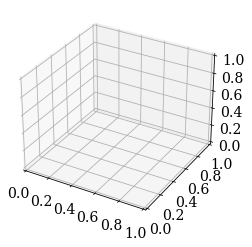

In [29]:
from mpl_toolkits.mplot3d import axes3d
import matplotlib.pyplot as plt
import torch

def plot_implicit(fn, bbox=(-2.5,2.5)):
    #''' create a plot of an implicit function
    #fn  ...implicit function (plot where fn==0)
    #bbox ..the x,y,and z limits of plotted interval'''
    xmin, xmax, ymin, ymax, zmin, zmax = bbox*3
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    A = torch.linspace(xmin, xmax, 100) # resolution of the contour
    B = torch.linspace(xmin, xmax, 15) # number of slices
    A1,A2 = torch.meshgrid(A,A) # grid on which the contour is plotted

    def fn_torch(x, y, z):
        x_torch, y_torch, z_torch = torch.meshgrid(x, y, z)
        x_torch, y_torch, z_torch = x_torch.flatten(), y_torch.flatten(), z_torch.flatten()
        input_torch = torch.stack((x_torch, y_torch, z_torch), dim=1)
        return ham_nn(input_torch).reshape(x.shape[0], y.shape[0])

    for z in B:  # plot contours in the XY plane
        X, Y = A1, A2
        Z = fn_torch(X, Y, z)
        cset = ax.contour(X.numpy(), Y.numpy(), Z.numpy() + z, [z], zdir='z')
        # [z] defines the only level to plot for this contour for this value of z

    for y in B:  # plot contours in the XZ plane
        X, Z = A1, A2
        Y = fn_torch(X, y, Z)
        cset = ax.contour(X.numpy(), Y.numpy() + y.numpy(), Z.numpy(), [y], zdir='y')

    for x in B:  # plot contours in the YZ plane
        Y, Z = A1, A2
        X = fn_torch(x, Y, Z)
        cset = ax.contour(X.numpy() + x.numpy(), Y.numpy(), Z.numpy(), [x], zdir='x')

    # must set plot limits because the contour will likely extend
    # way beyond the displayed level.  Otherwise matplotlib extends the plot limits
    # to encompass all values in the contour.
    ax.set_zlim3d(zmin,zmax)
    ax.set_xlim3d(xmin,xmax)
    ax.set_ylim3d(ymin,ymax)

    plt.show()
    
def ham_nn(hnn_x):
    return hnn_model(torch.Tensor(hnn_x))[1]

# Example usage:
plot_implicit(ham_nn)


In [34]:
t_span=[0.,15.]
t_eval=np.linspace(t_span[0], t_span[1], num=1000)
basem=None
hnnm=None
hnn_htm=None
fig = plt.figure(figsize=[12,6], dpi=DPI)
samples=30
#print(t_eval)
#print(t_span)
for i in range(samples):
    y0 = None
    radius = None
    if y0 is None:
        y0 = np.random.rand(3)*2-1
    if radius is None:
        radius = np.random.rand()*3 + 0.5 # sample a range of radii
    y0[:1] = y0[:1] * radius ## set the appropriate radius
    y0[2]  = y0[2] * 3
    true_x, base_x, hnn_x, hnn_x_ht= integrate_models(x0=y0, t_span=t_span, t_eval=t_eval)
    basem=+((((true_x-base_x)**2).mean(-1))/30)
    hnnm=+ ((((true_x-hnn_x)**2).mean(-1))/30)
    hnn_htm=+((((true_x-hnn_x_ht)**2).mean(-1))/30)
    
#ax5.set_title("MSE between coordinates", pad=tpad) ; ax5.set_xlabel('t')
#print(t_eval)

<Figure size 3600x1800 with 0 Axes>

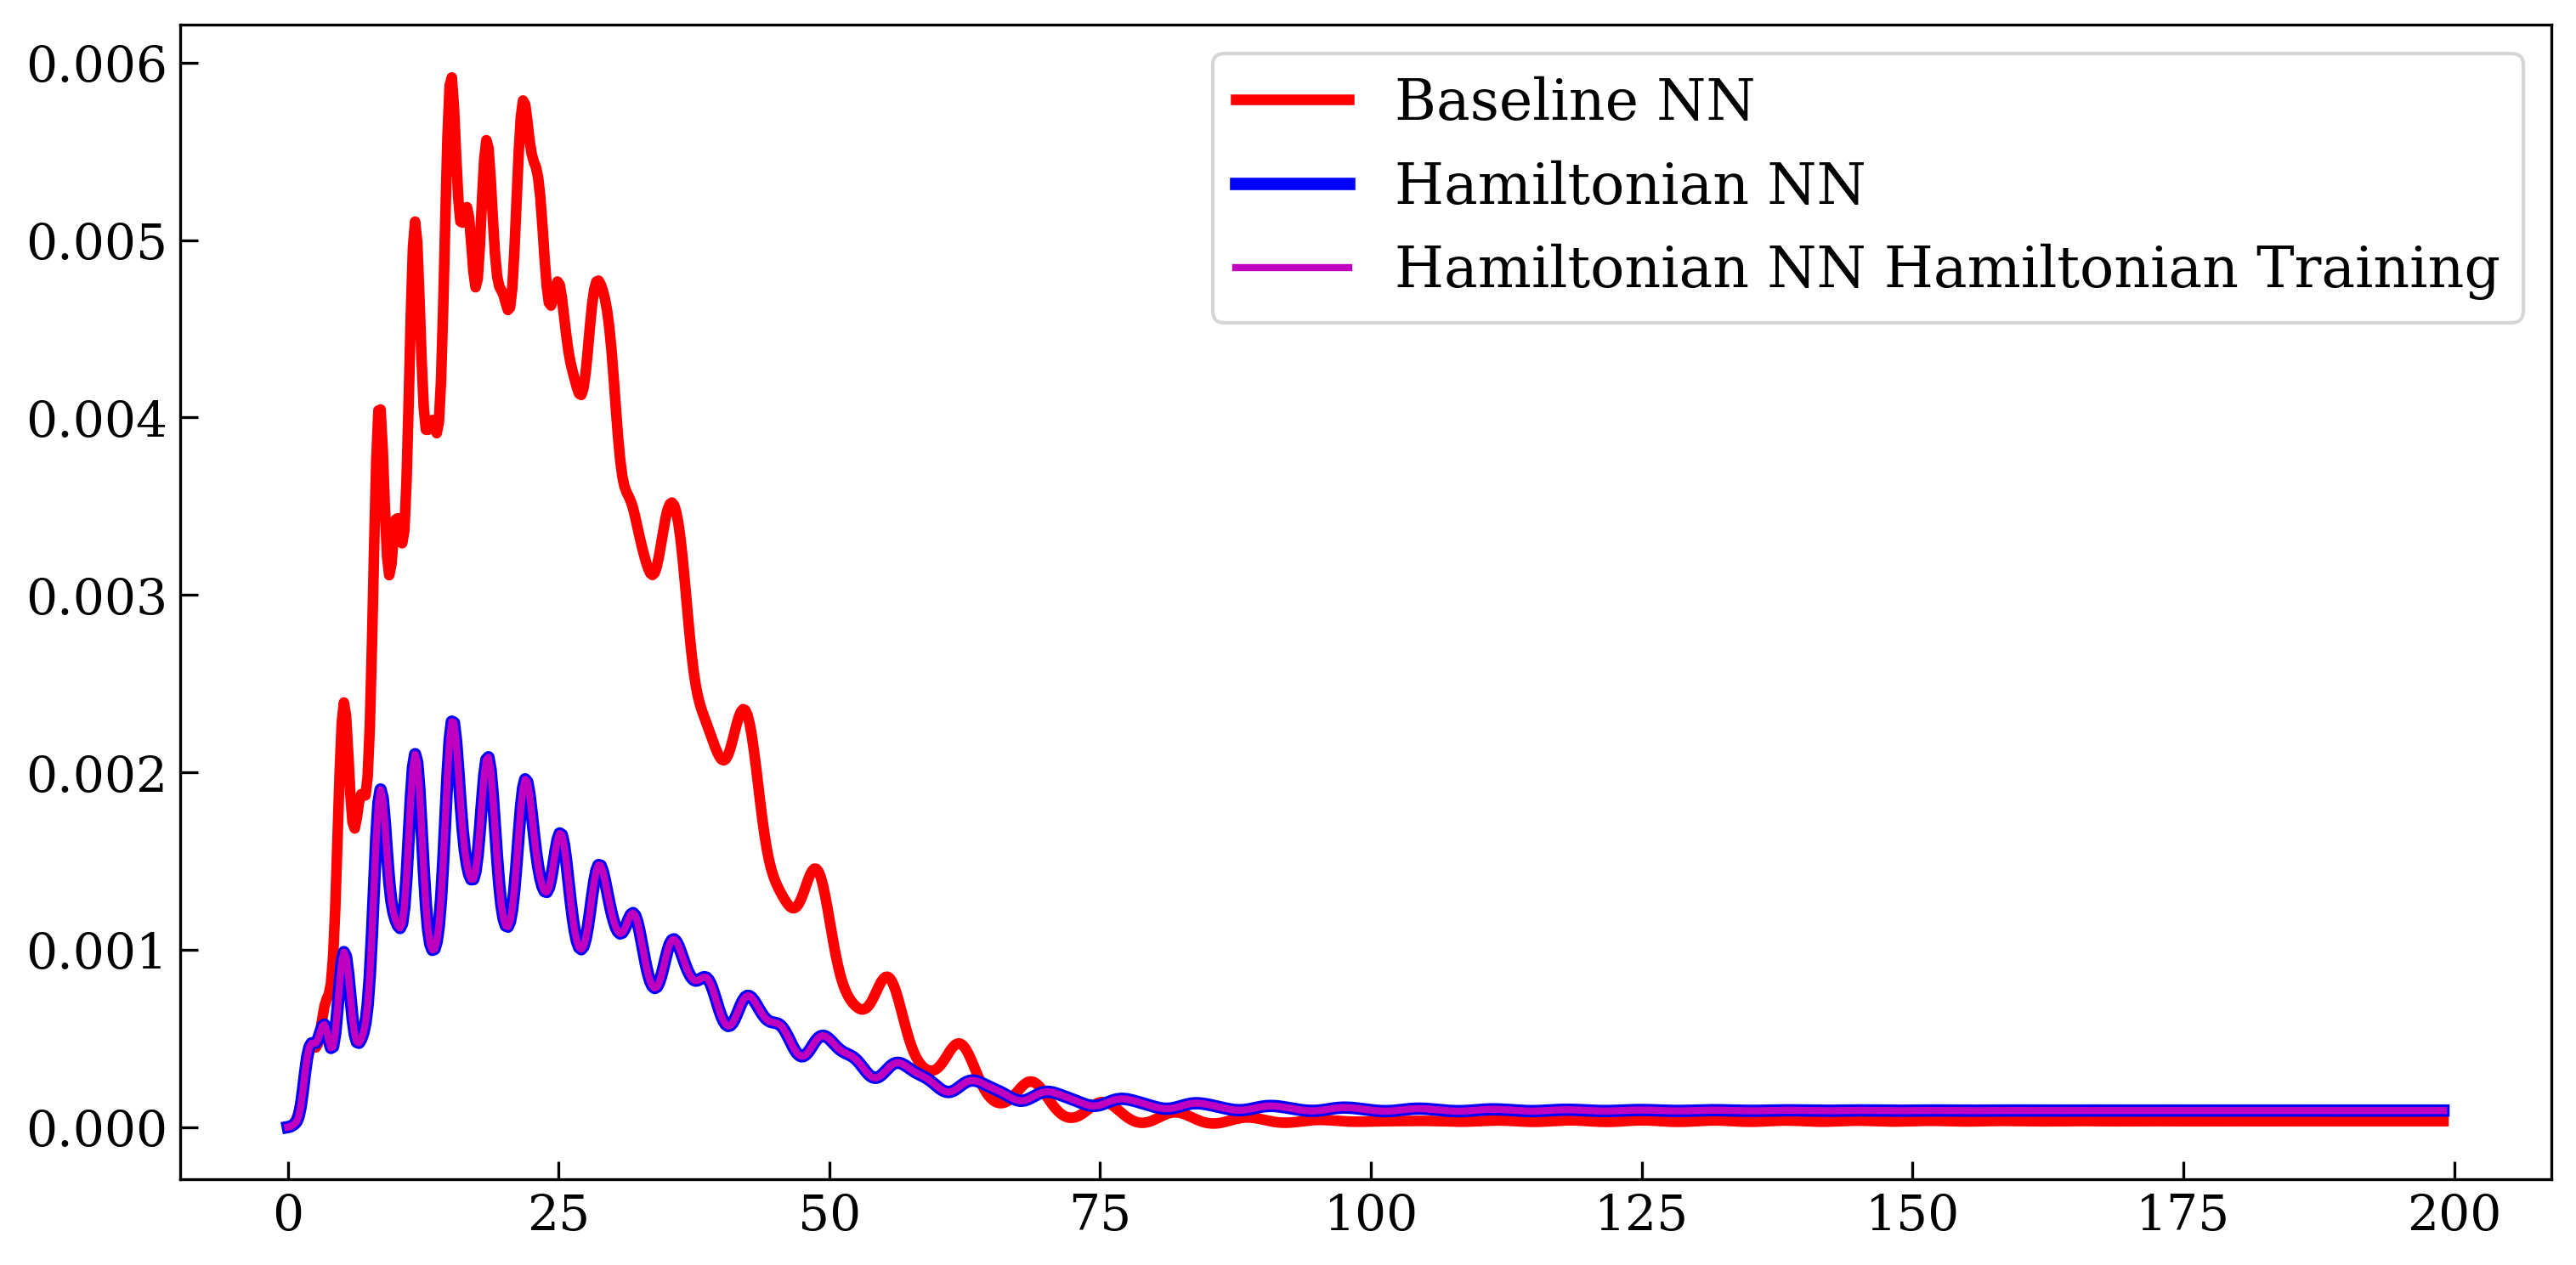

In [38]:
basem.shape
t_eval.shape
fig = plt.figure(figsize=[12,6], dpi=DPI)
plt.plot(t_eval, basem, 'r-', label='Baseline NN', linewidth=3)
plt.plot(t_eval, hnnm, 'b-', label='Hamiltonian NN', linewidth=3.5)
plt.plot(t_eval, hnn_htm, 'm-', label='Hamiltonian NN Hamiltonian Training', linewidth=2)
plt.legend(fontsize=16)
plt.show()

In [39]:
fig.savefig('{}/spring-integrationmse1{}.{}'.format(args.fig_dir, RK4, FORMAT))

In [ ]:
plt.plot(t_eval, basem, 'r-', label='Baseline NN', linewidth=3)
plt.plot(t_eval, hnnm, 'm-', label='Hamiltonian NN', linewidth=2)
plt.legend(fontsize=7)
plt.show()

In [ ]:
y0

In [ ]:
y0 = np.random.rand(3)*2-1
y0

In [ ]:
y0

In [ ]:
t_eval

In [ ]:
np.linspace(0, 5, num=20)

In [ ]:
t_span=[0.,5.]


In [ ]:
t_span